In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

In [2]:
# Read the parquet file, this takes a while. Leave it here
dft = pl.read_parquet("Train.parquet", use_pyarrow=True, memory_map=True)

In [3]:
def pad_image_to_largest_size(original_image, cropped_image):
    """
    Repad original images to scaled size if needed for display only
    matplotlib really likes them to have the same dimensions
    """
    target_shape = original_image.shape

    # Create a new array of zeros with the target shape
    padded_array = np.zeros(target_shape, dtype=cropped_image.dtype)

    # Copy the smaller array into the top-left corner of the padded array
    padded_array[: cropped_image.shape[0], : cropped_image.shape[1]] = cropped_image
    return_array = np.concatenate((original_image, padded_array), axis=1)
    return return_array

In [13]:
def restore_image_from_list(width: int, height: int, image: list) -> np.array:
    return np.array(image).reshape((height, width, 3))


def image_for_display(image: np.array) -> np.array:
    """
    Convert image to 0-255 range
    """
    return np.clip((image * 256), 0, 255).astype(np.uint8)


def equalize_histogram(image: np.array) -> np.array:
    """
    Equalize the histogram of a 2D image. This appeard to make everything worse by in large.
    Introduced a lot of noise.
    """
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8)).apply(l_channel)
    # equalized_l_channel = cv2.equalizeHist(l_channel)
    equalized_l_channel = l_channel
    lab_image = np.stack((equalized_l_channel, a_channel, b_channel), axis=2)
    rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)
    return rgb_image


def stretch_histogram(image: np.array) -> np.array:
    """
    Stretch the histogram of the image to the full range of 0-255
    For our data this appears to work much better than equalizing the histogram
    """
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel = lab_image[:, :, 0]
    stretched_l_channel = (
        (l_channel - np.min(l_channel)) / (np.max(l_channel) - np.min(l_channel)) * 255
    ).astype(np.uint8)
    stretched_lab_image = np.stack(
        (stretched_l_channel, lab_image[:, :, 1], lab_image[:, :, 2]), axis=2
    )
    rgb_image = cv2.cvtColor(stretched_lab_image, cv2.COLOR_LAB2RGB)
    return rgb_image

C:\Users\teddy\AppData\Local\Temp\ipykernel_31564\3630524336.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(20, 20))


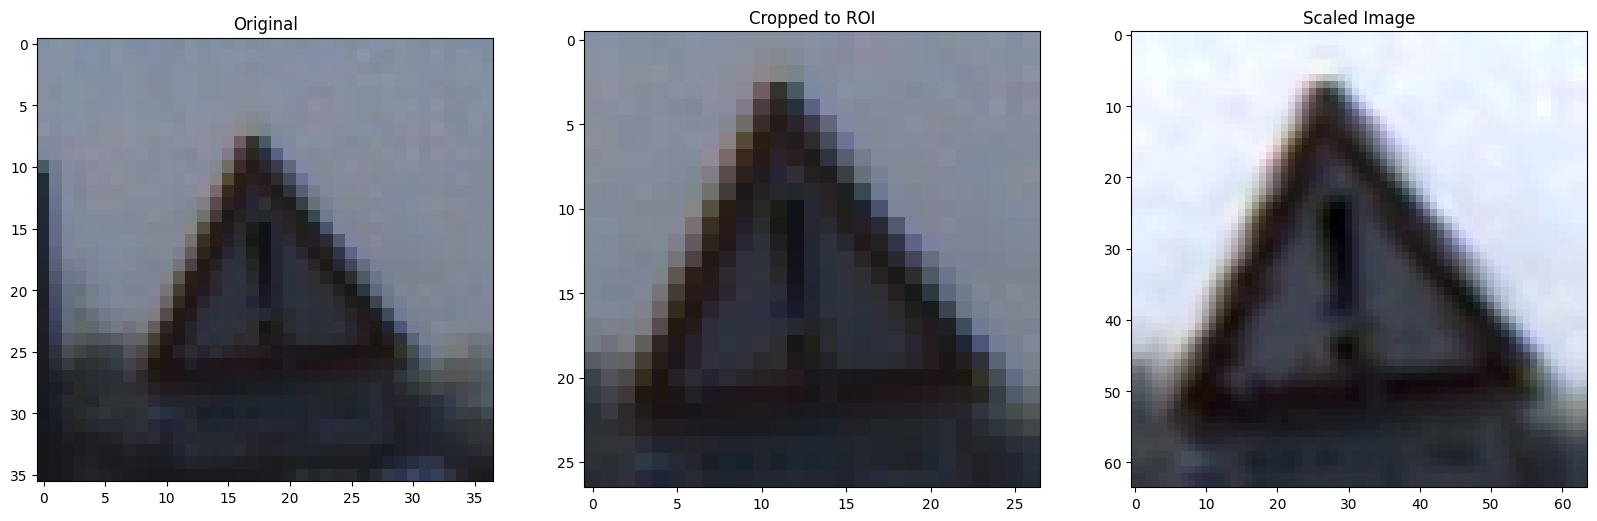

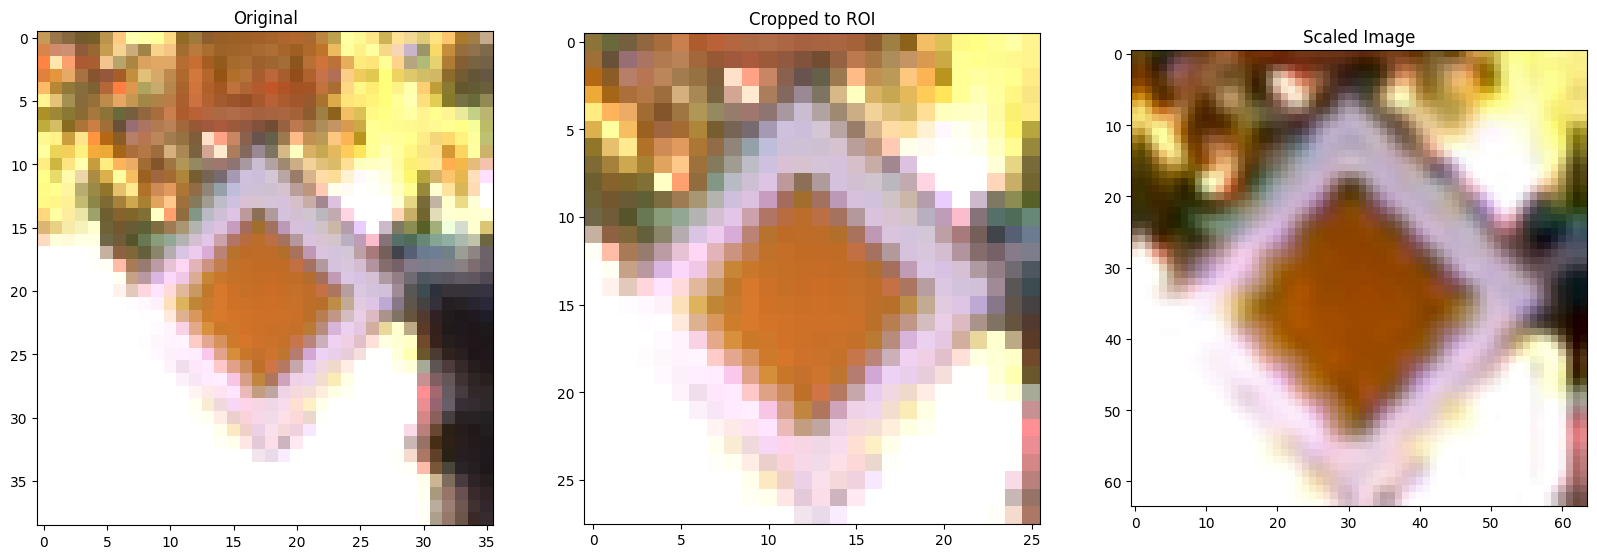

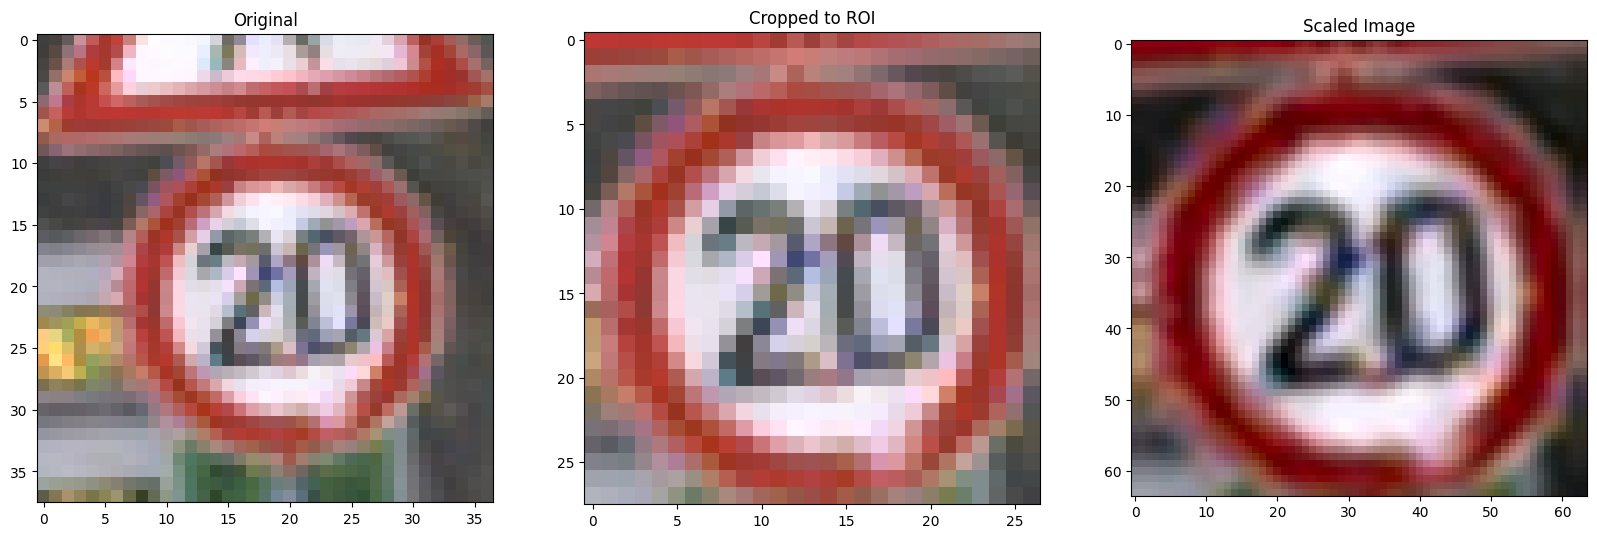

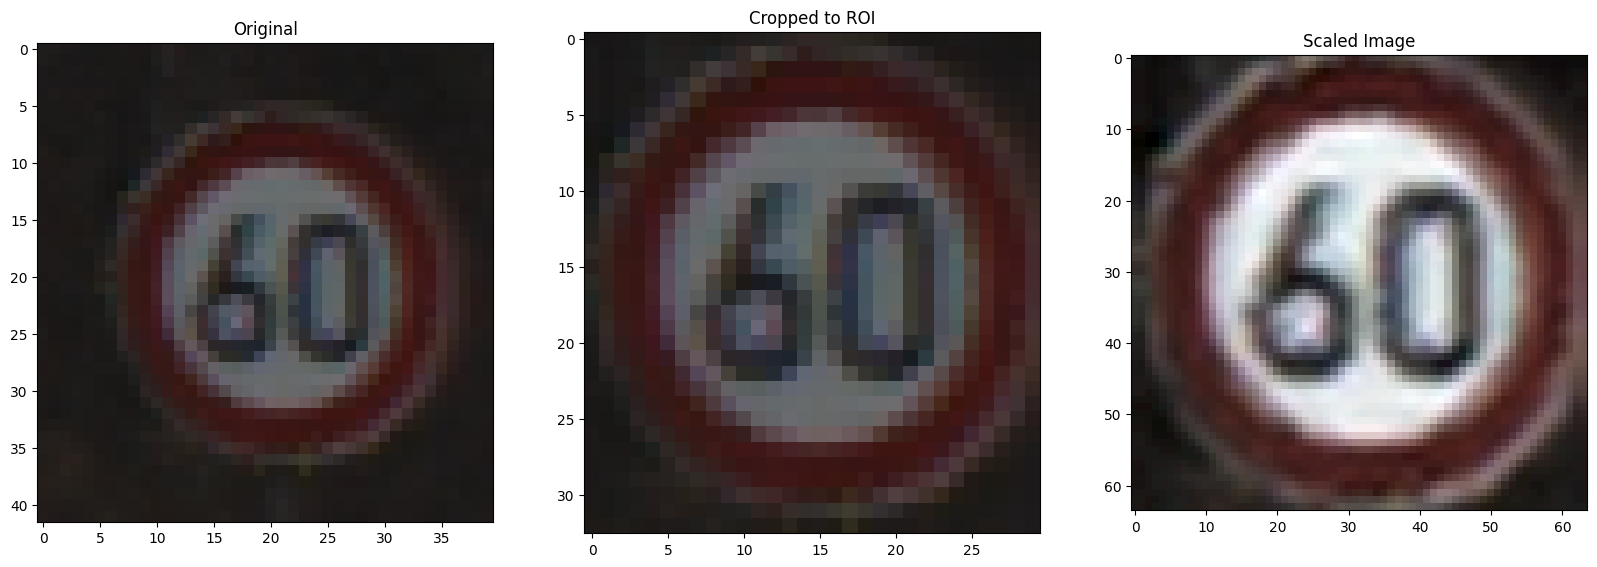

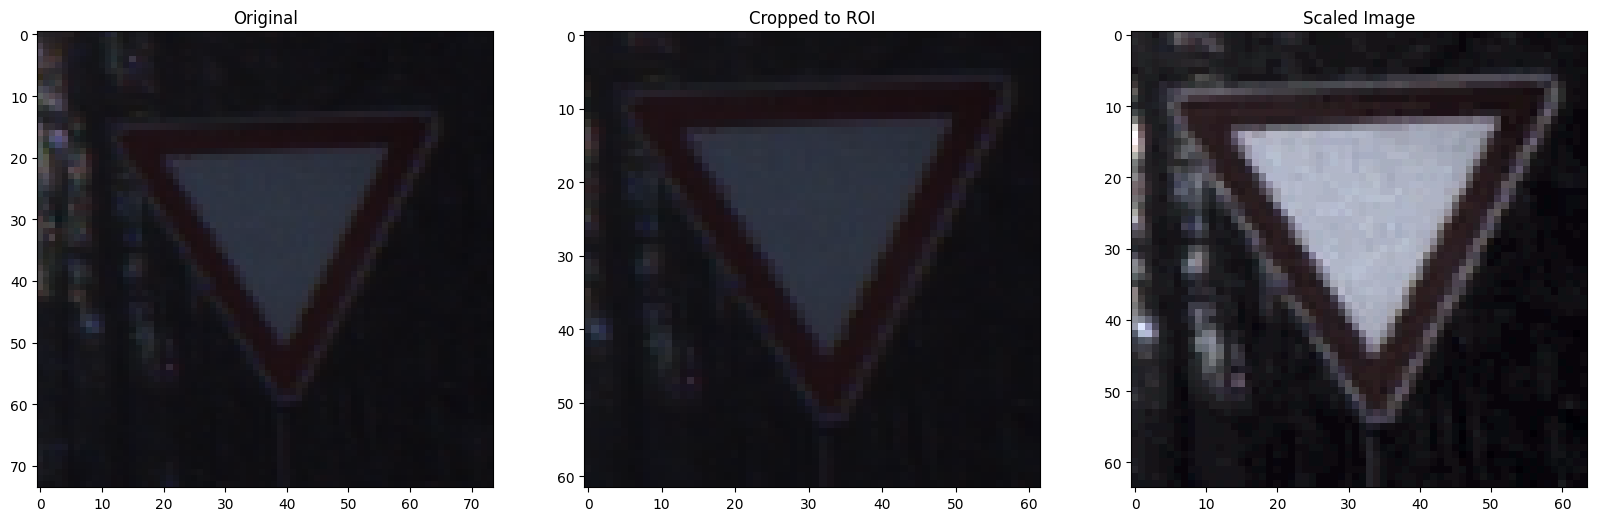

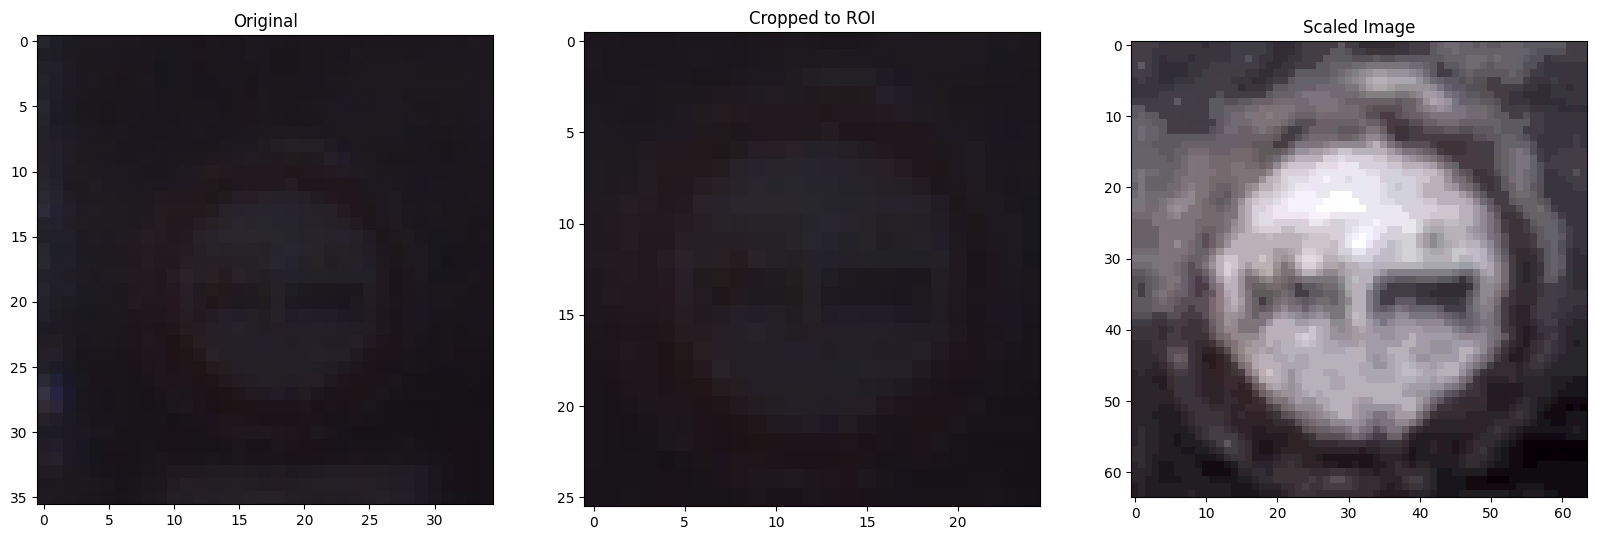

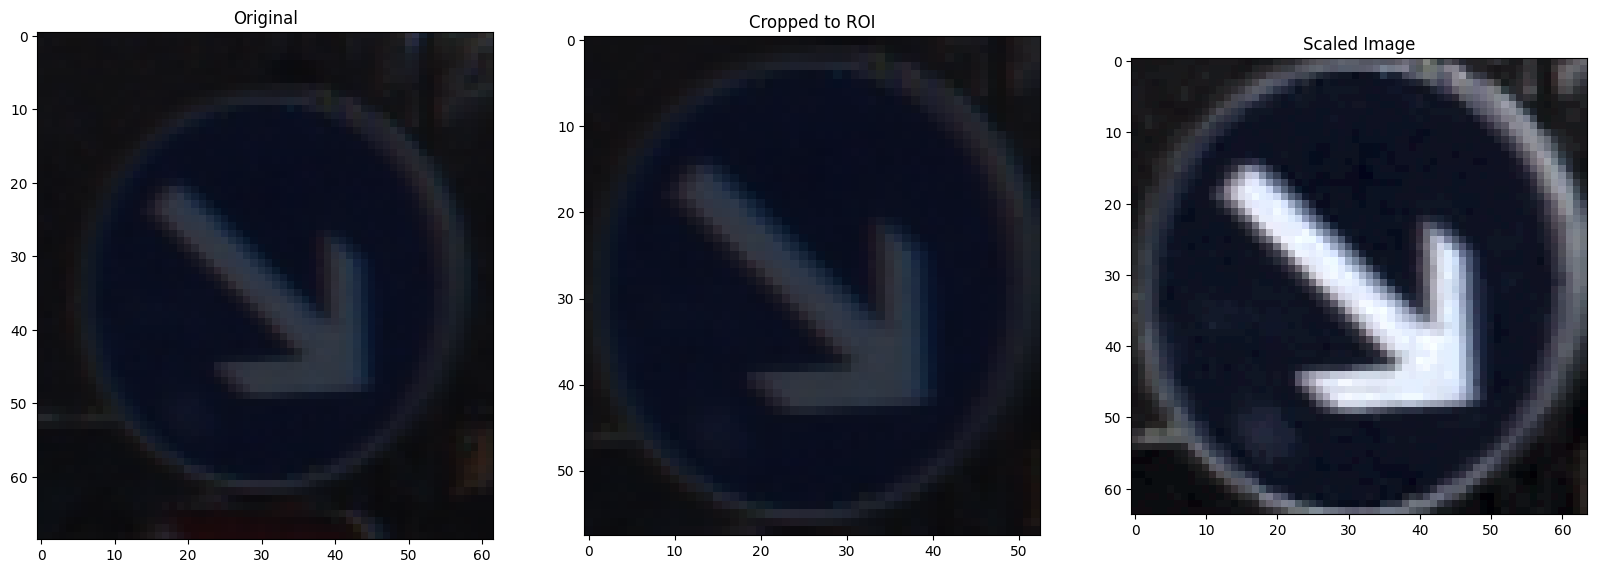

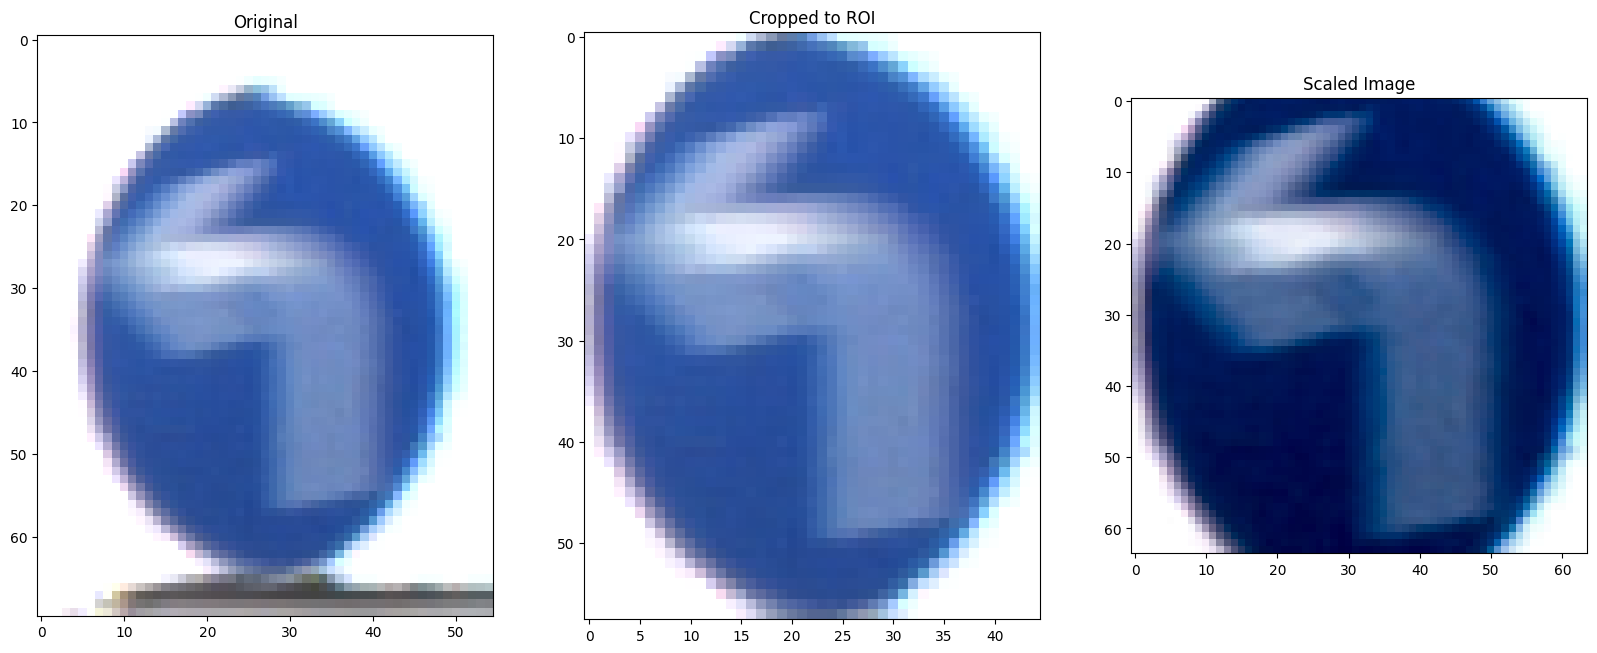

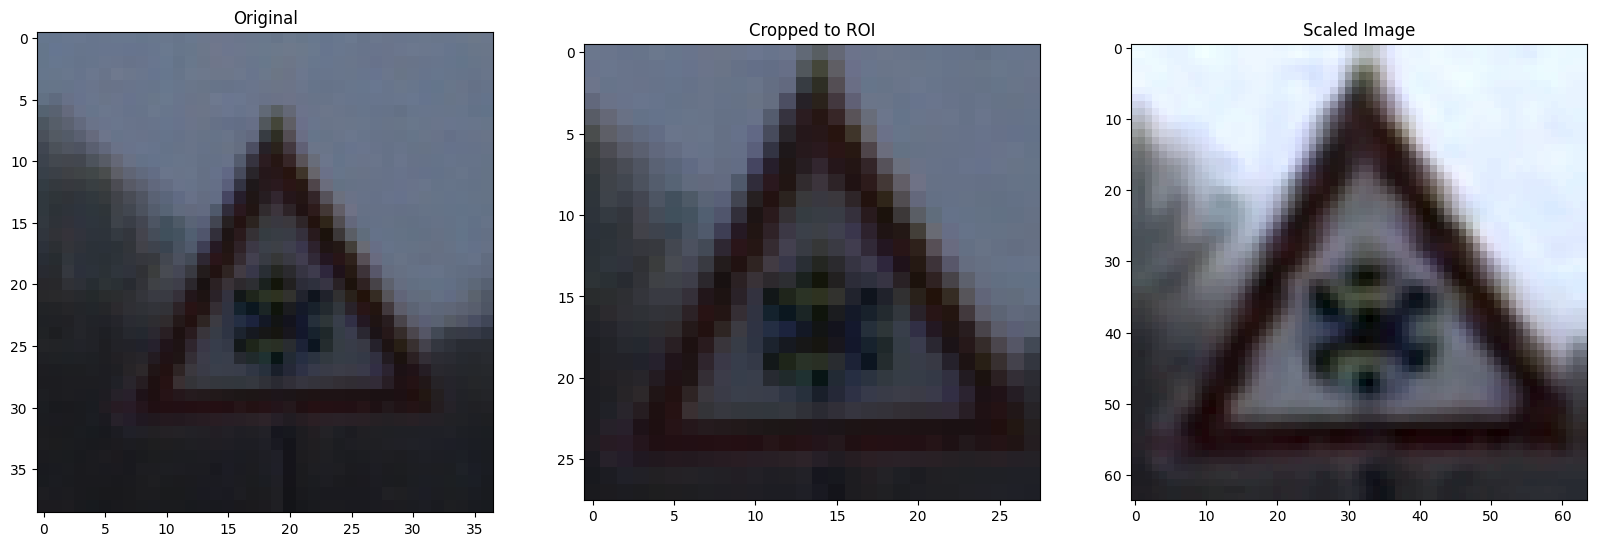

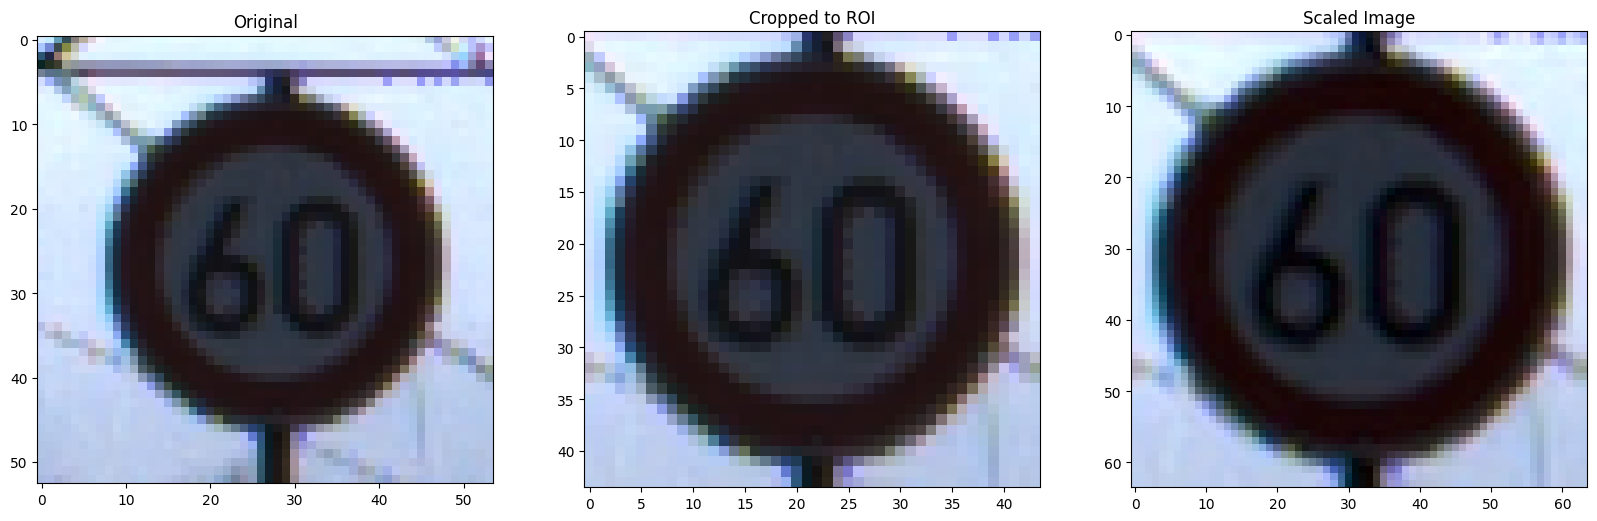

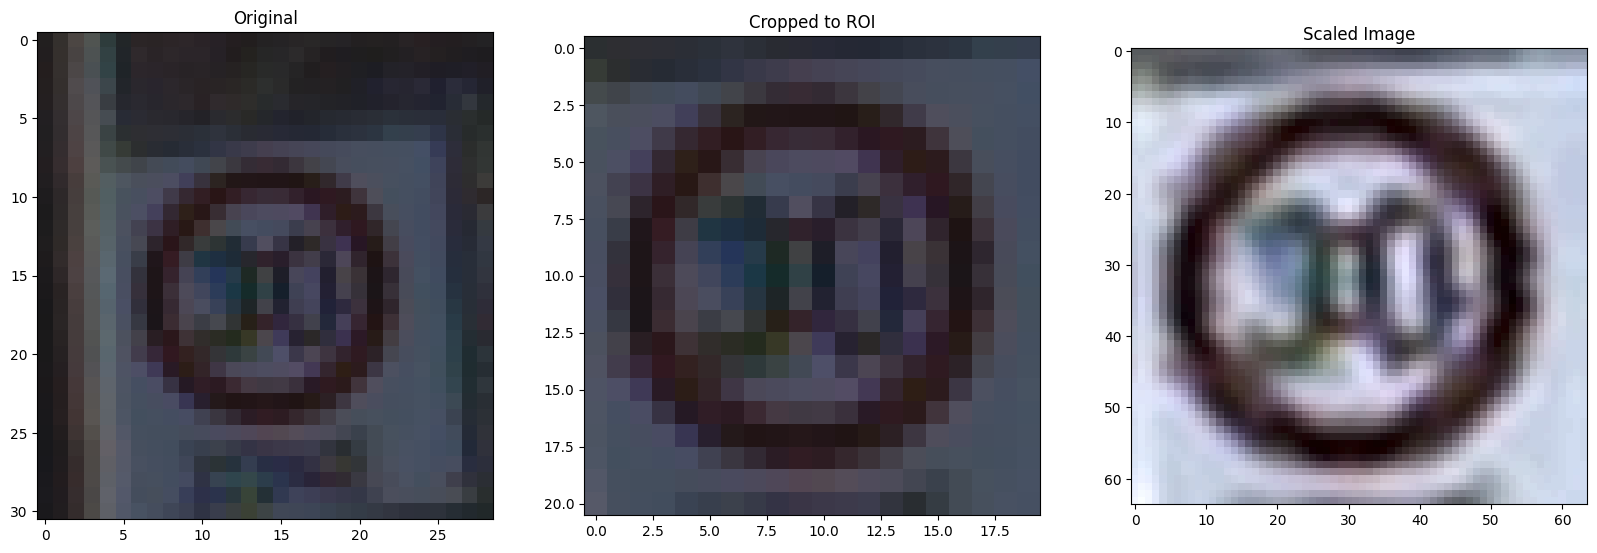

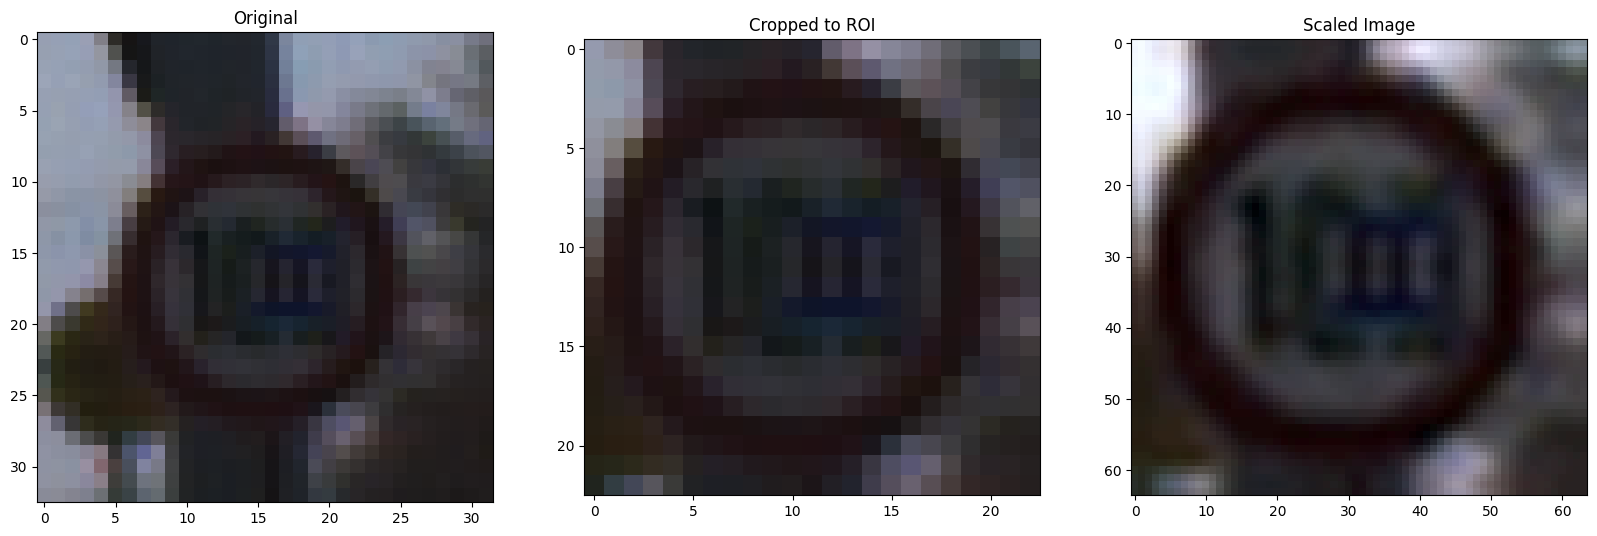

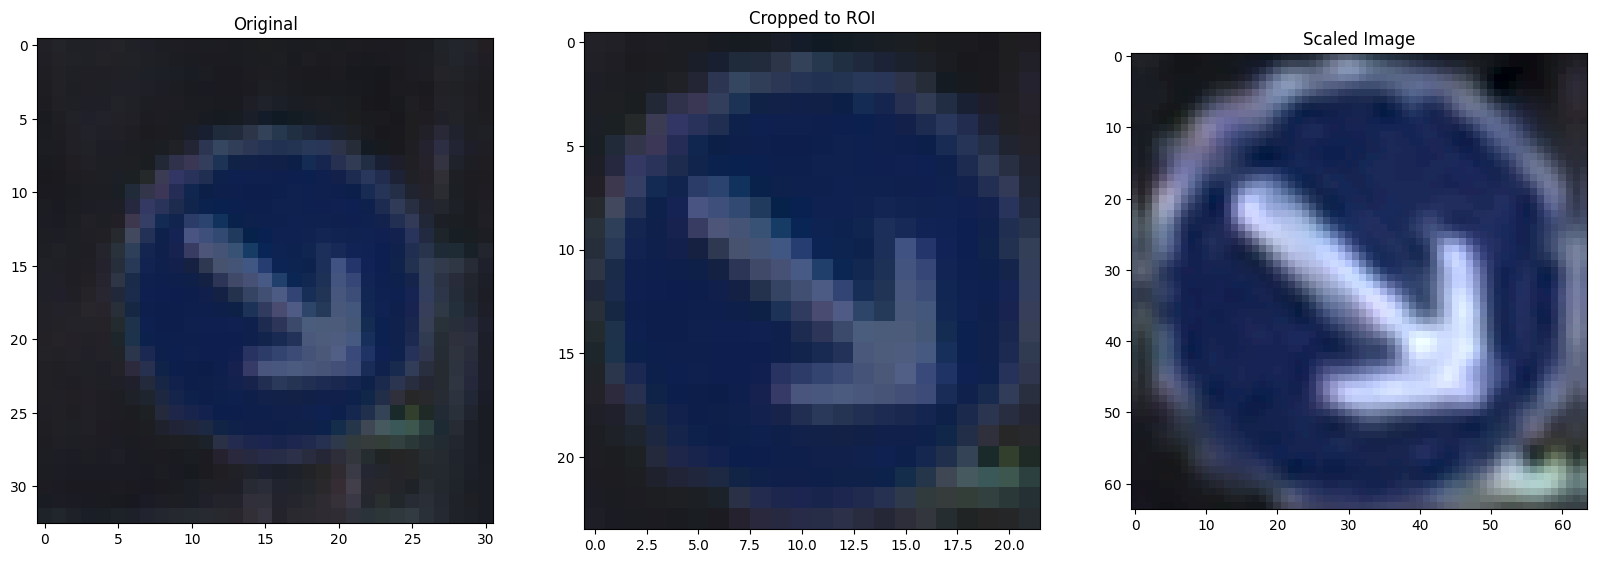

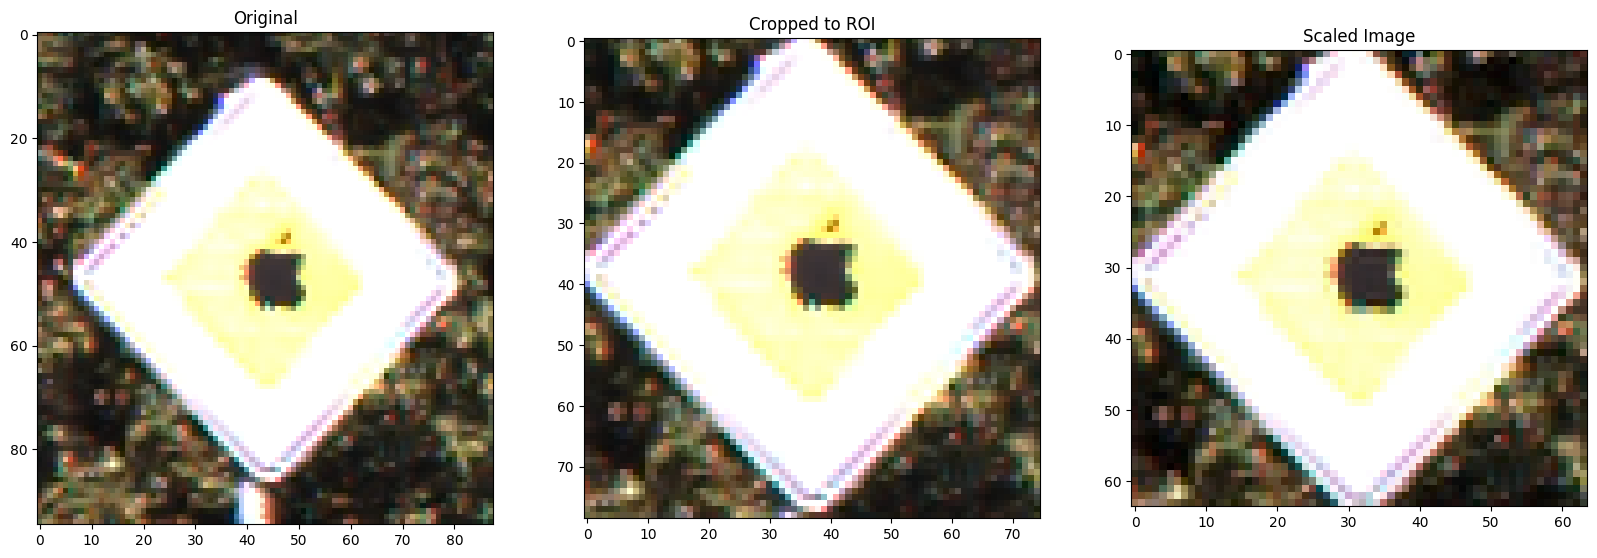

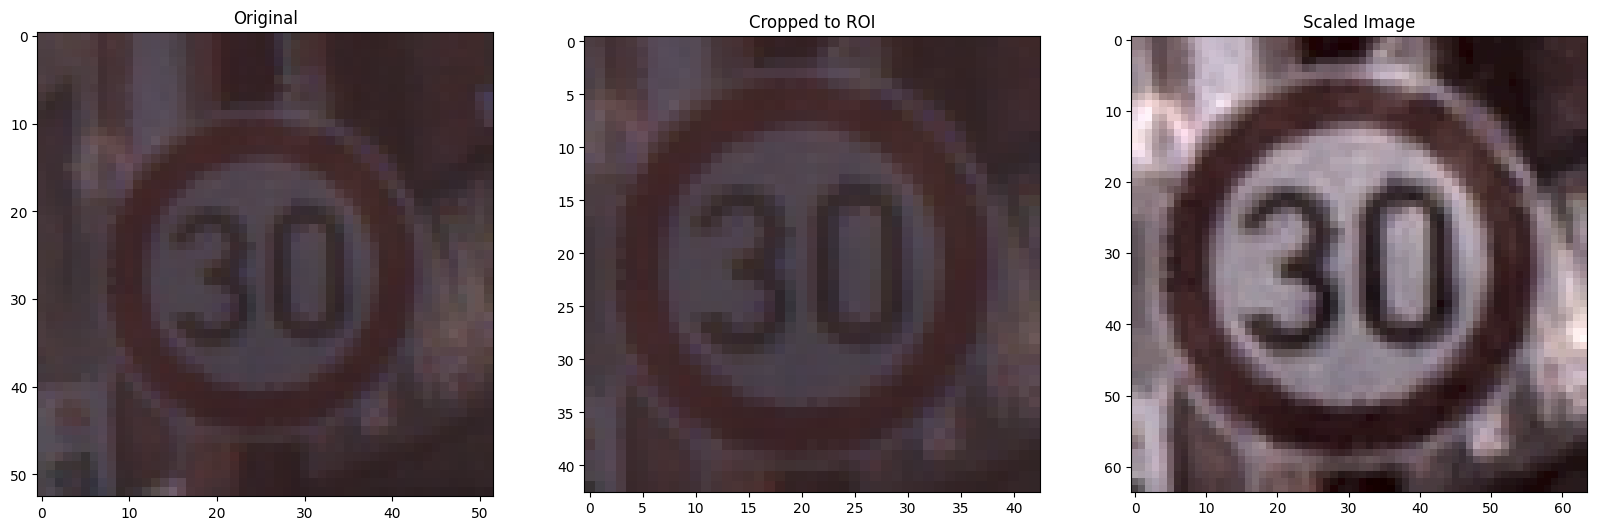

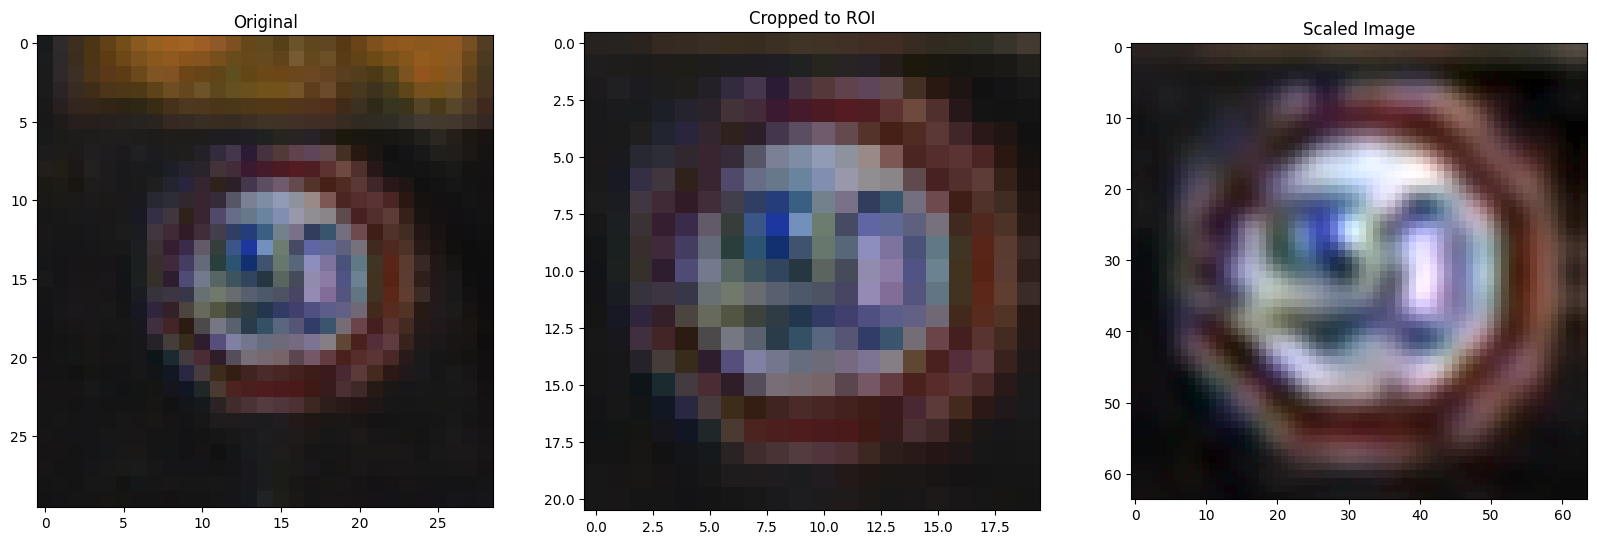

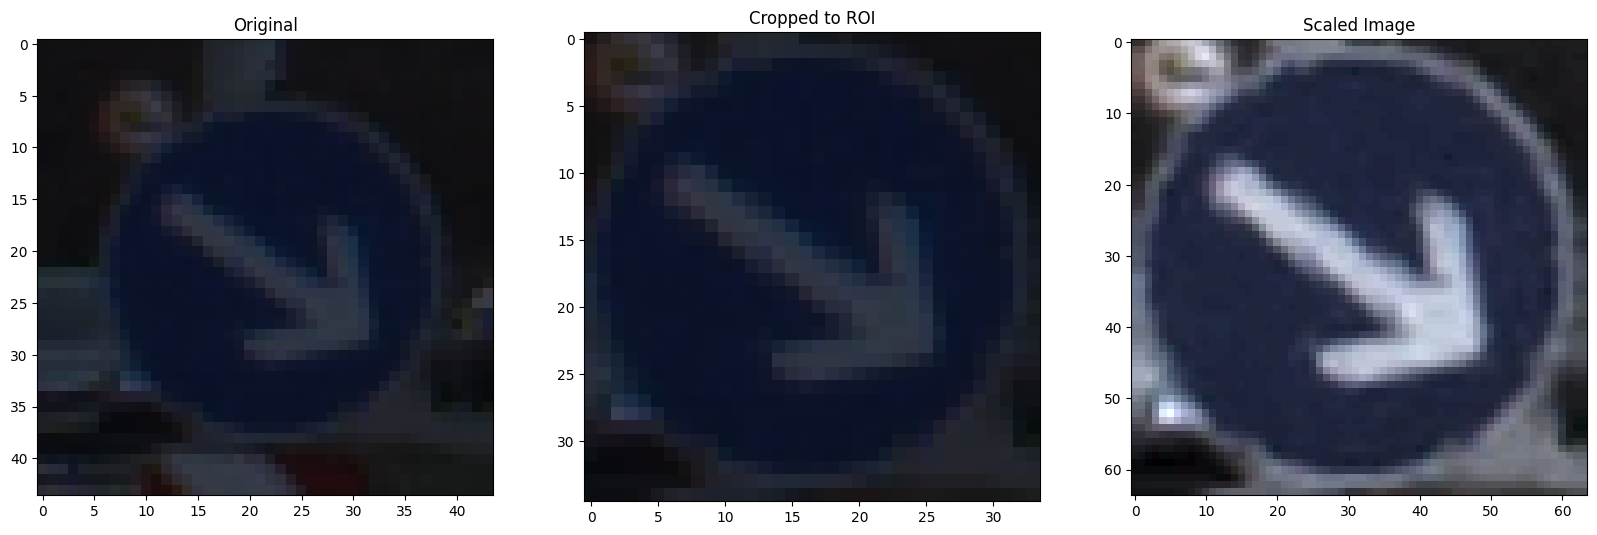

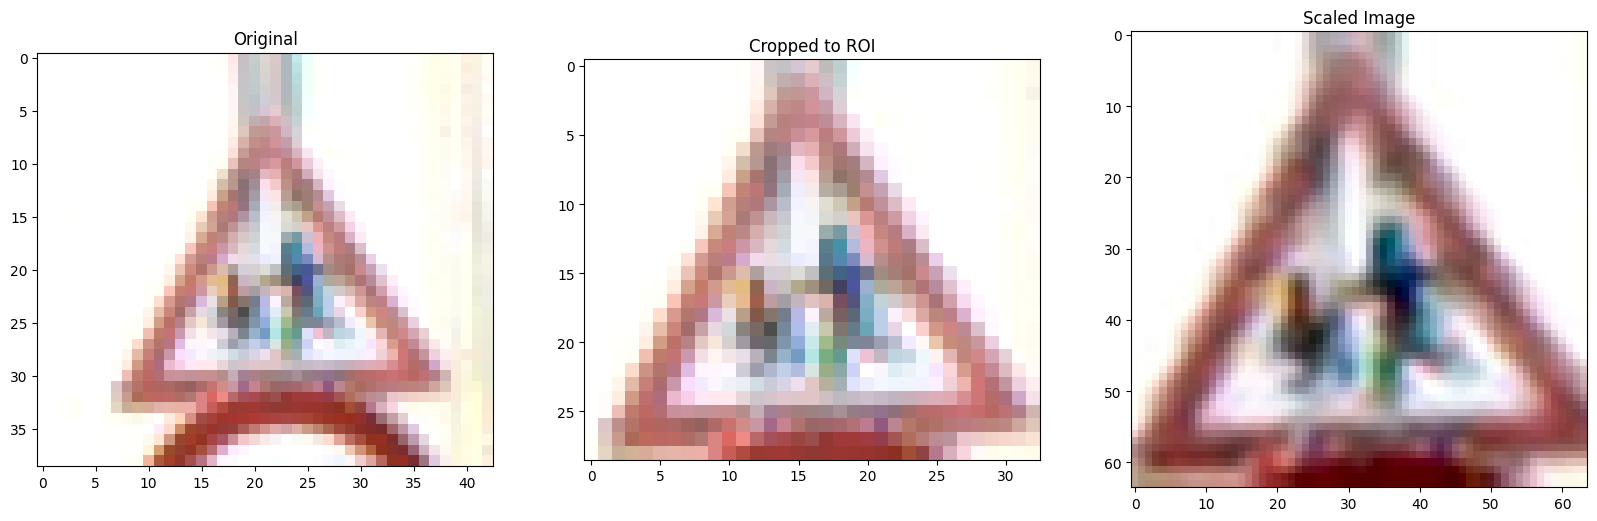

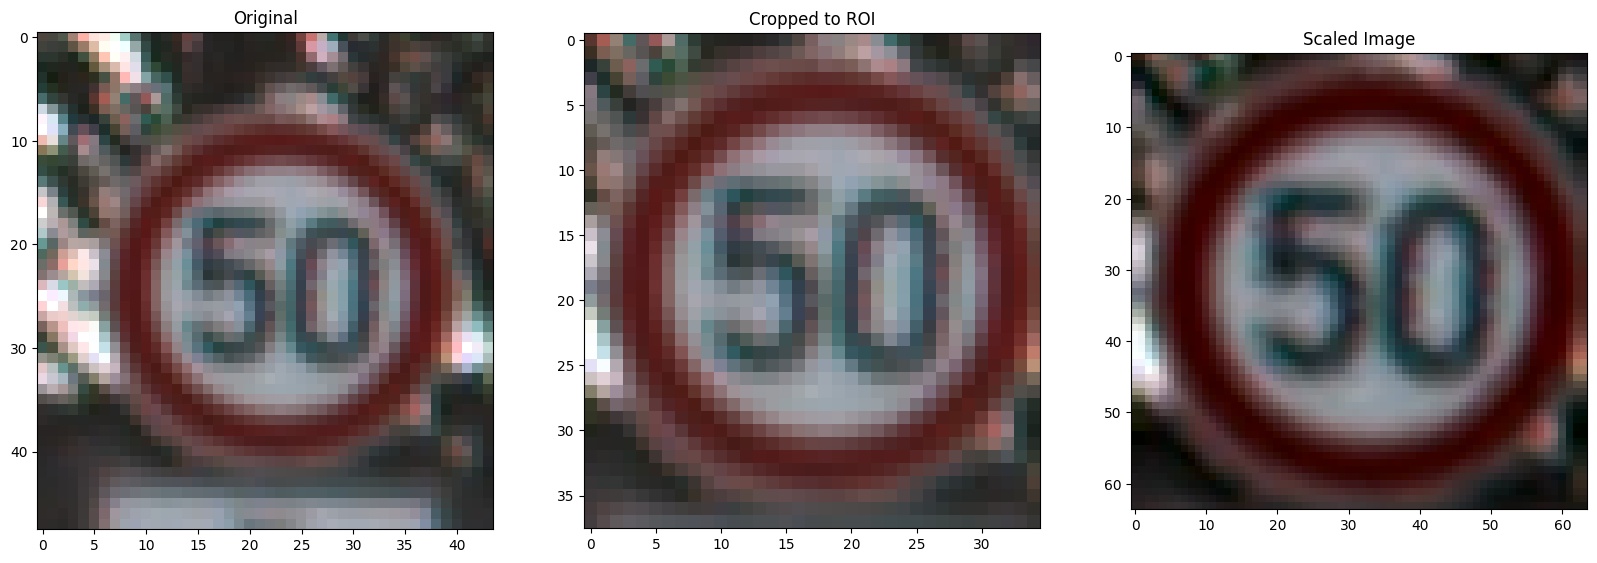

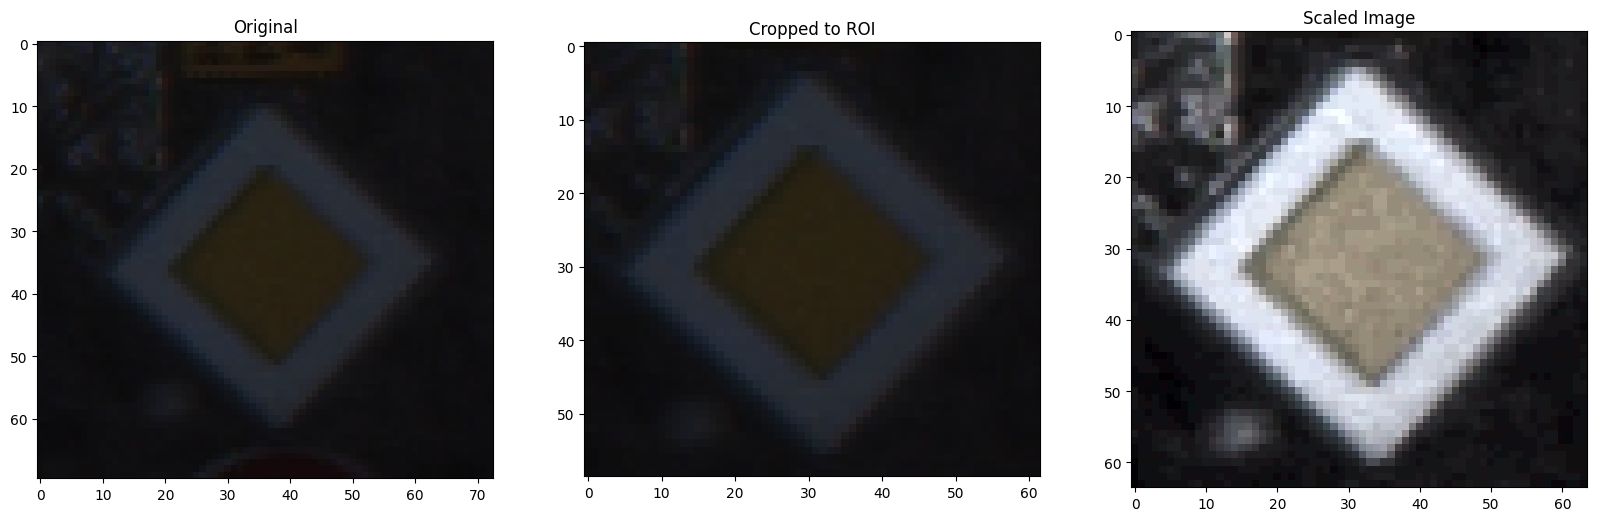

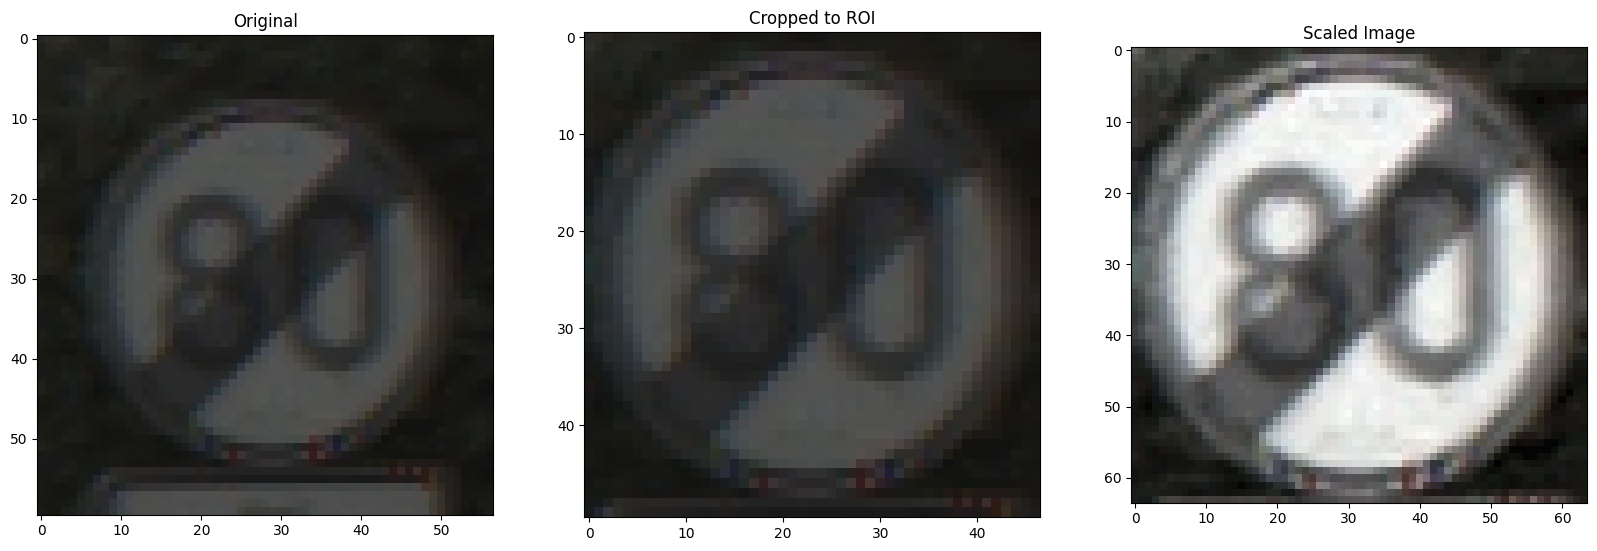

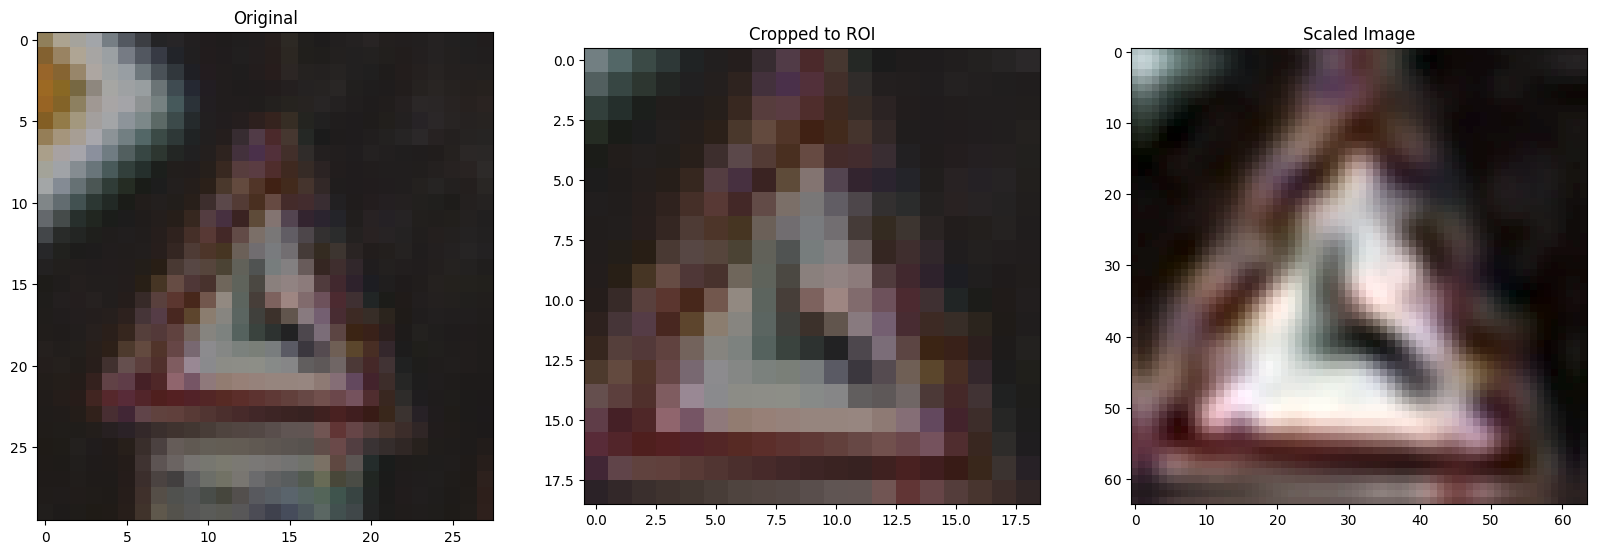

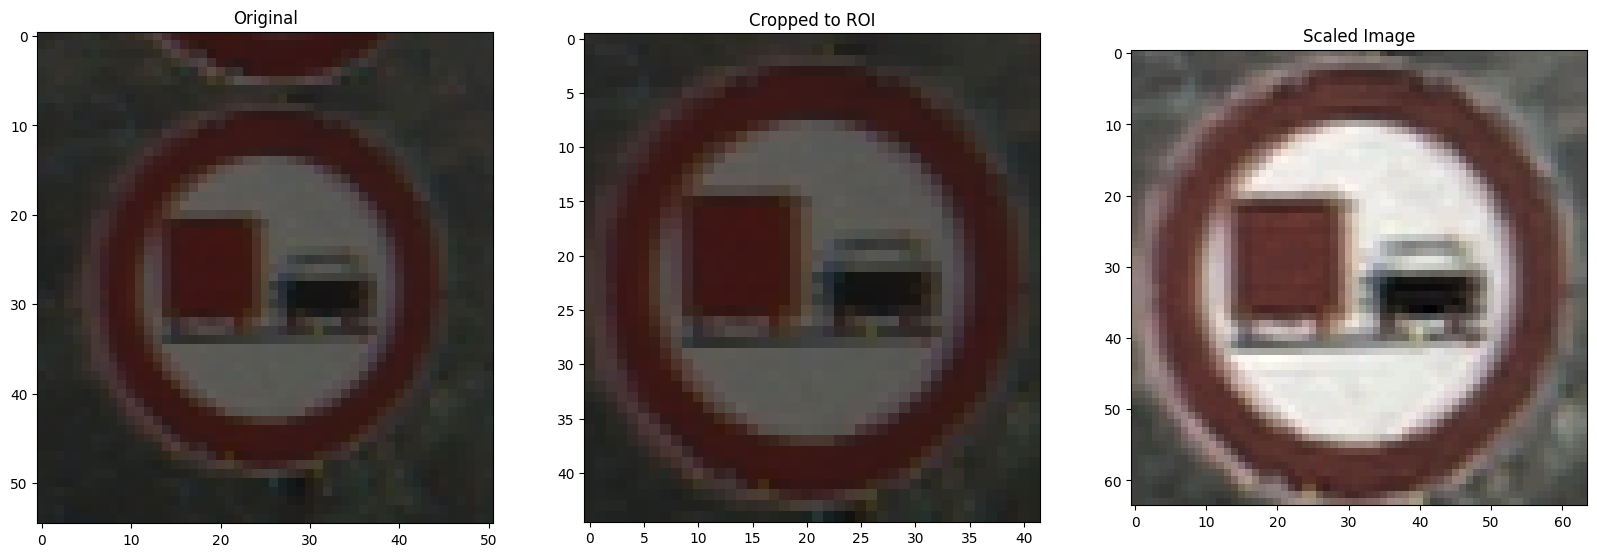

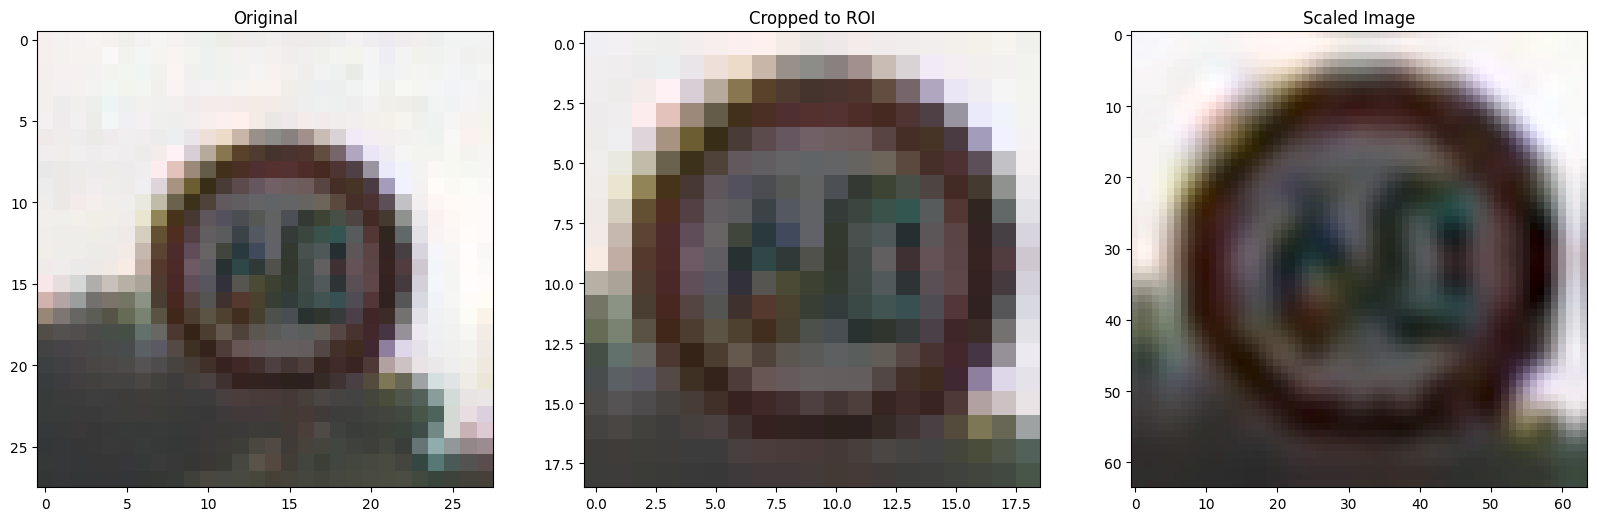

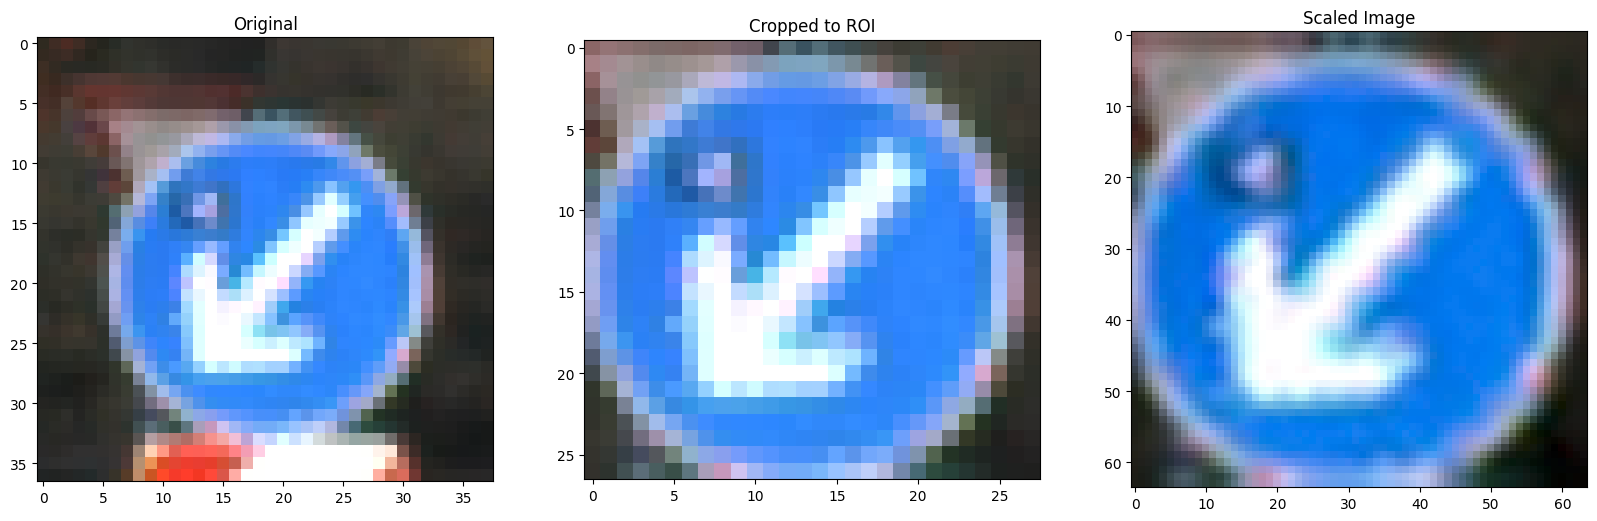

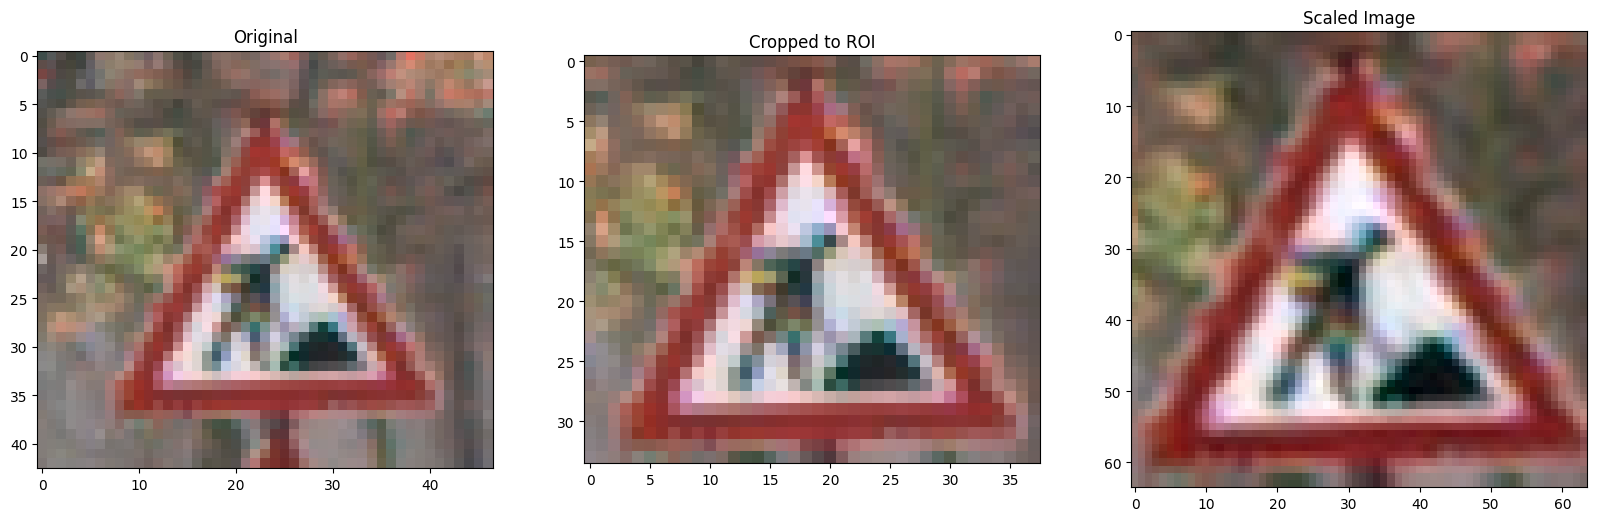

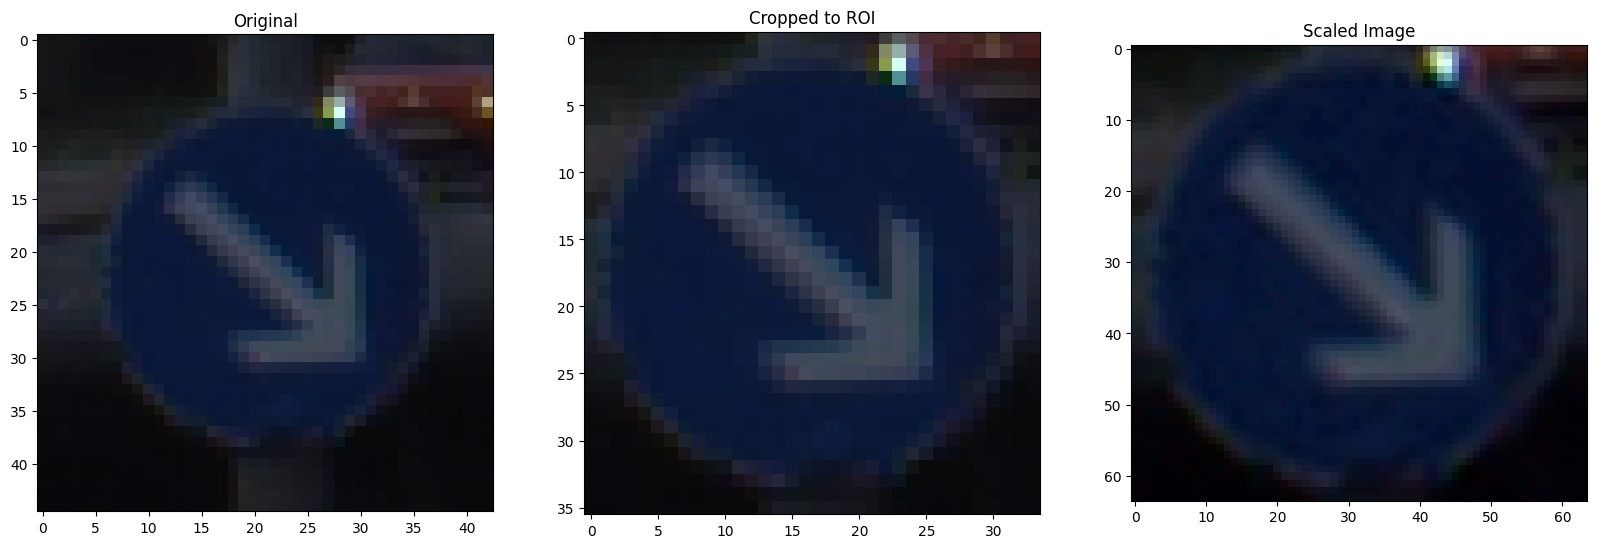

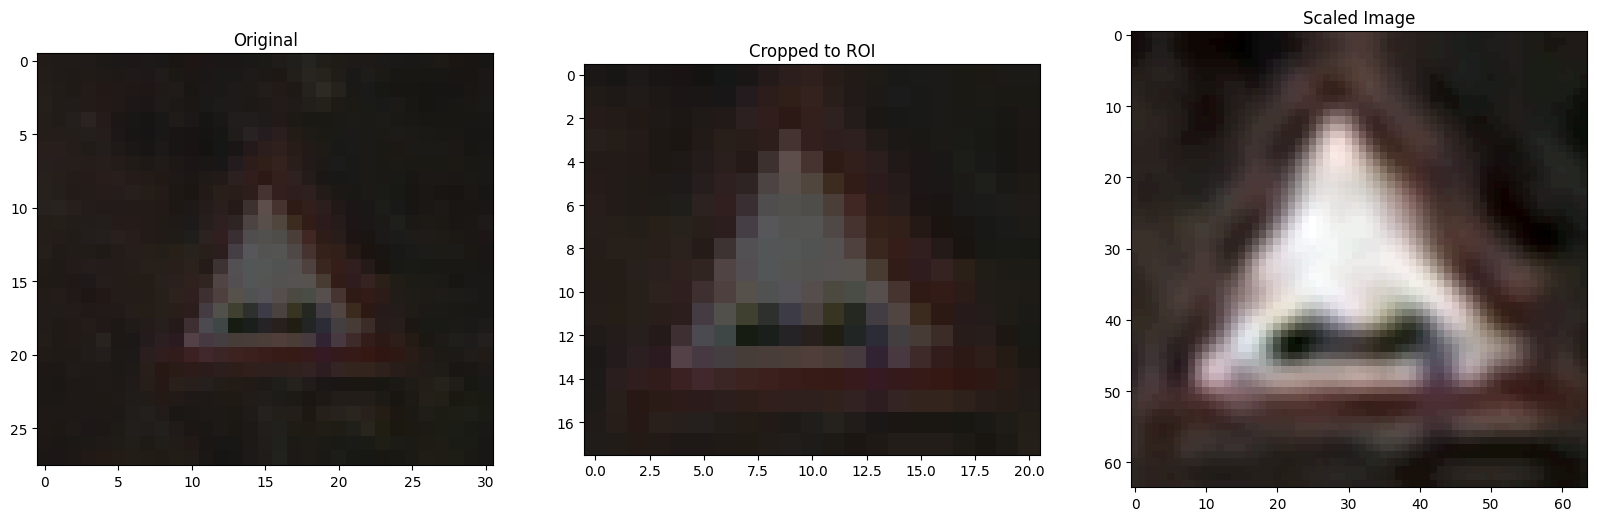

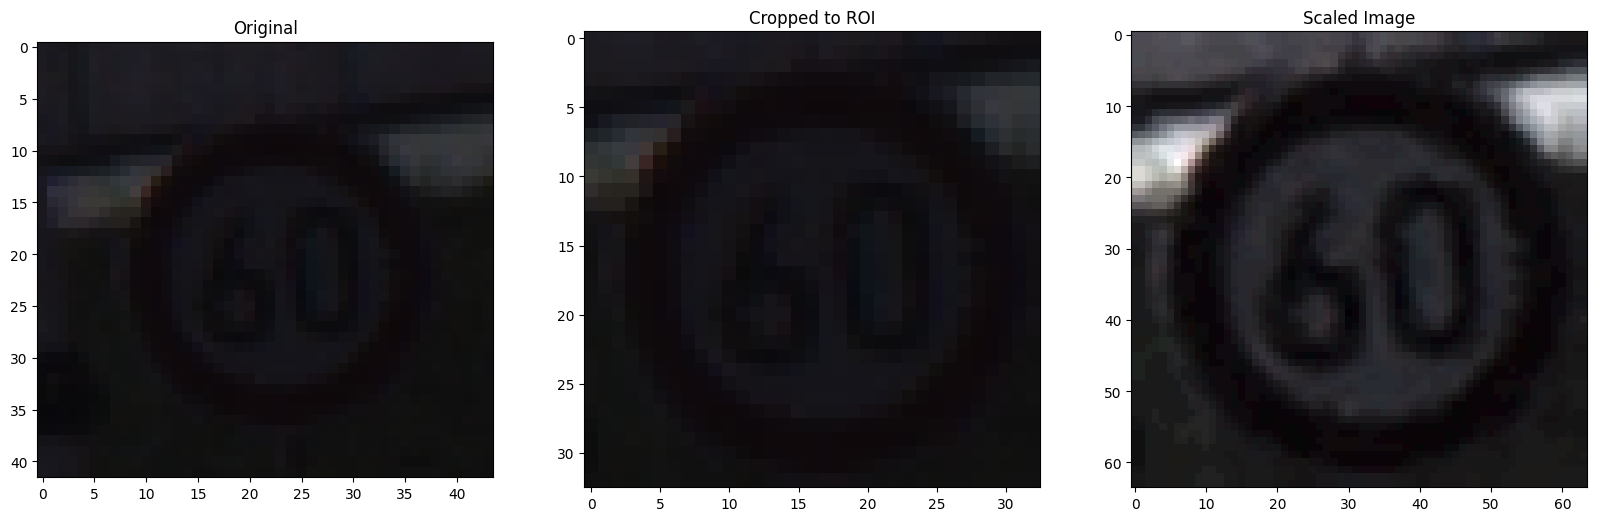

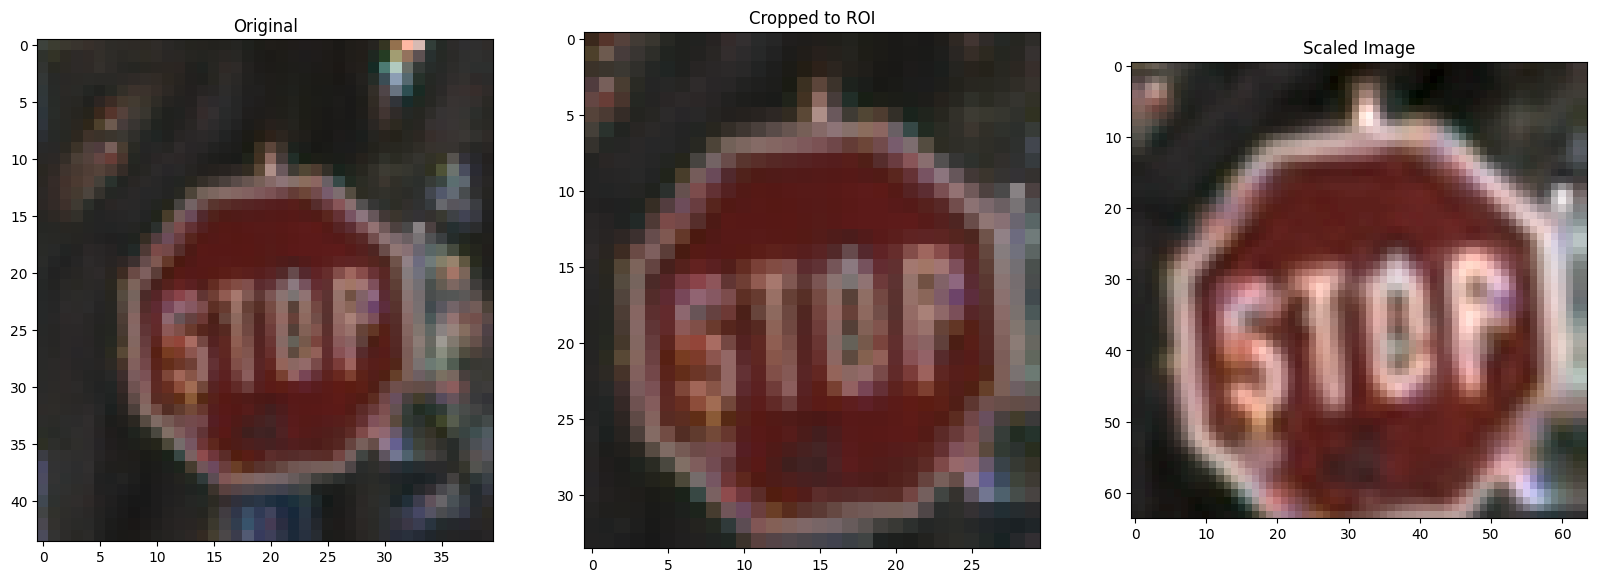

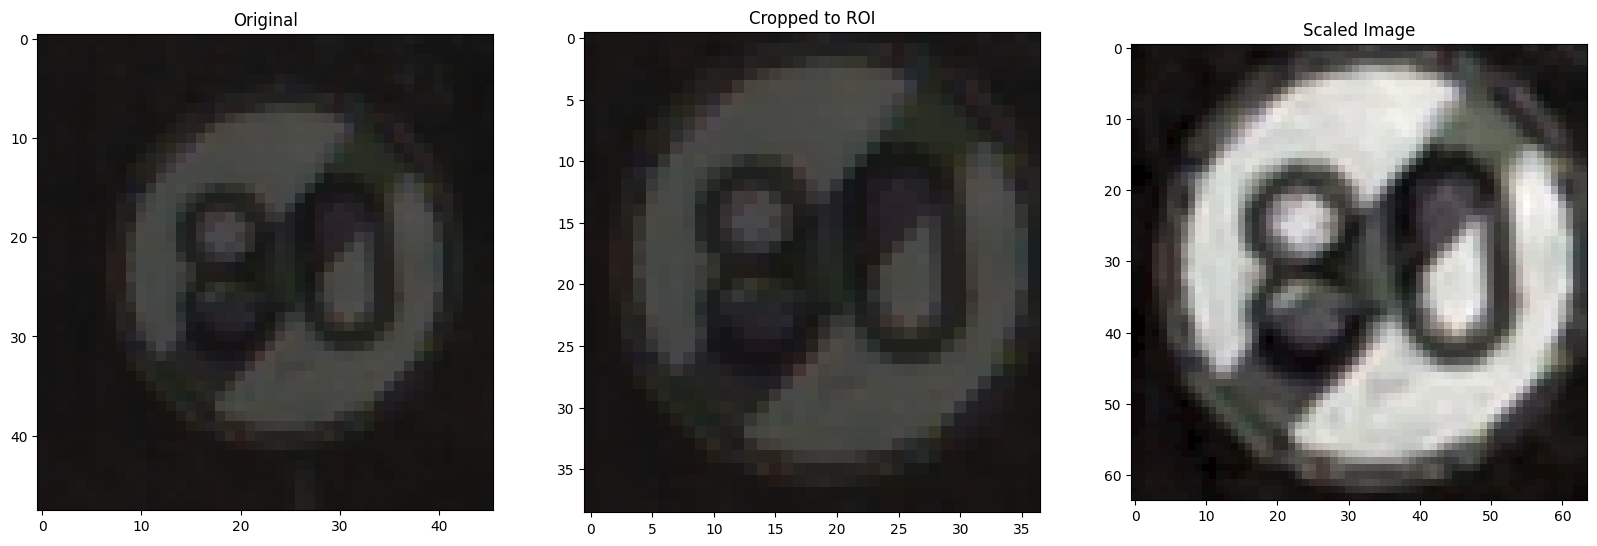

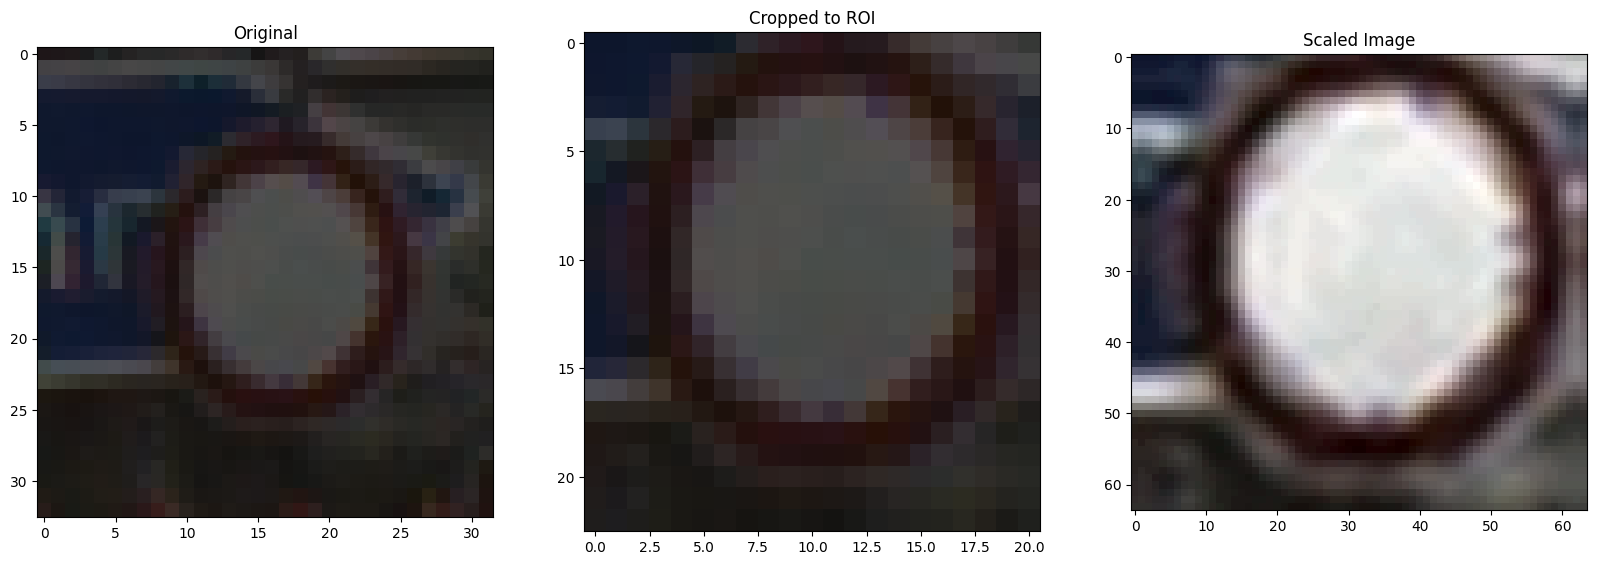

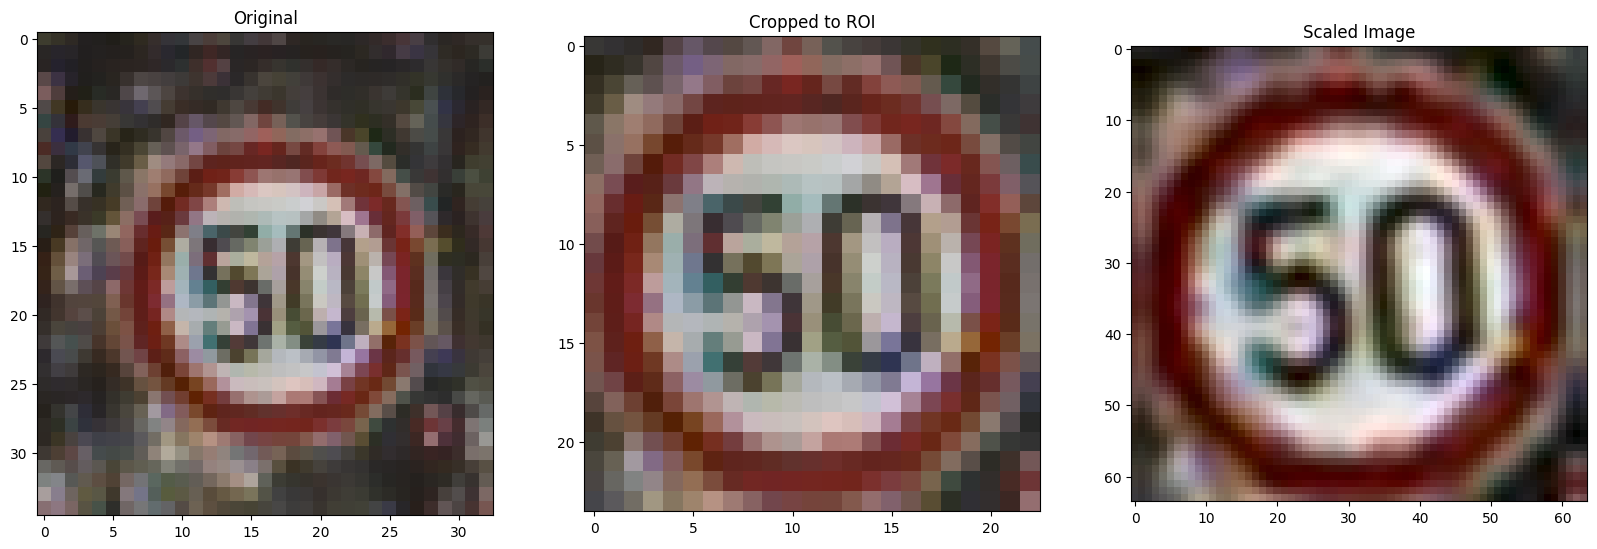

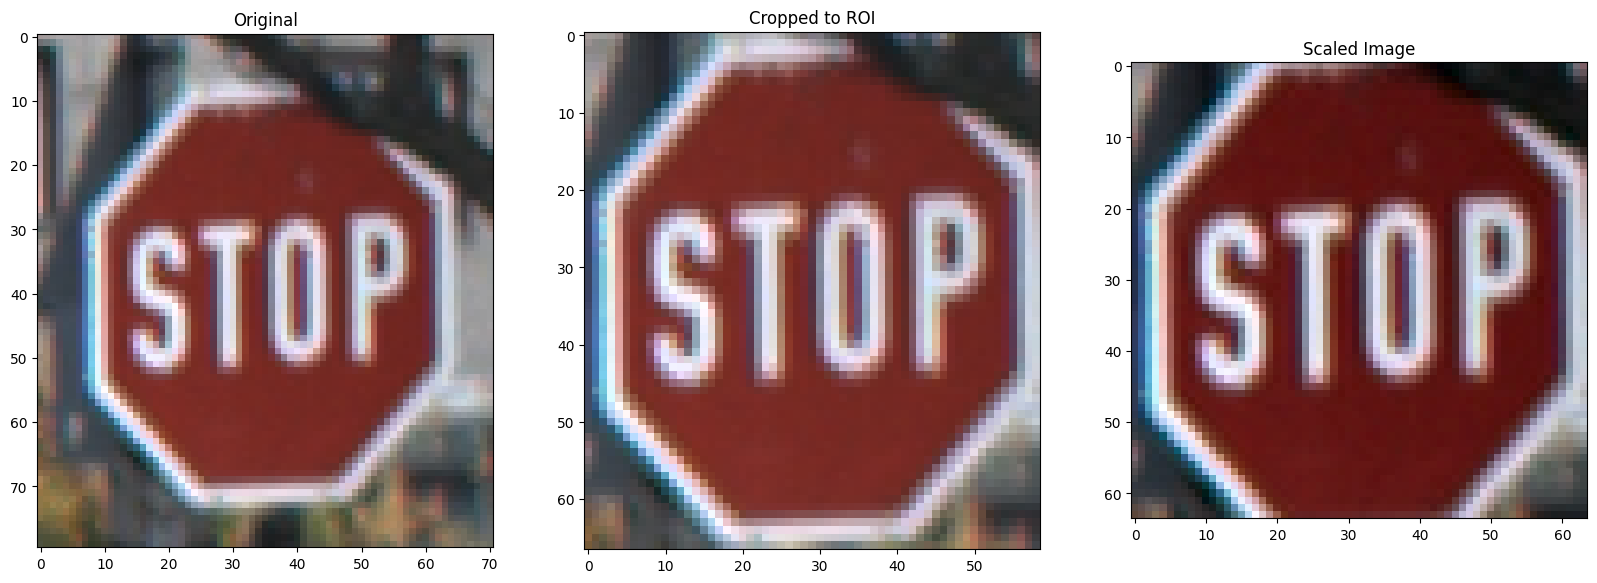

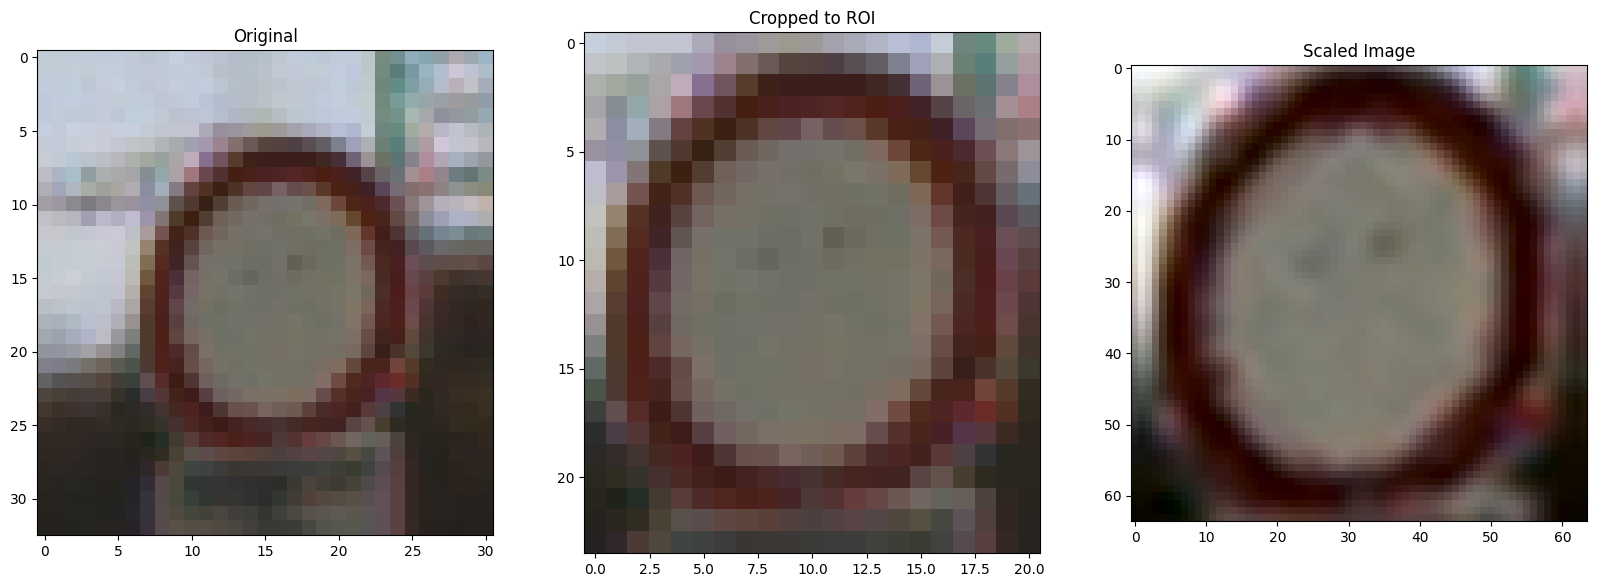

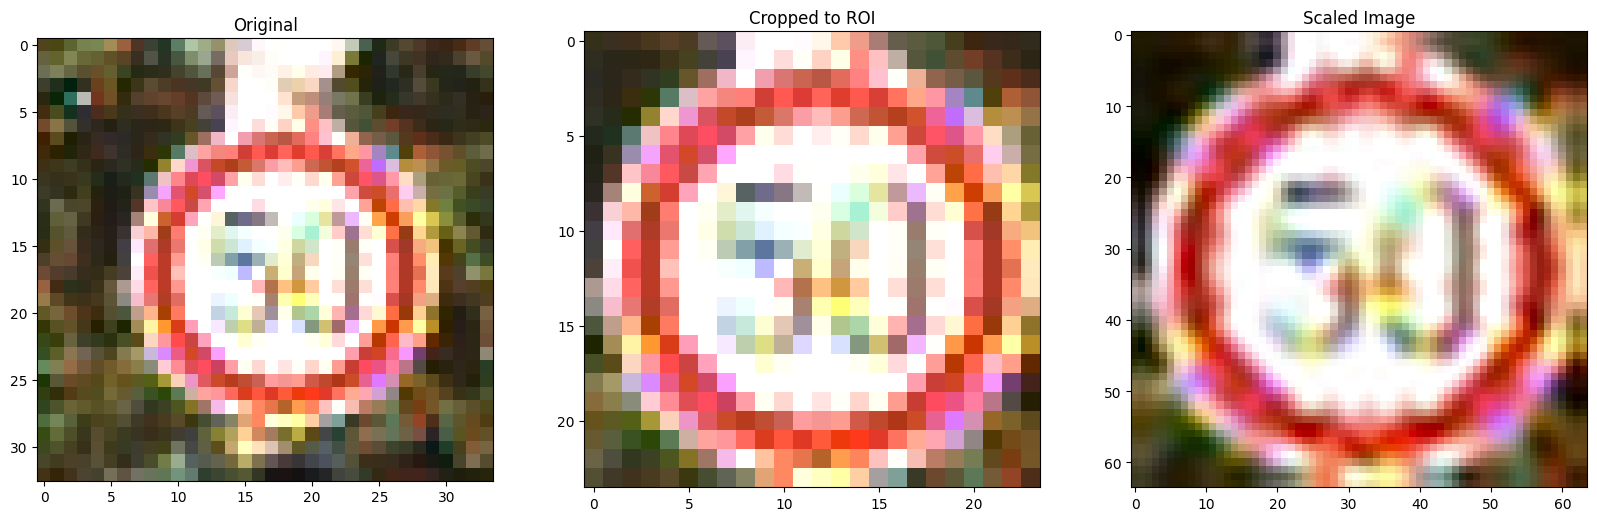

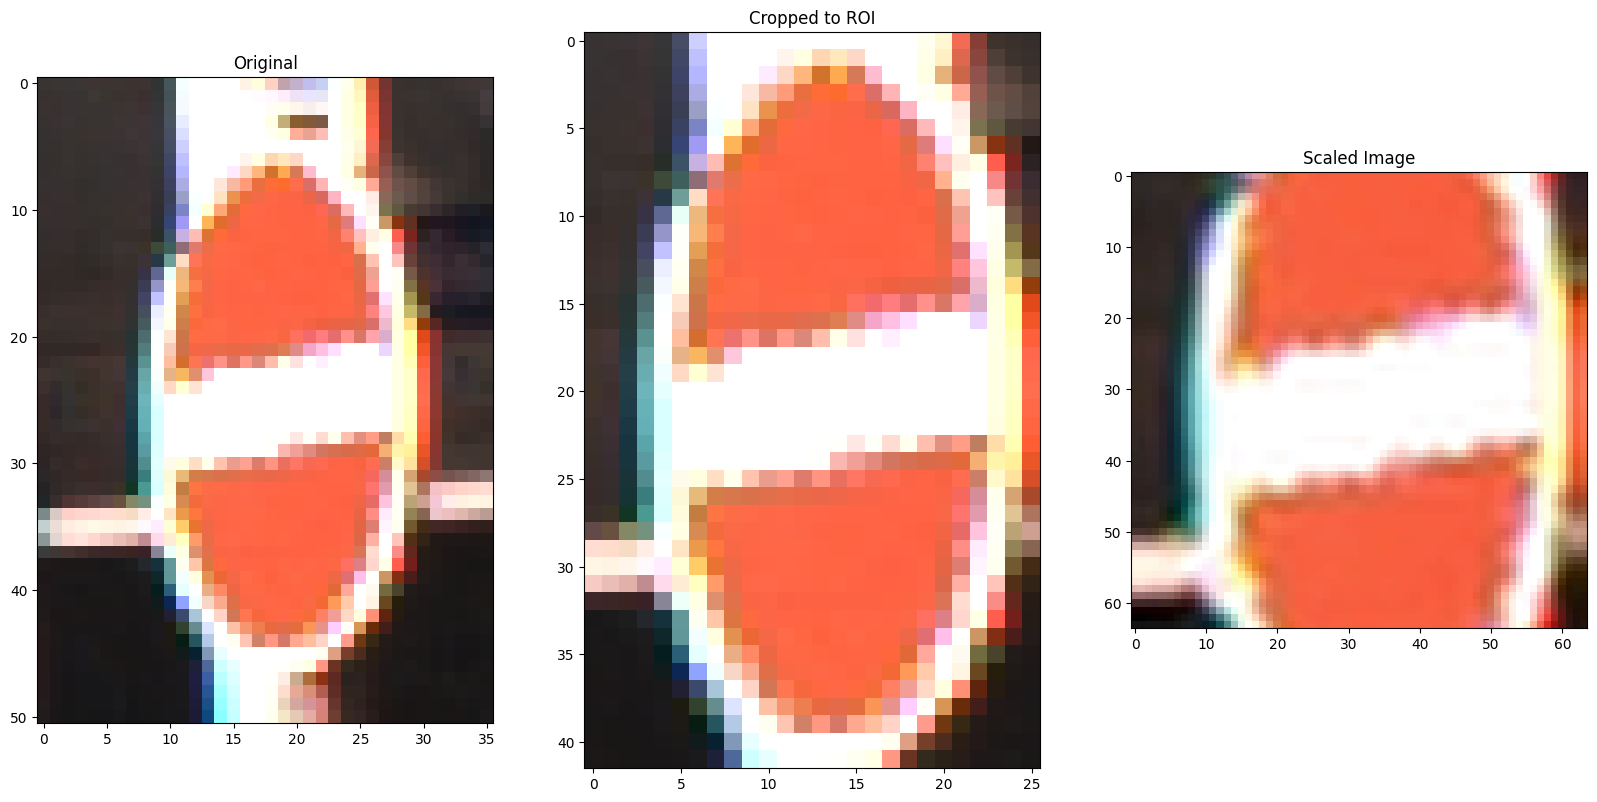

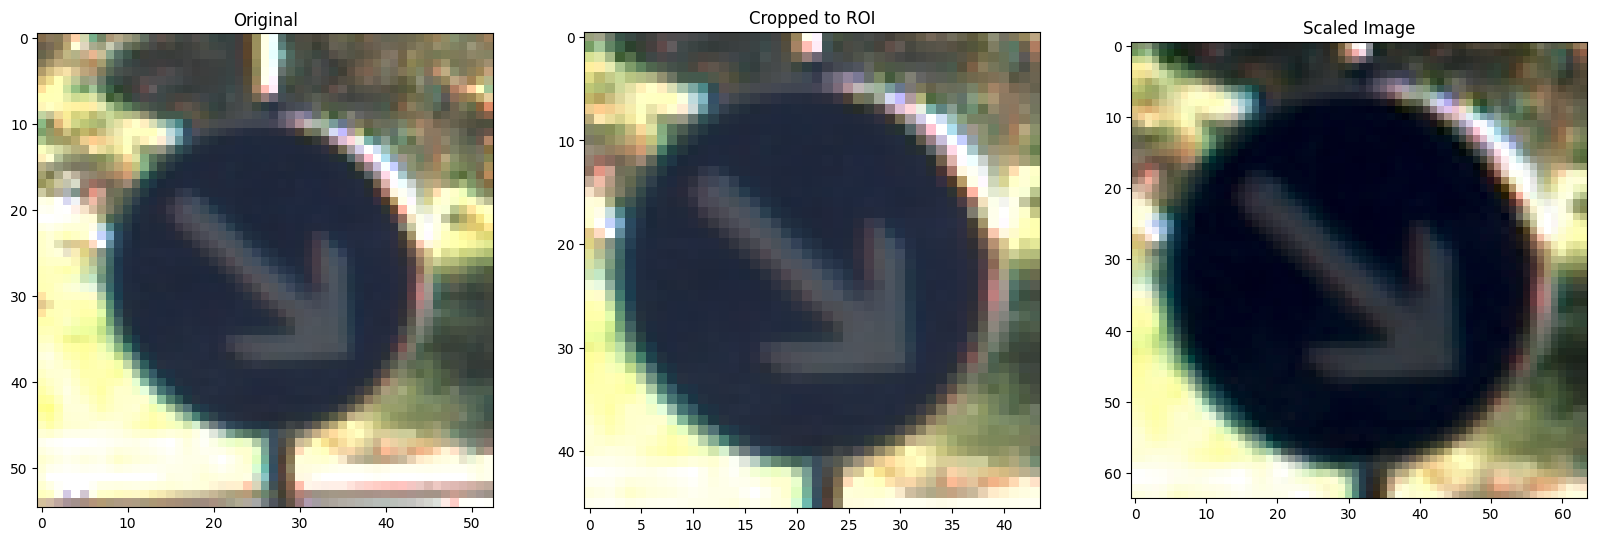

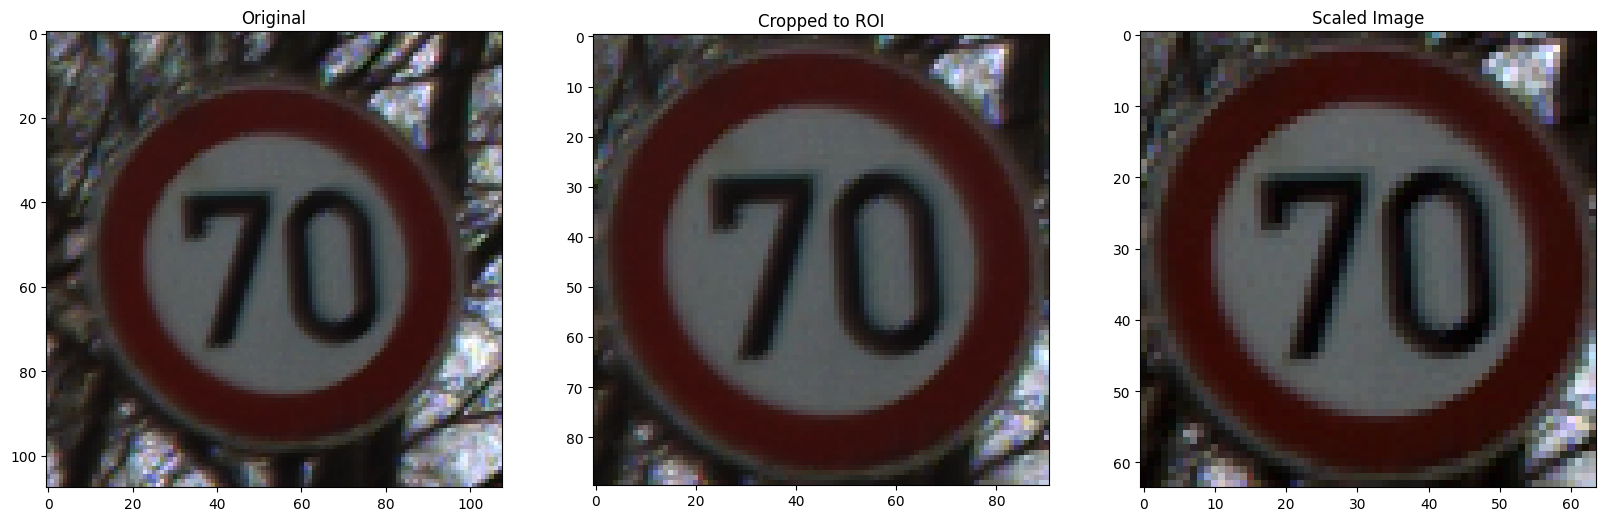

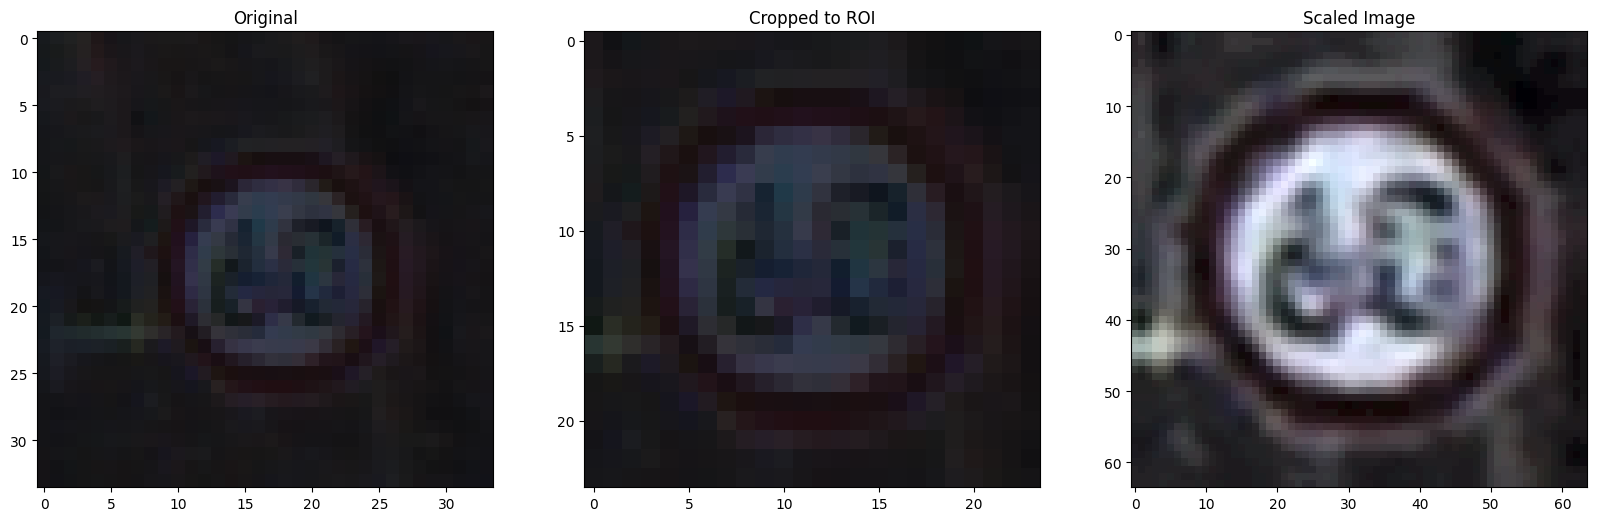

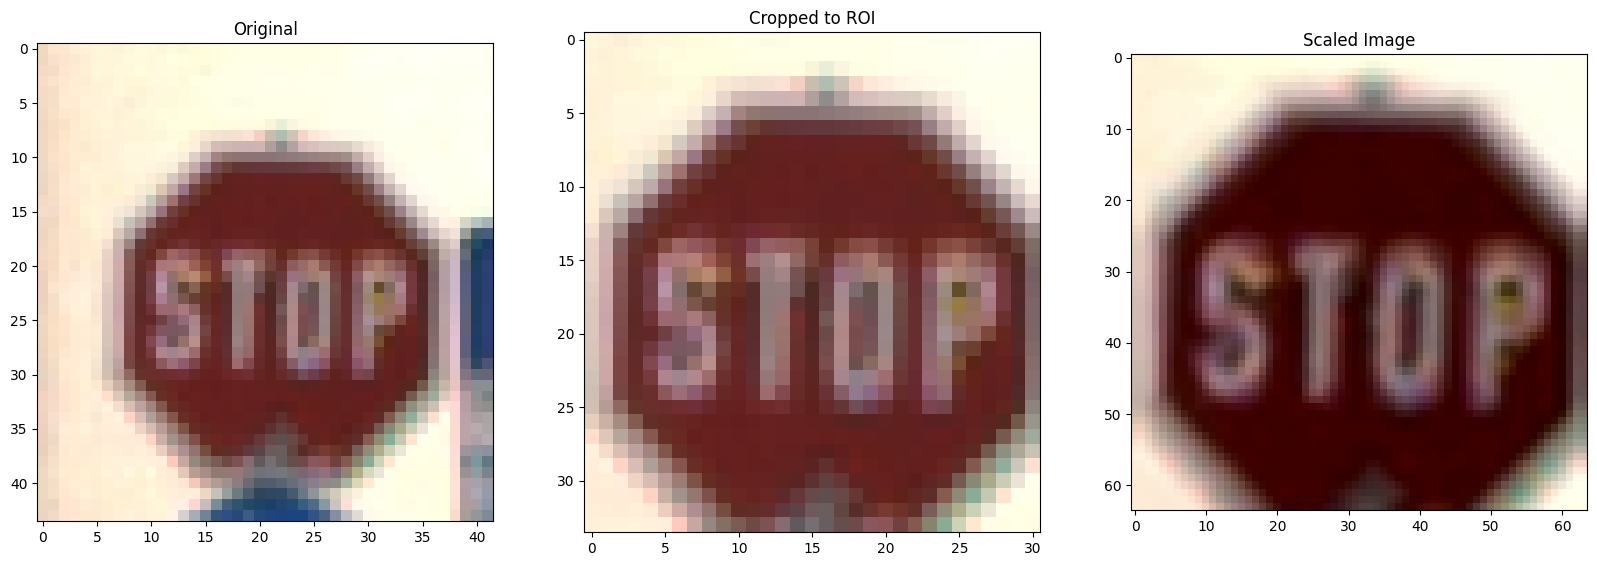

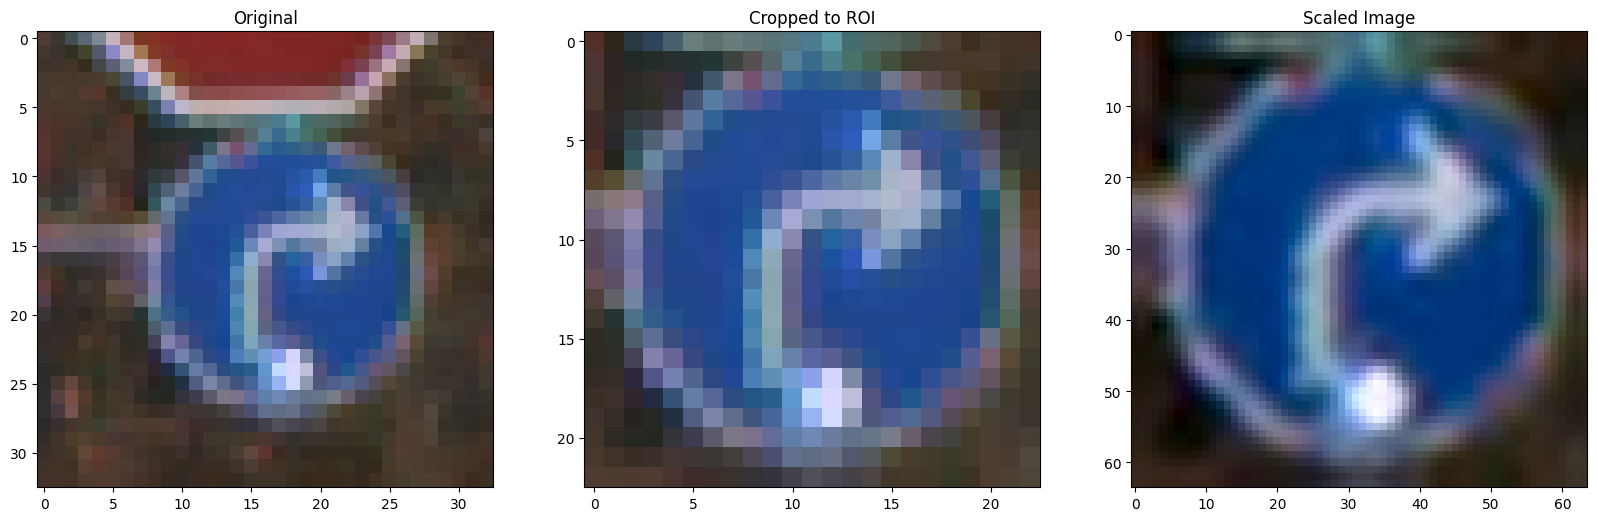

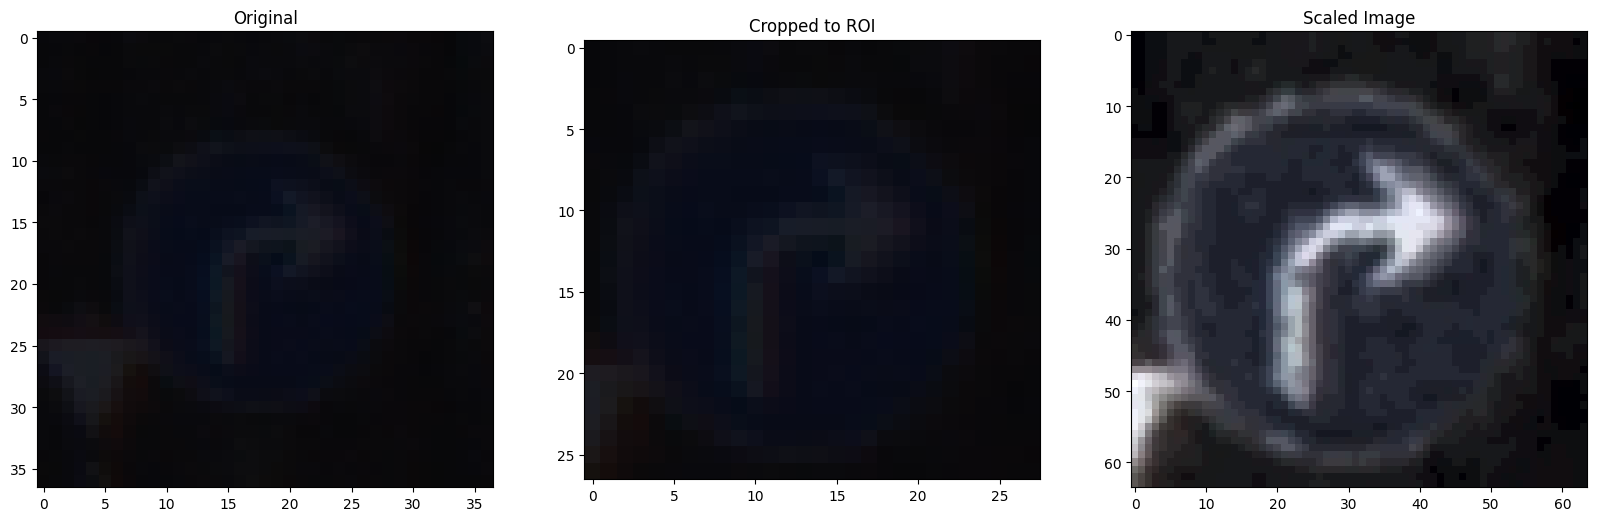

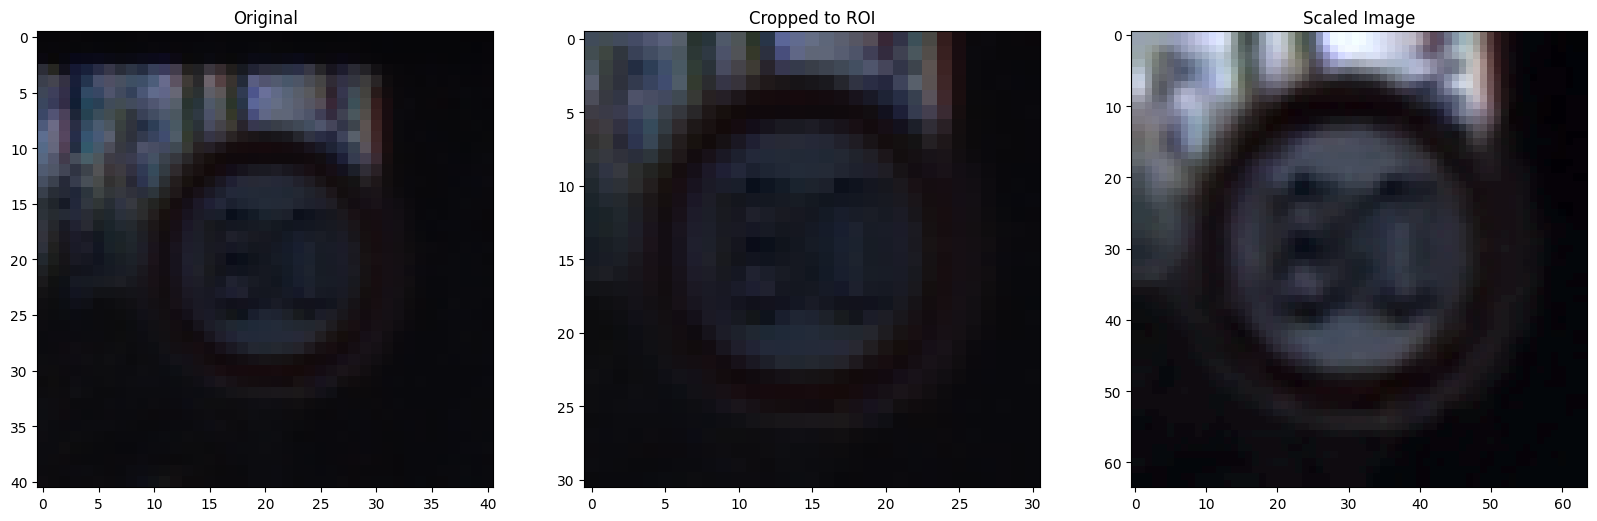

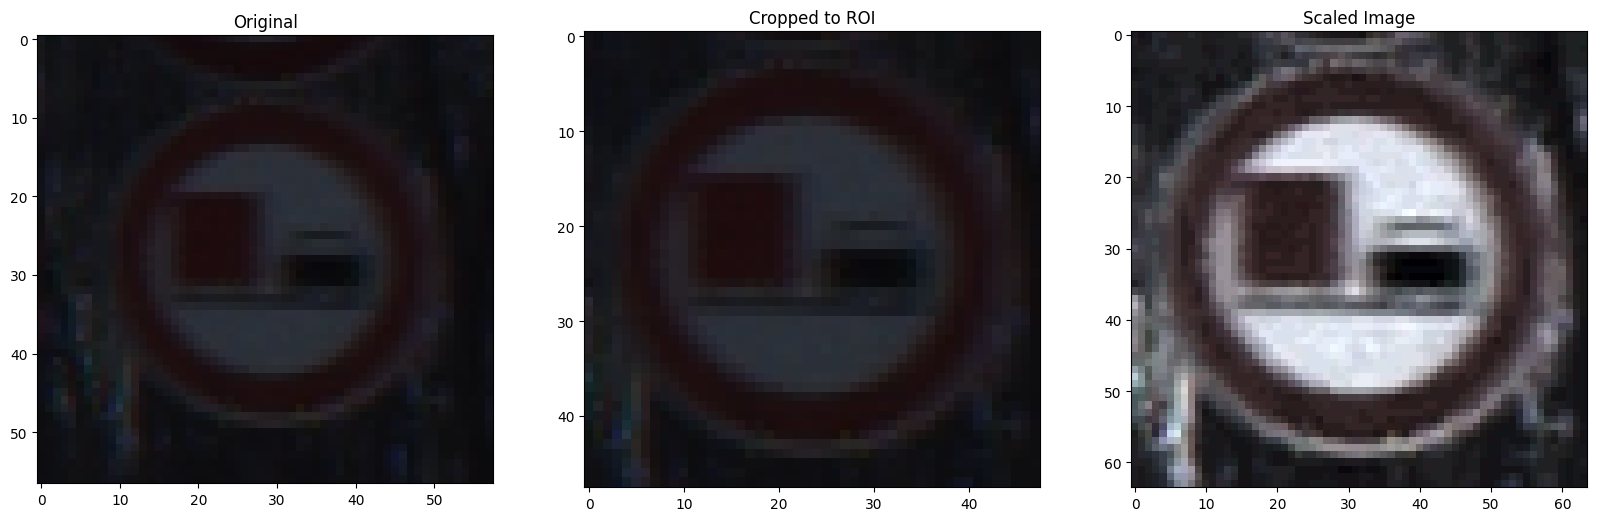

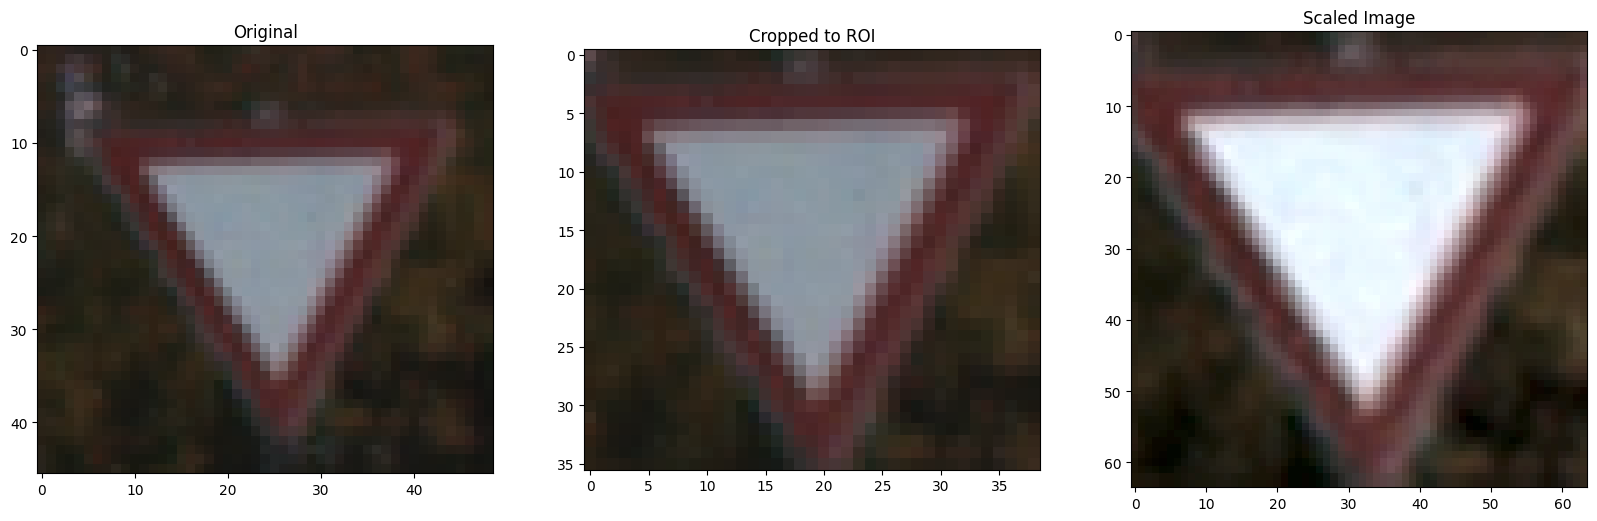

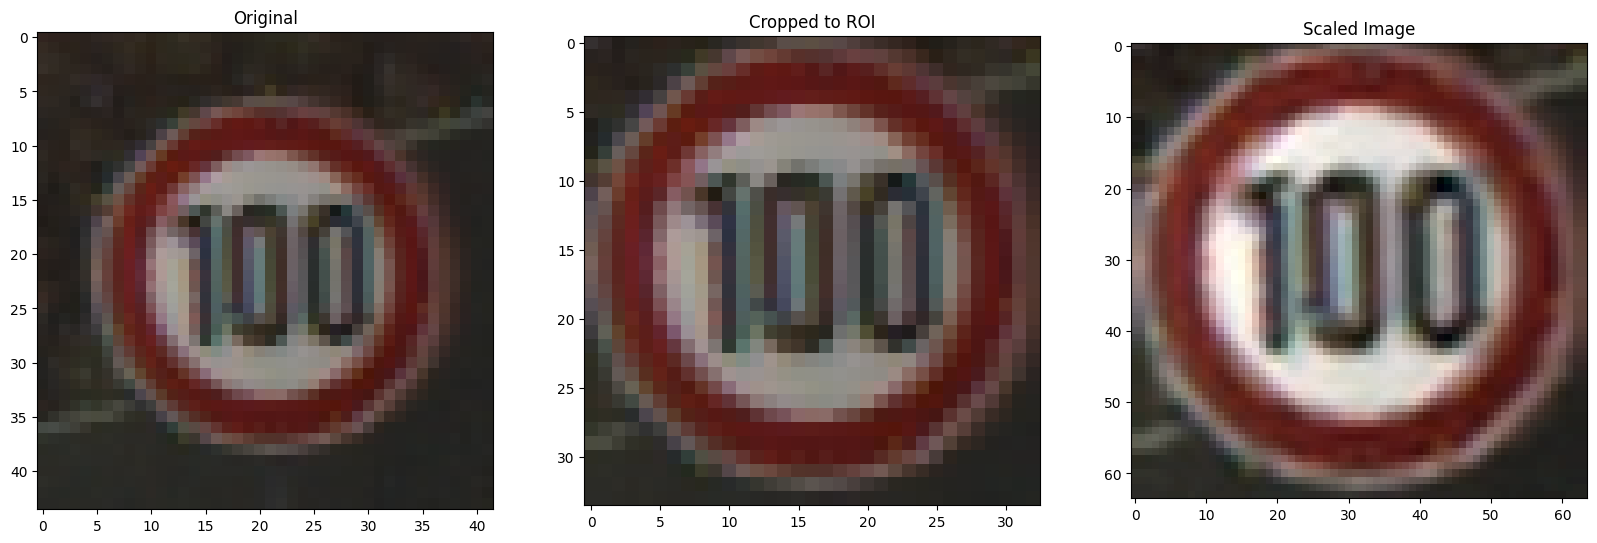

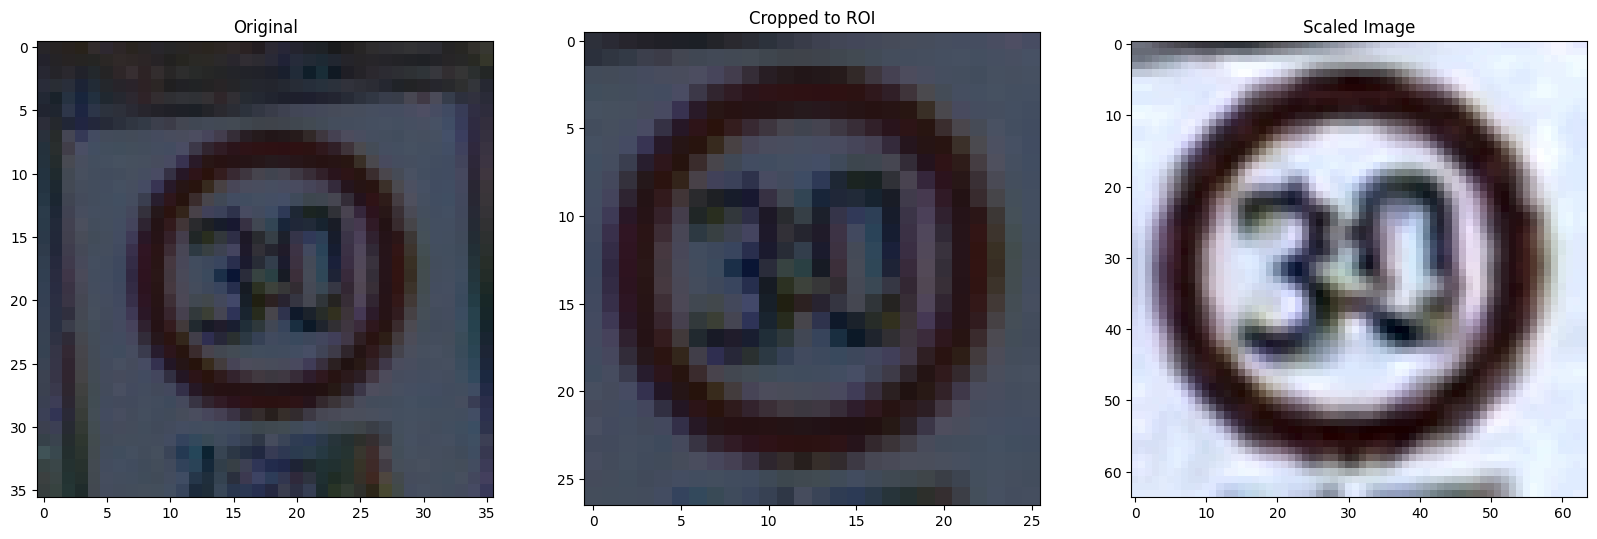

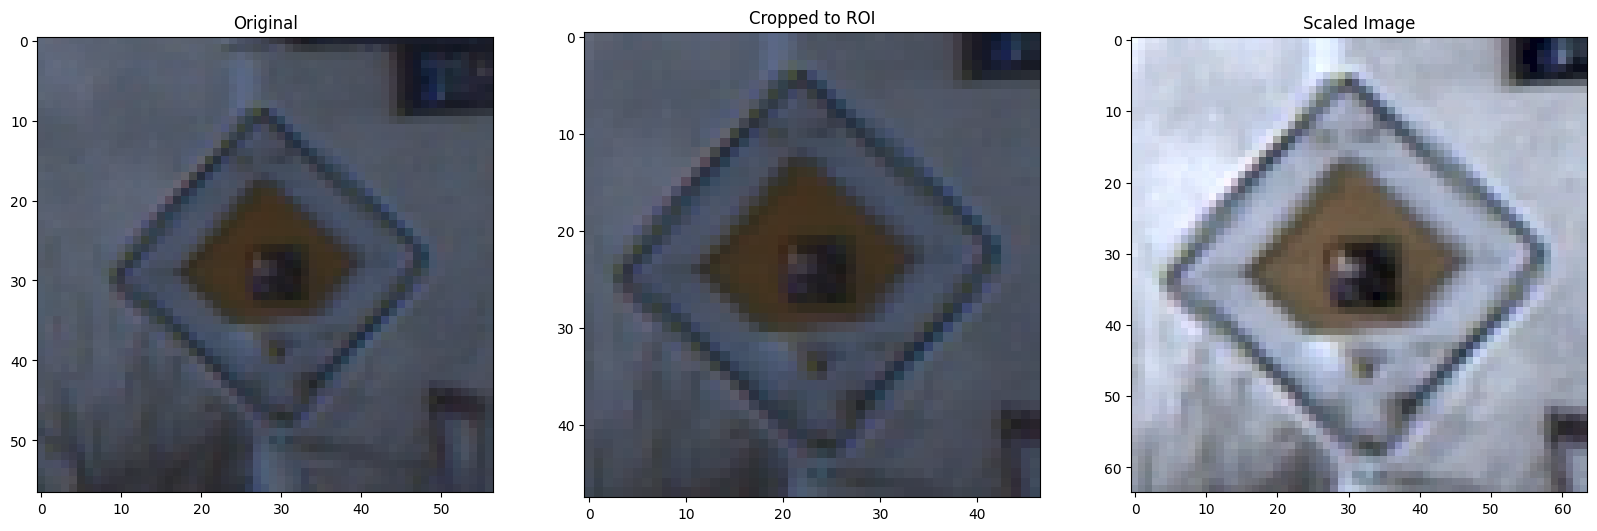

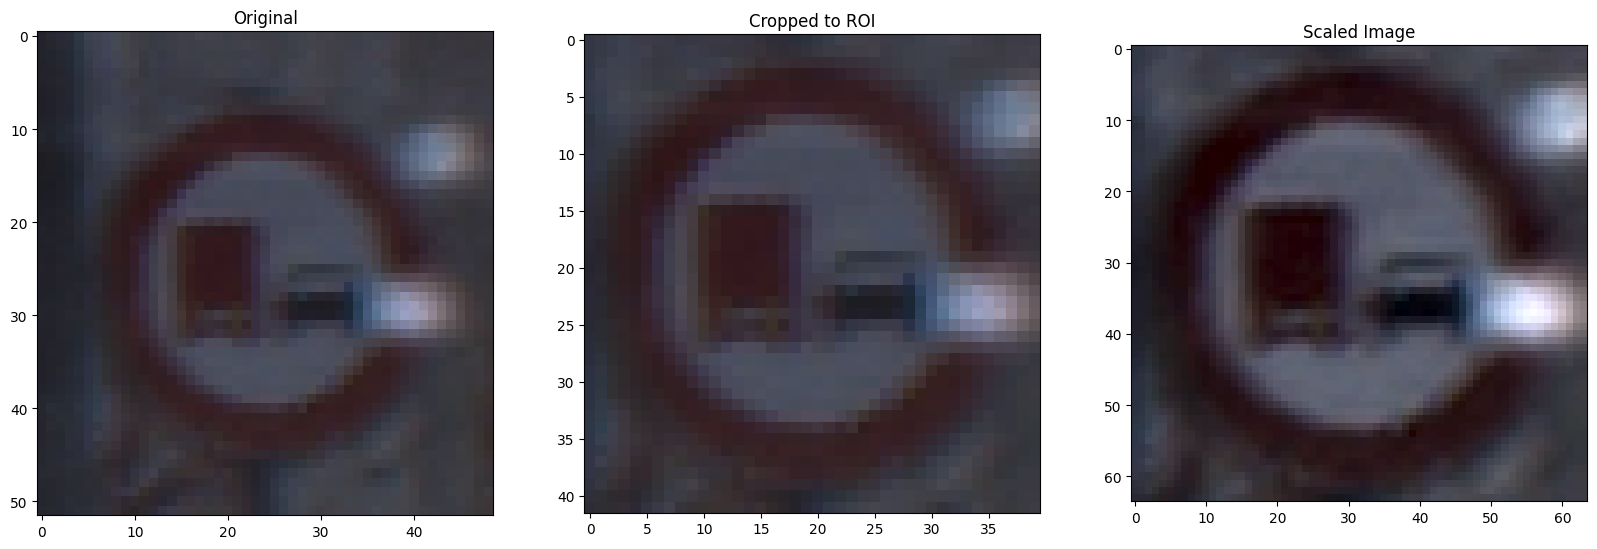

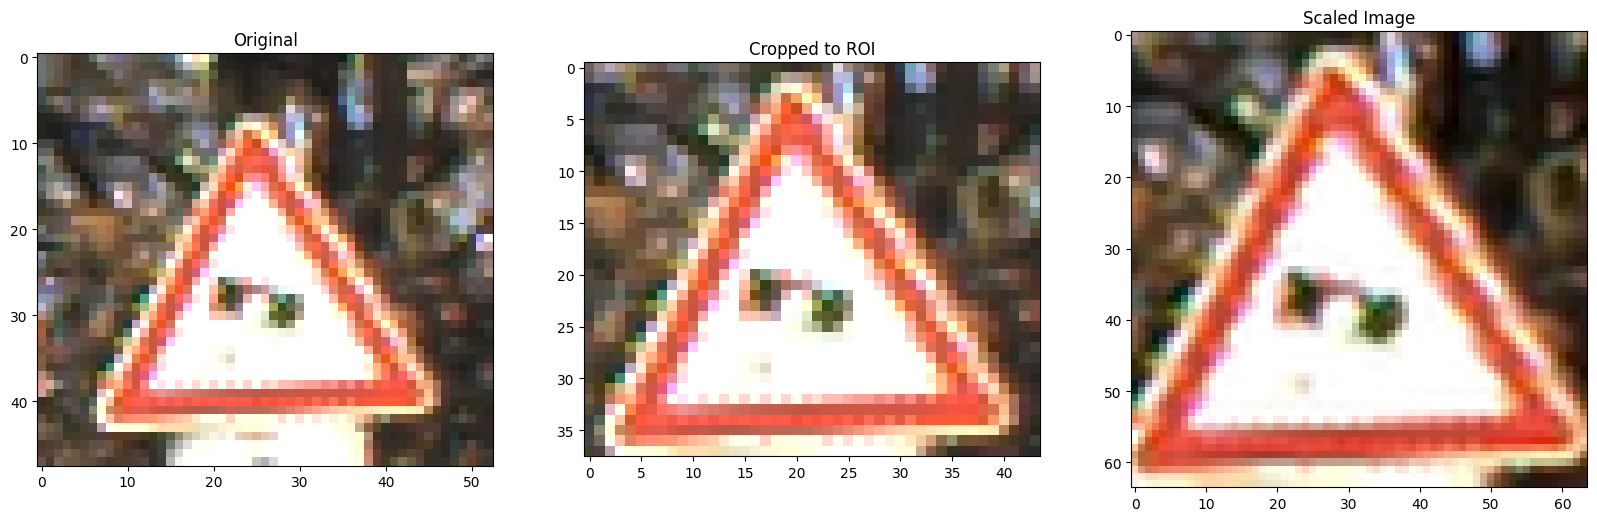

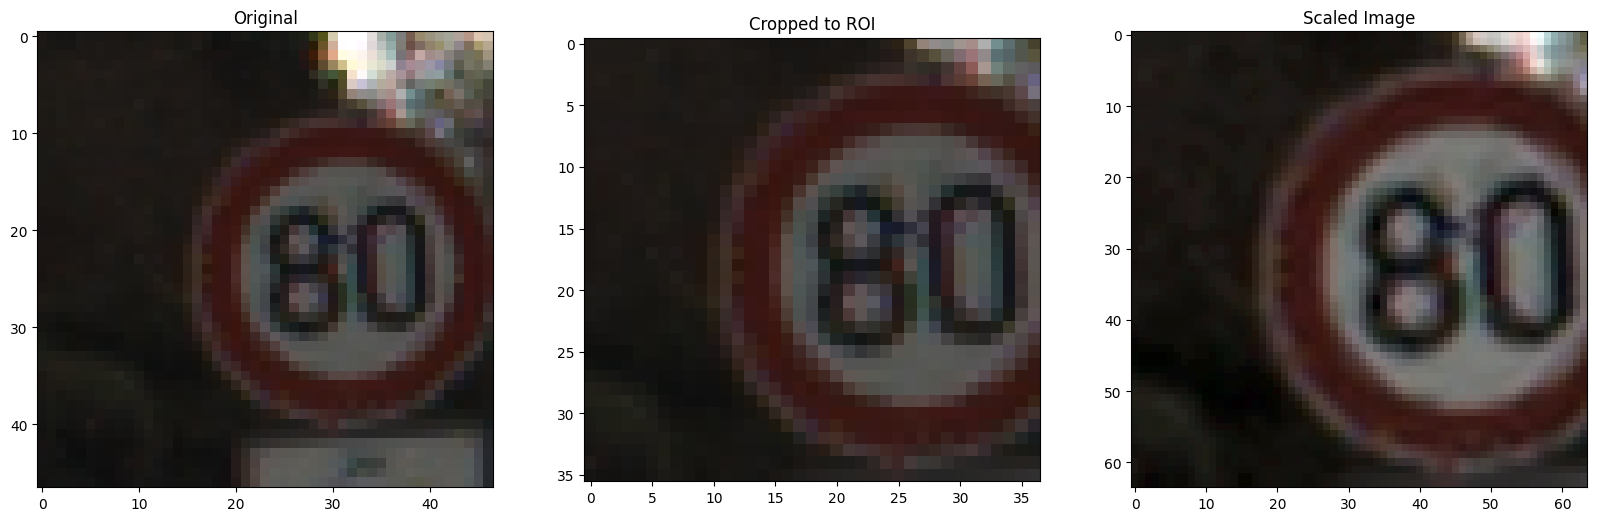

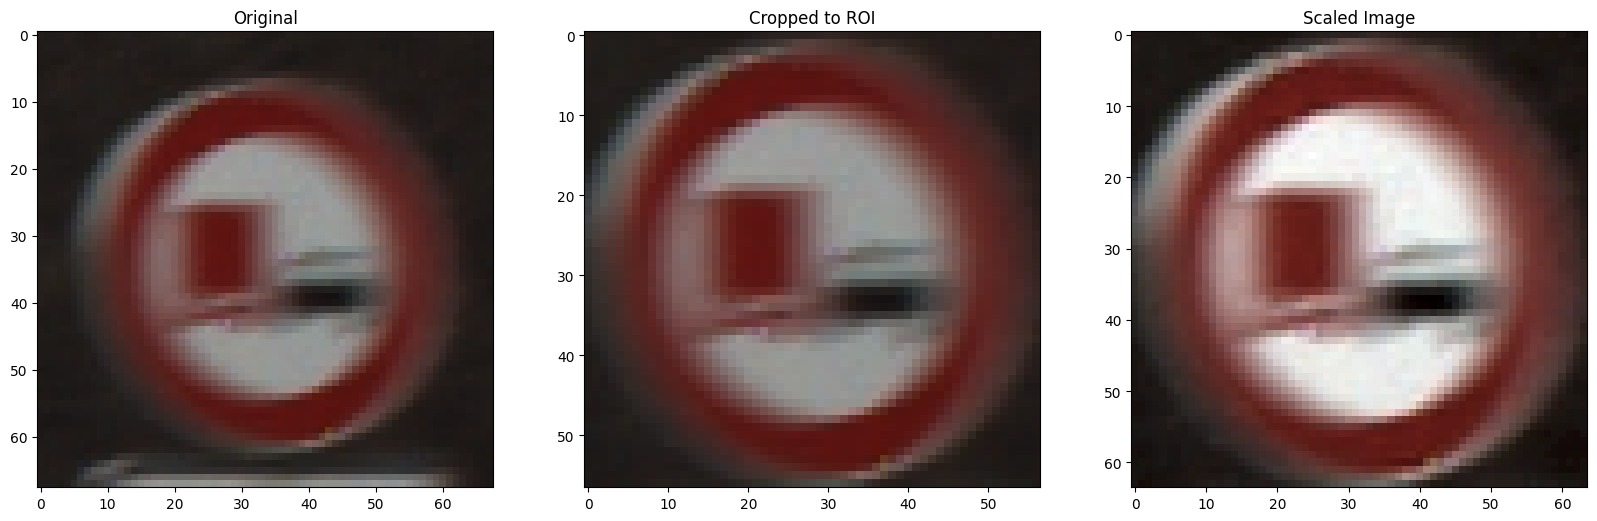

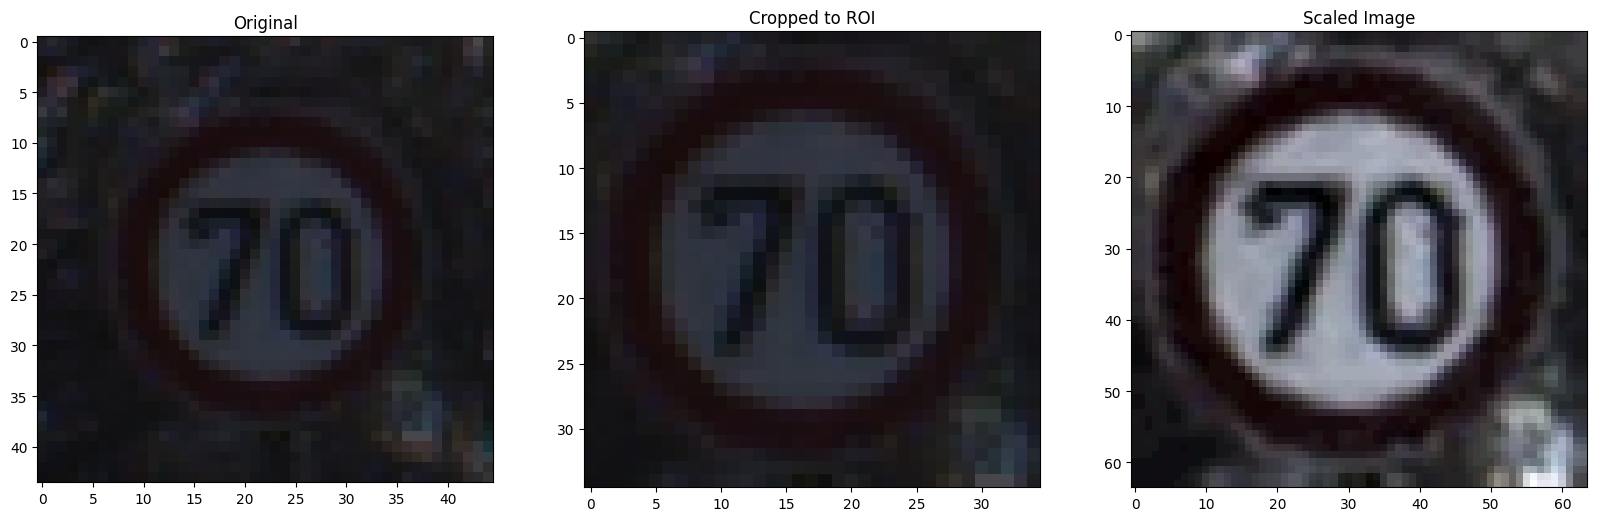

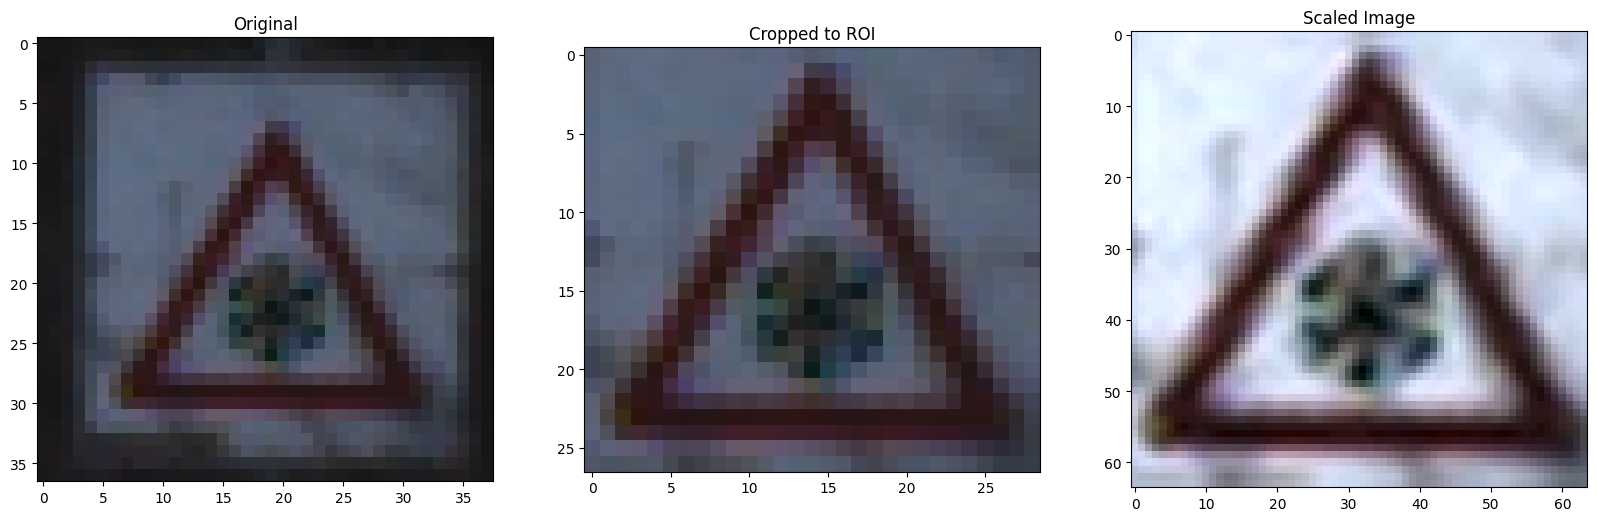

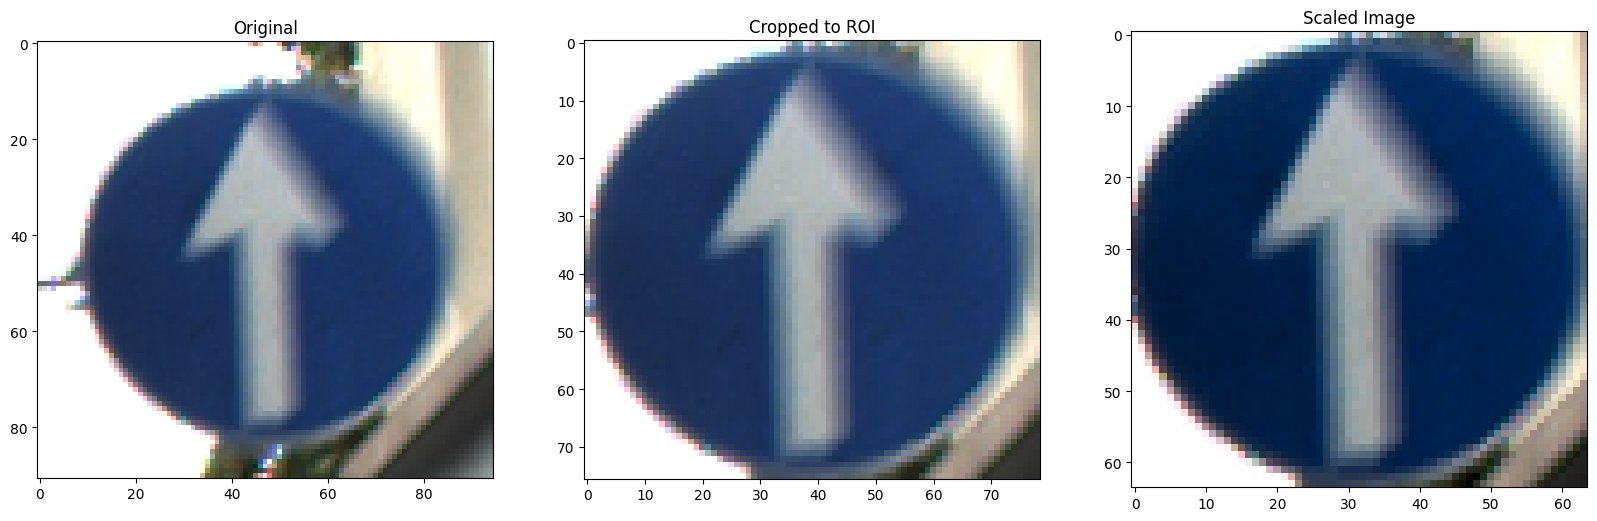

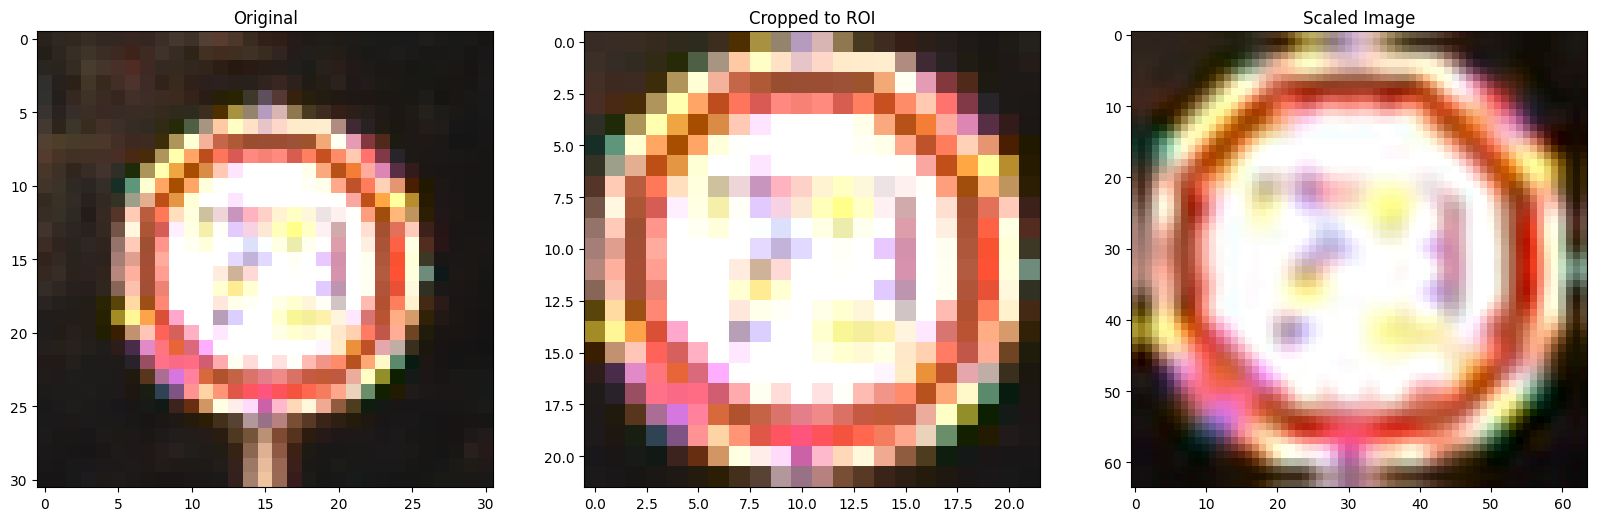

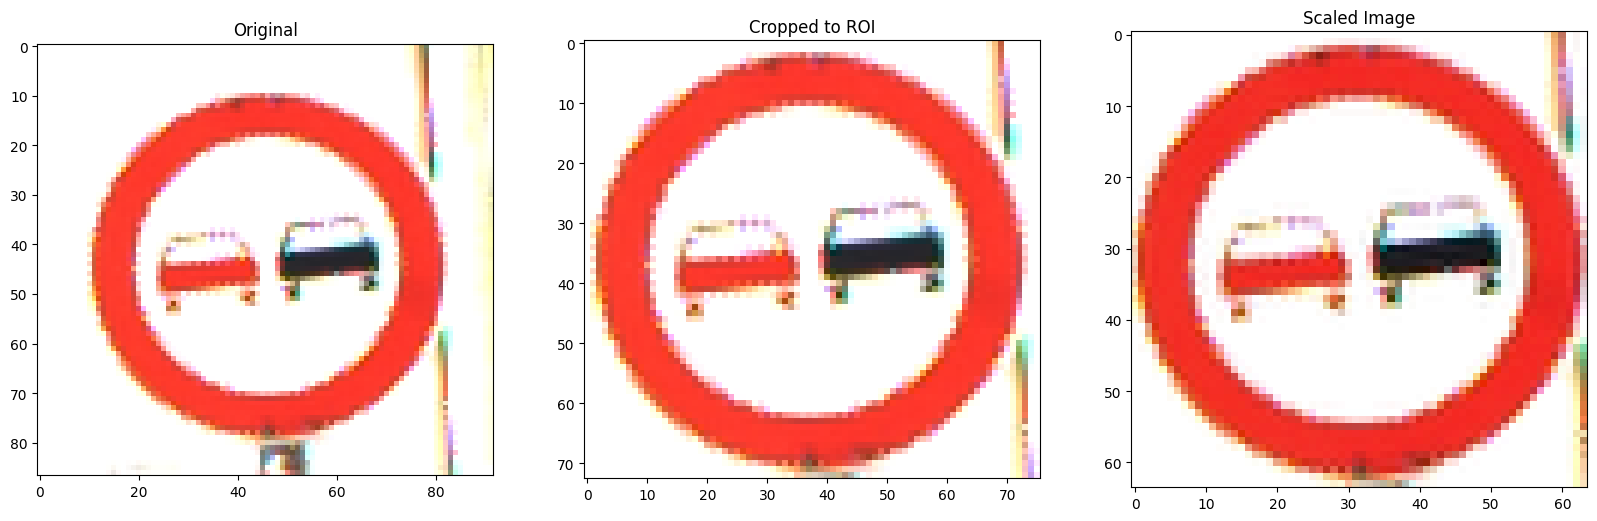

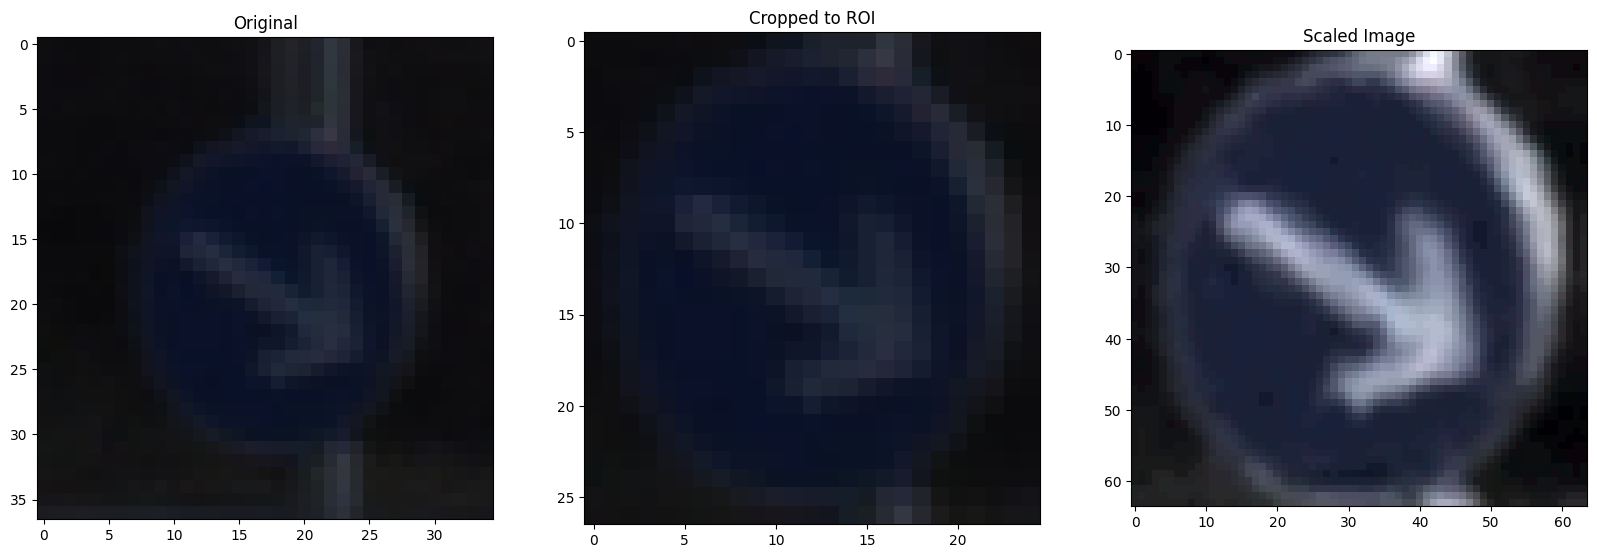

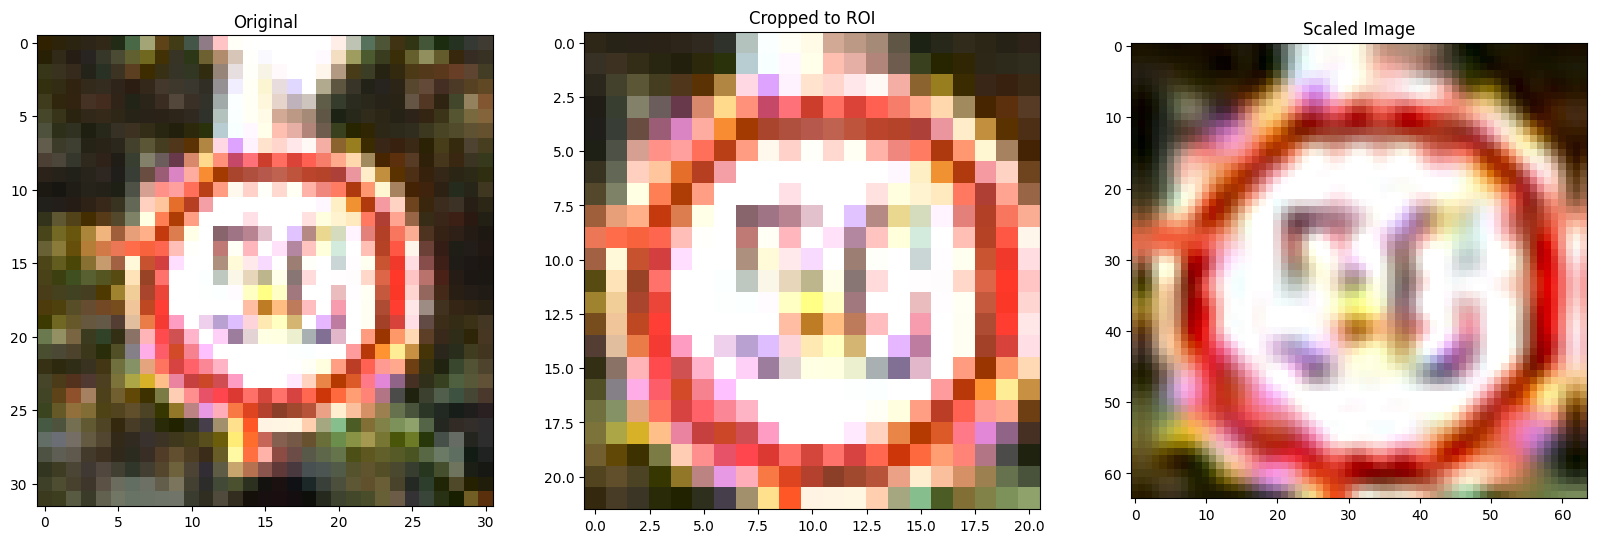

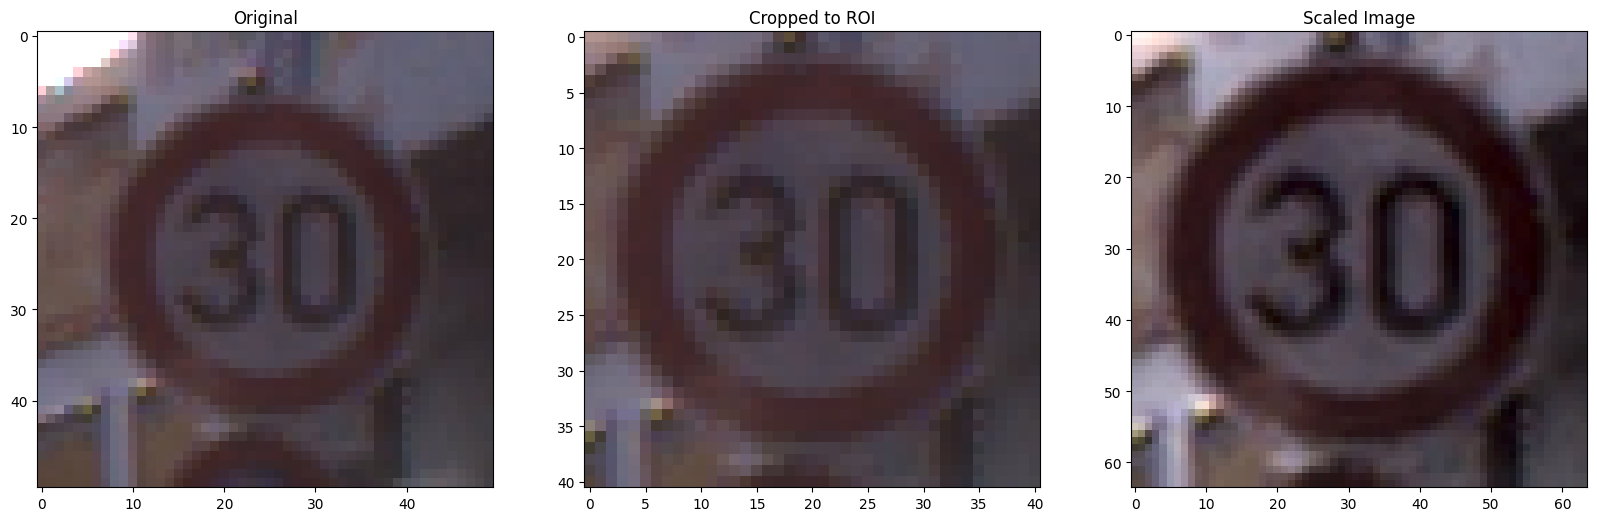

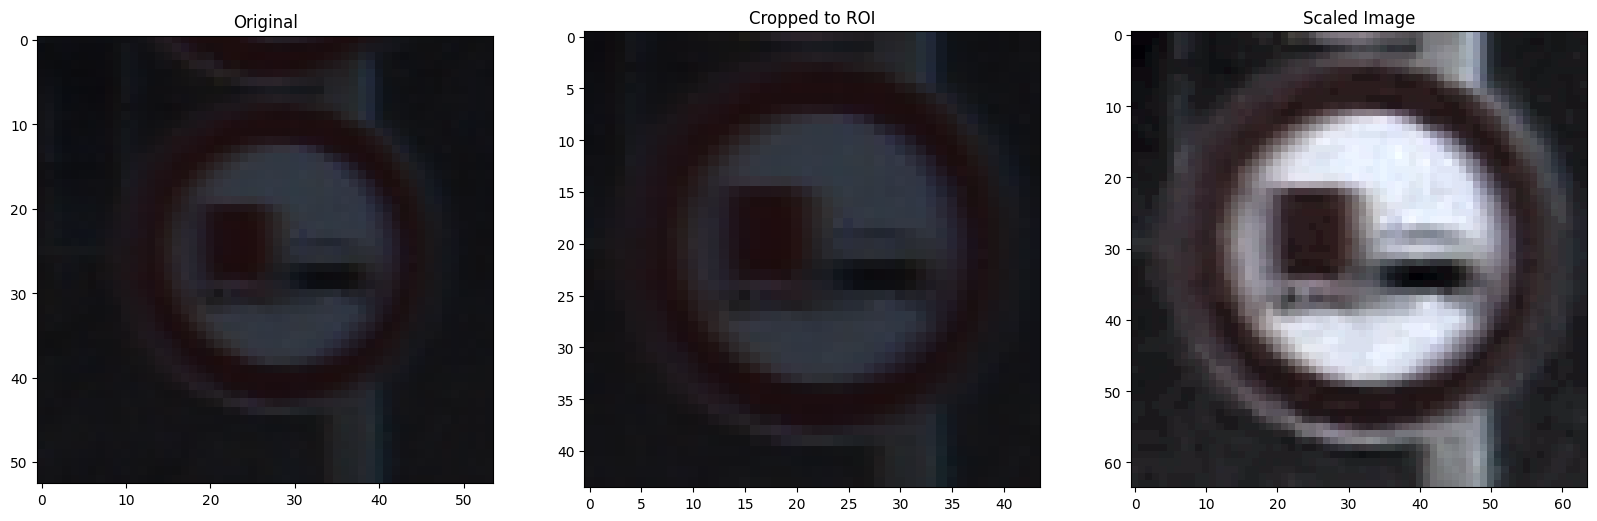

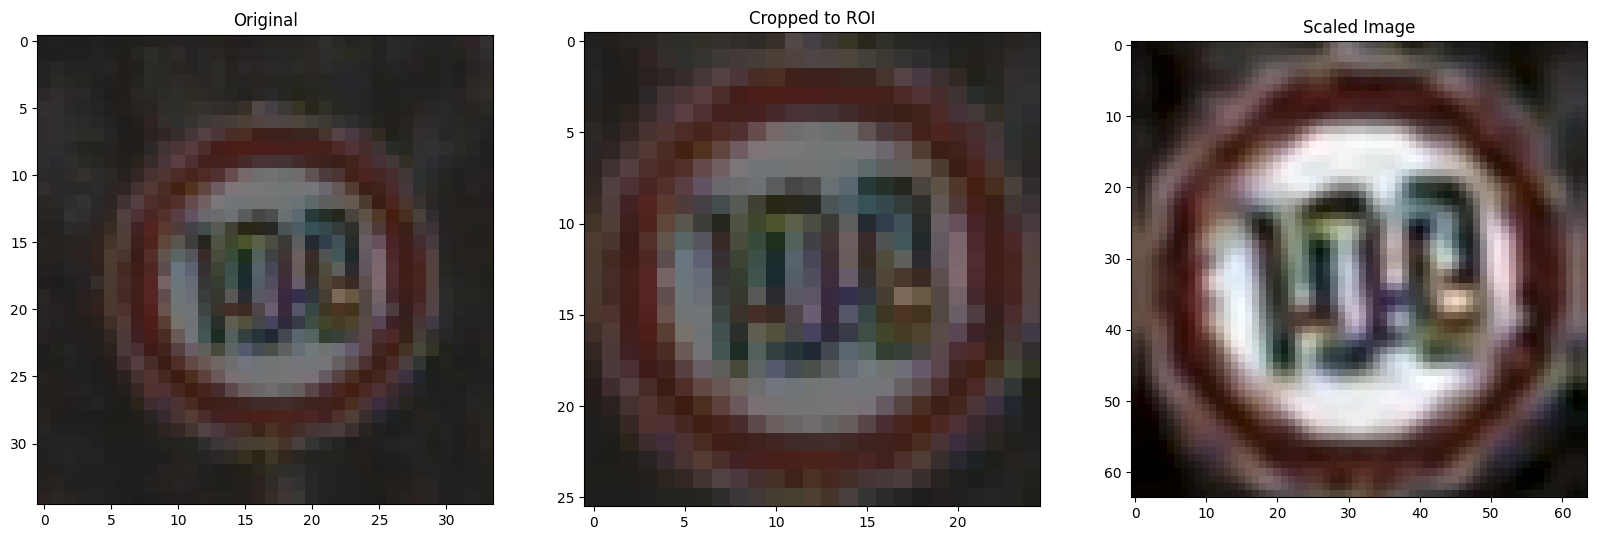

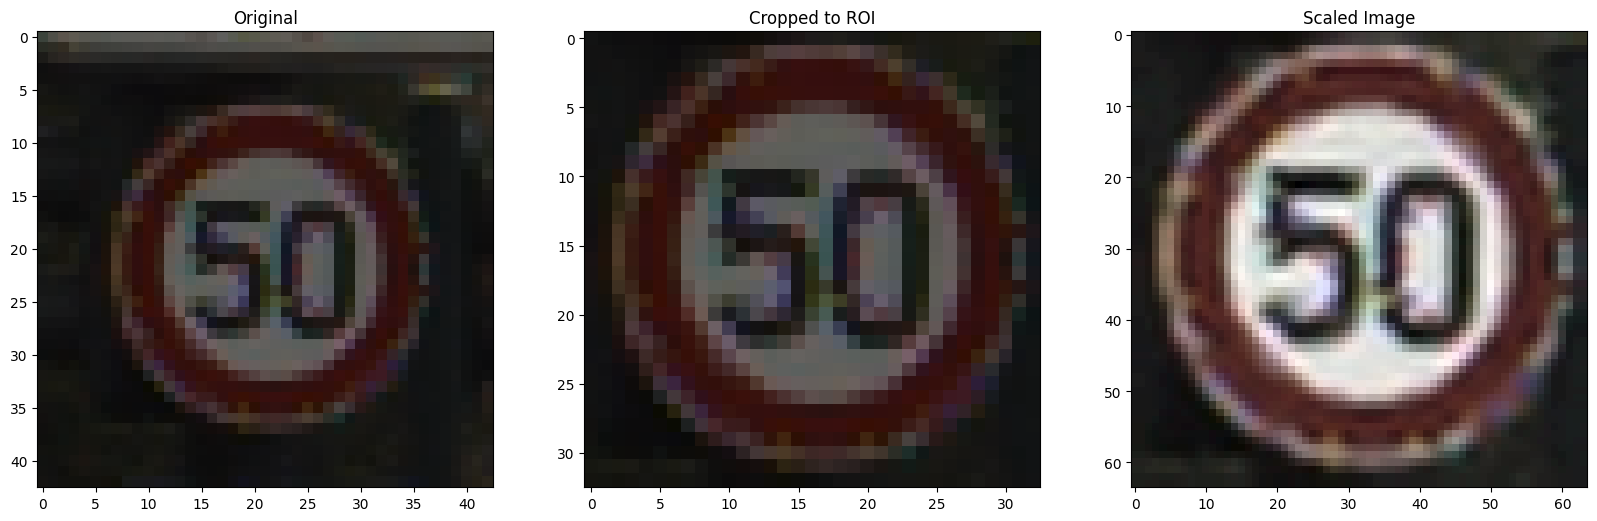

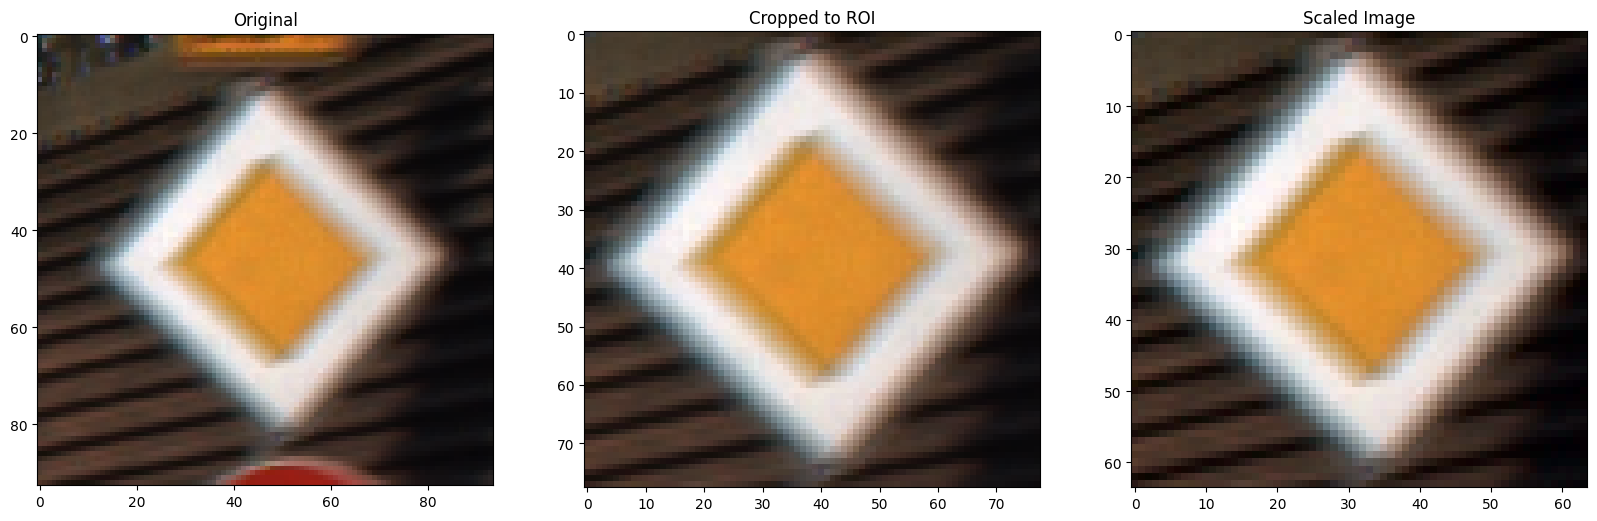

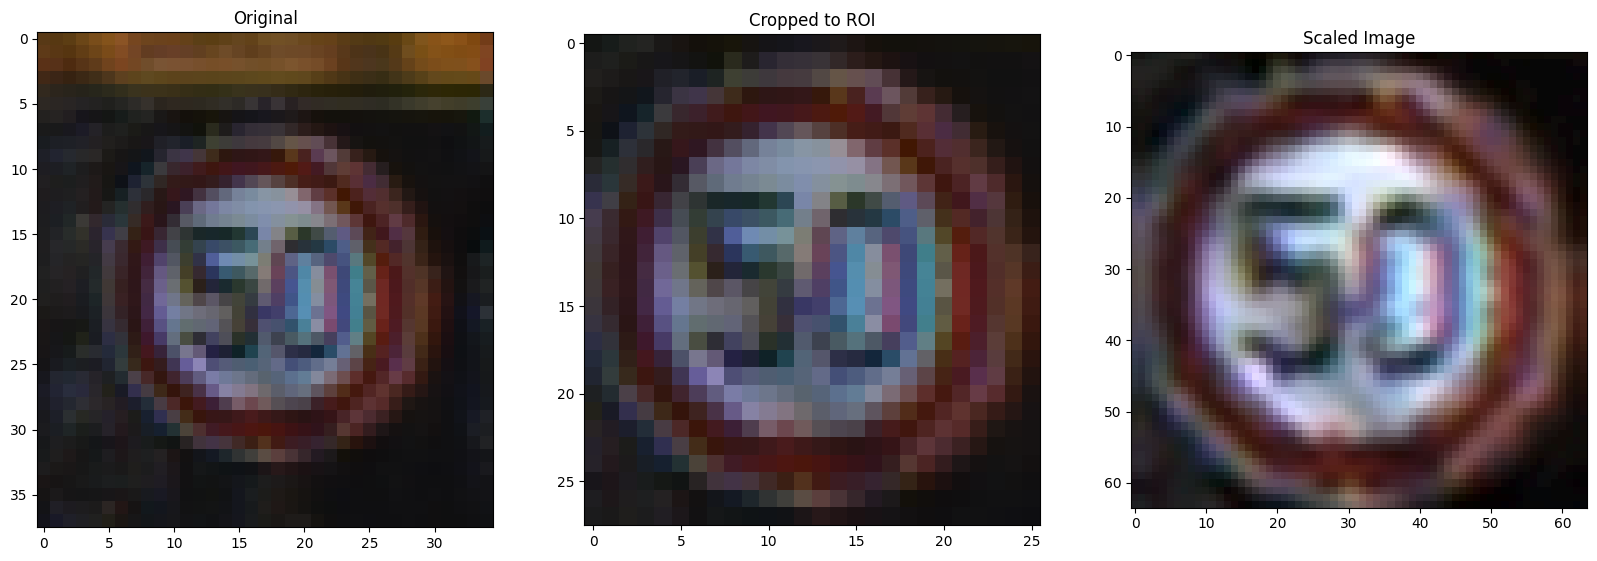

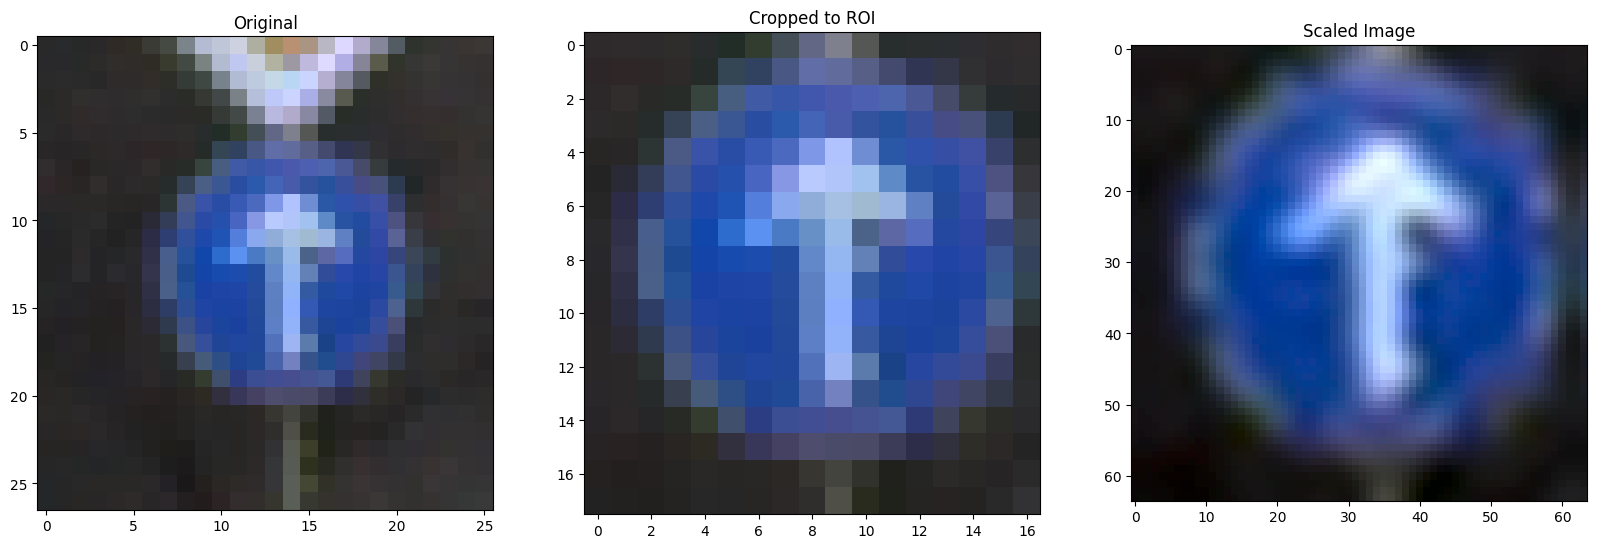

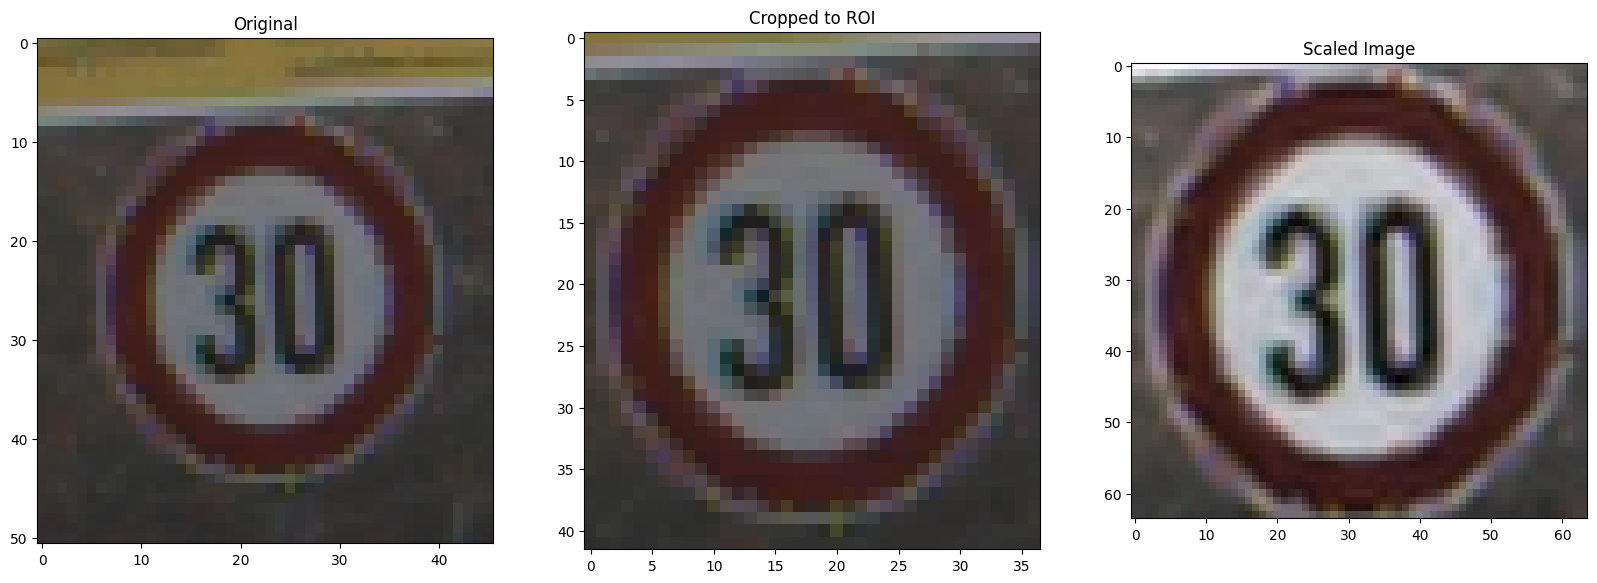

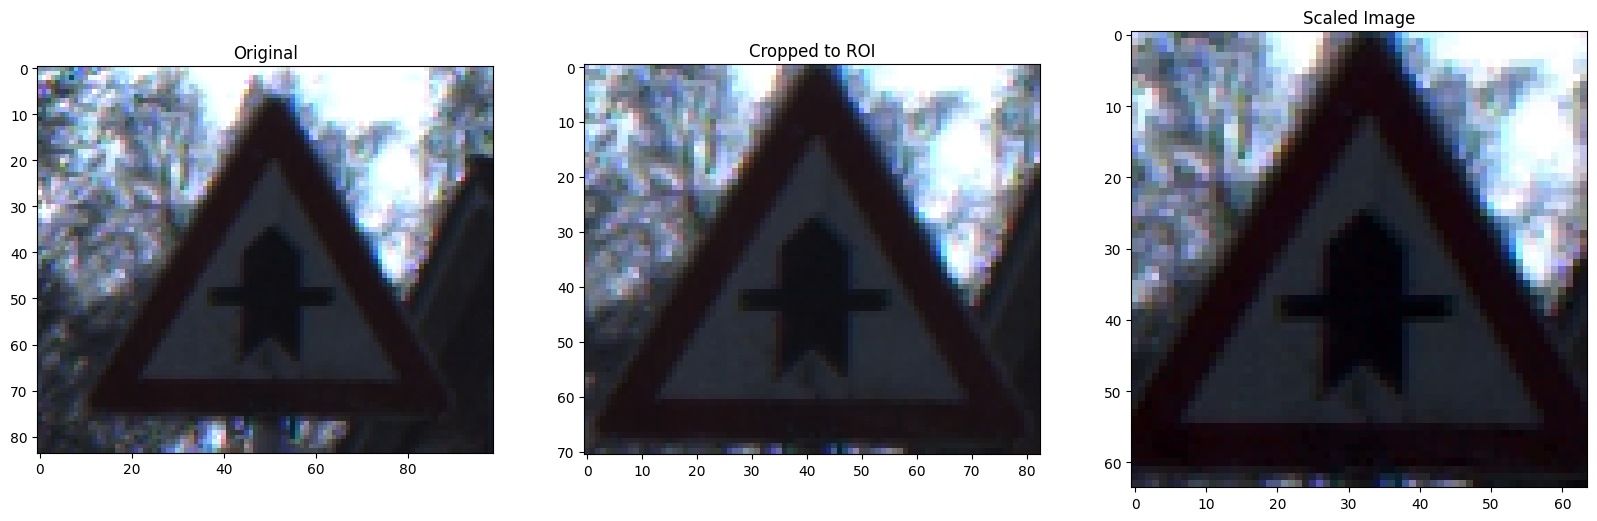

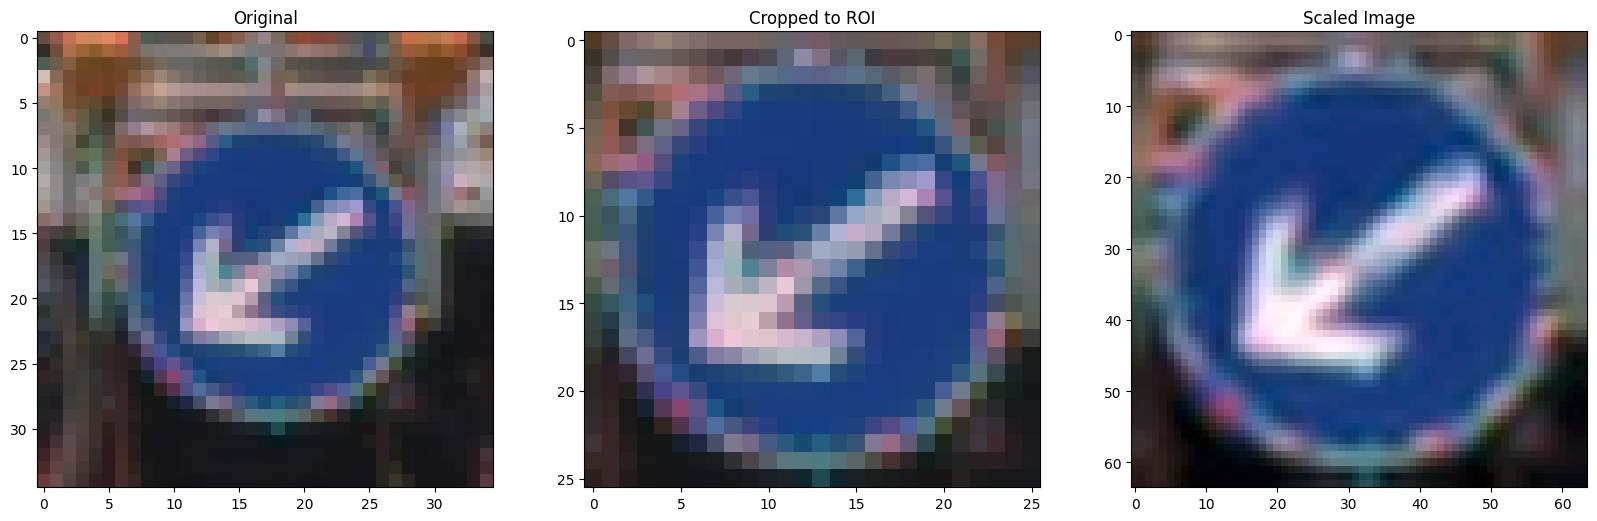

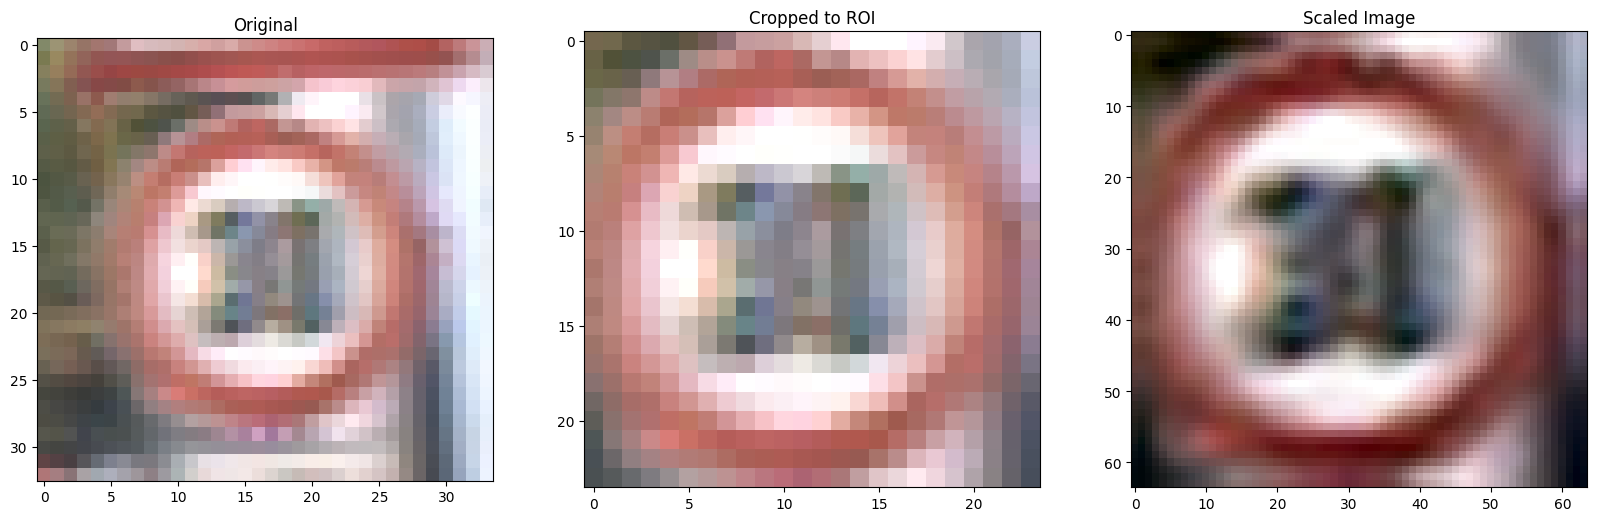

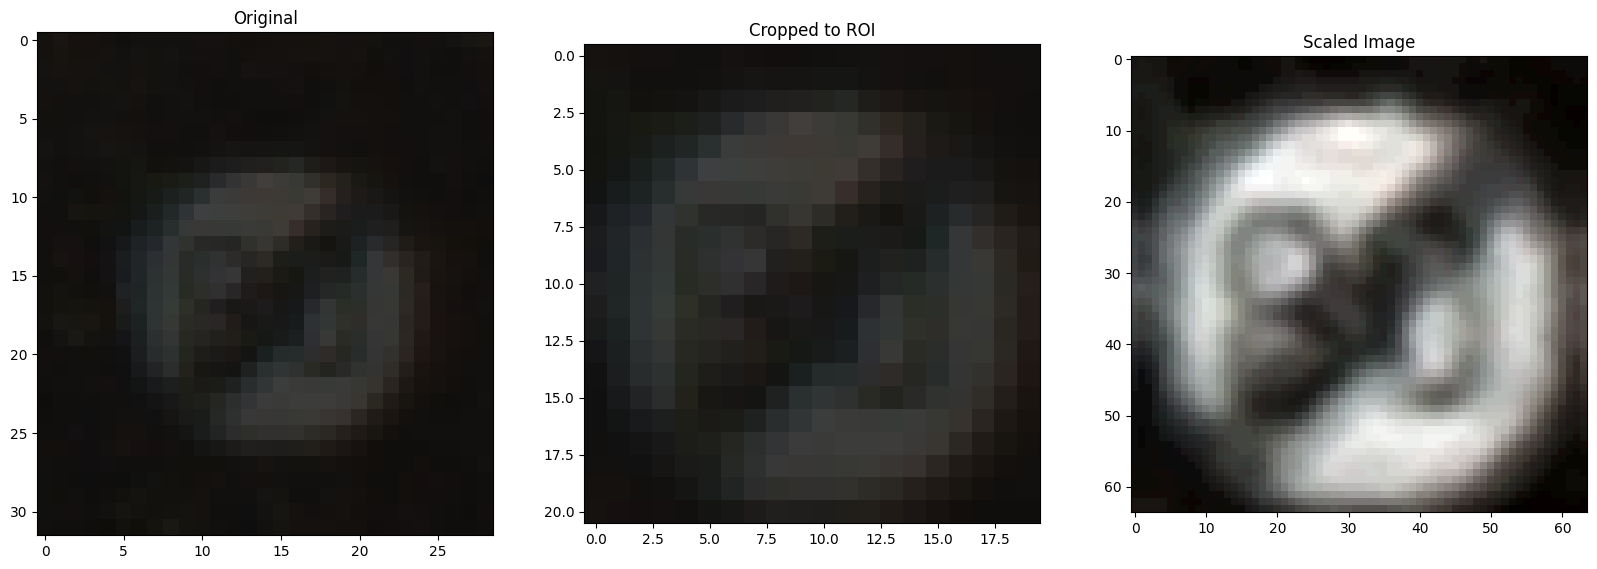

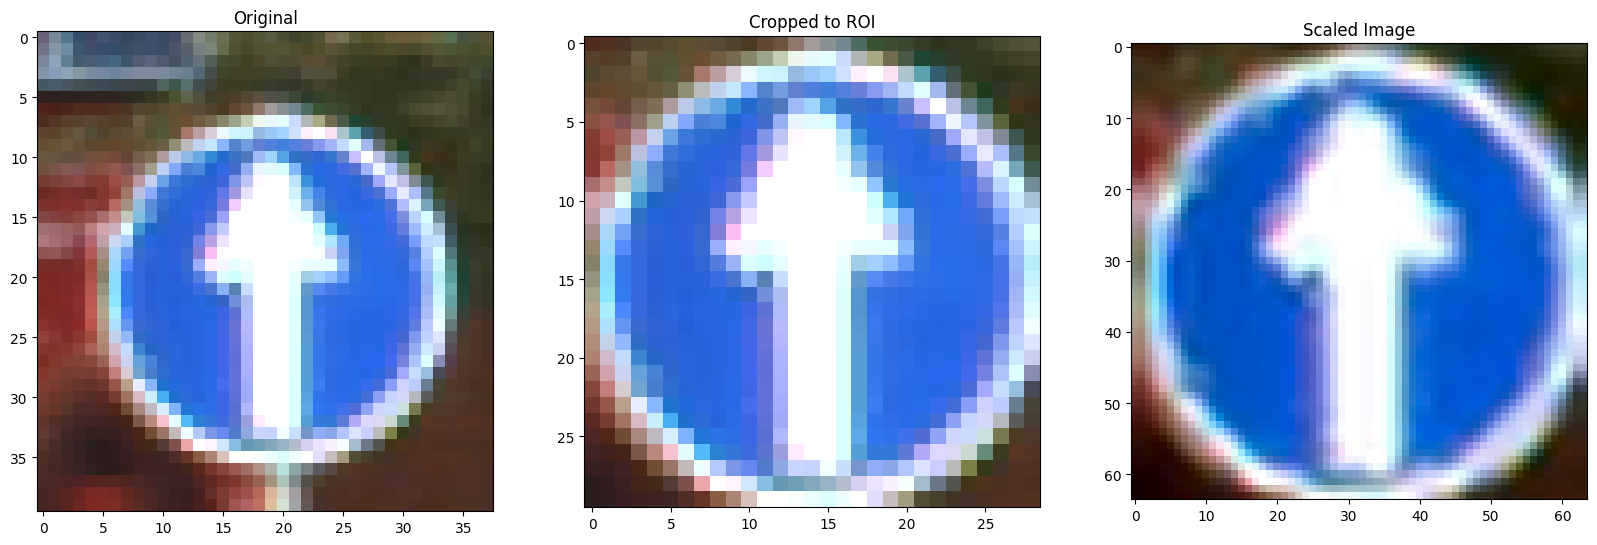

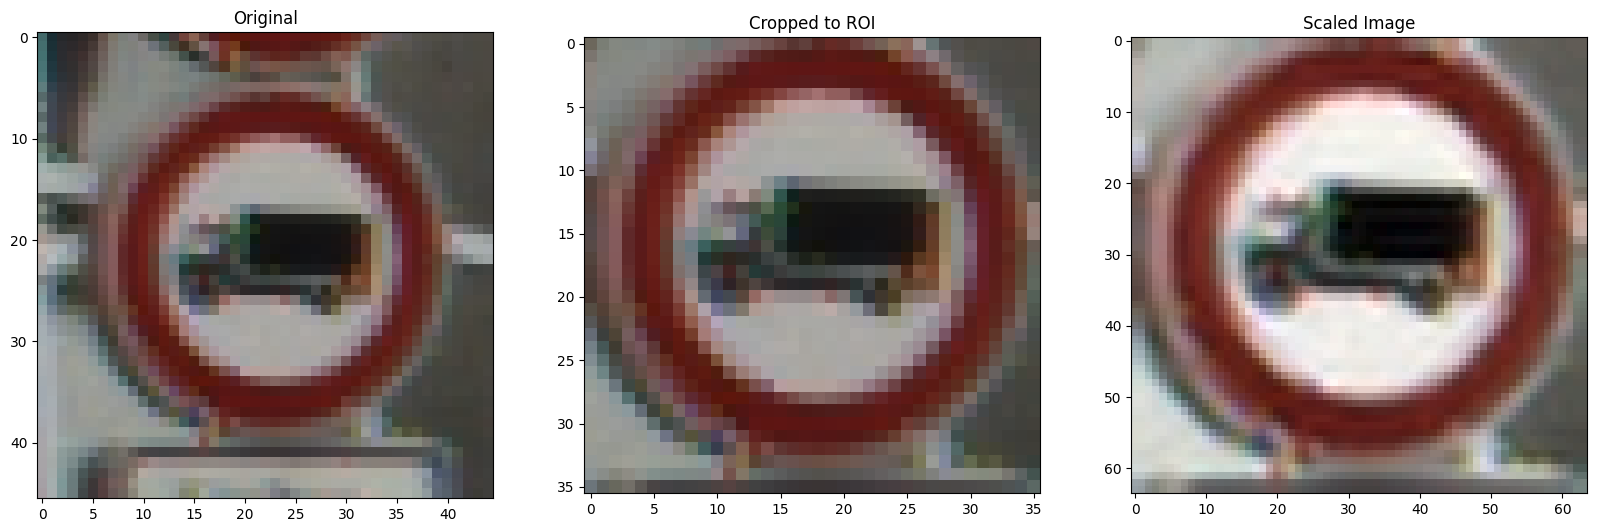

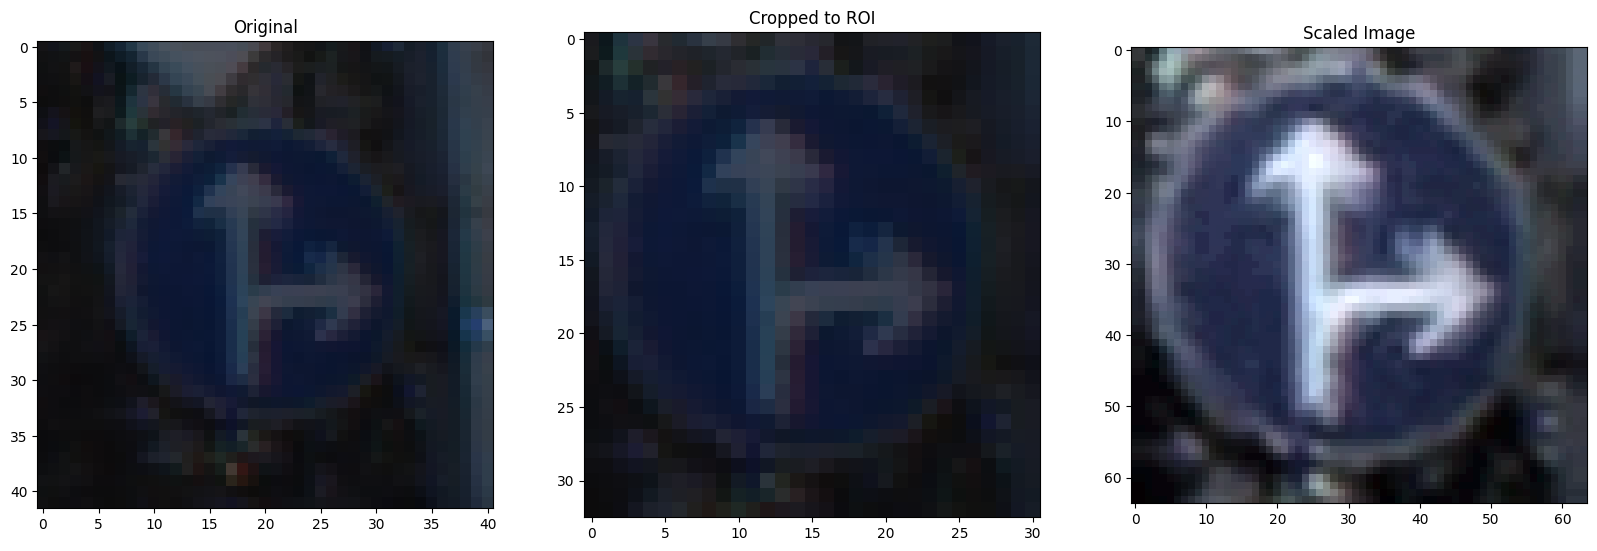

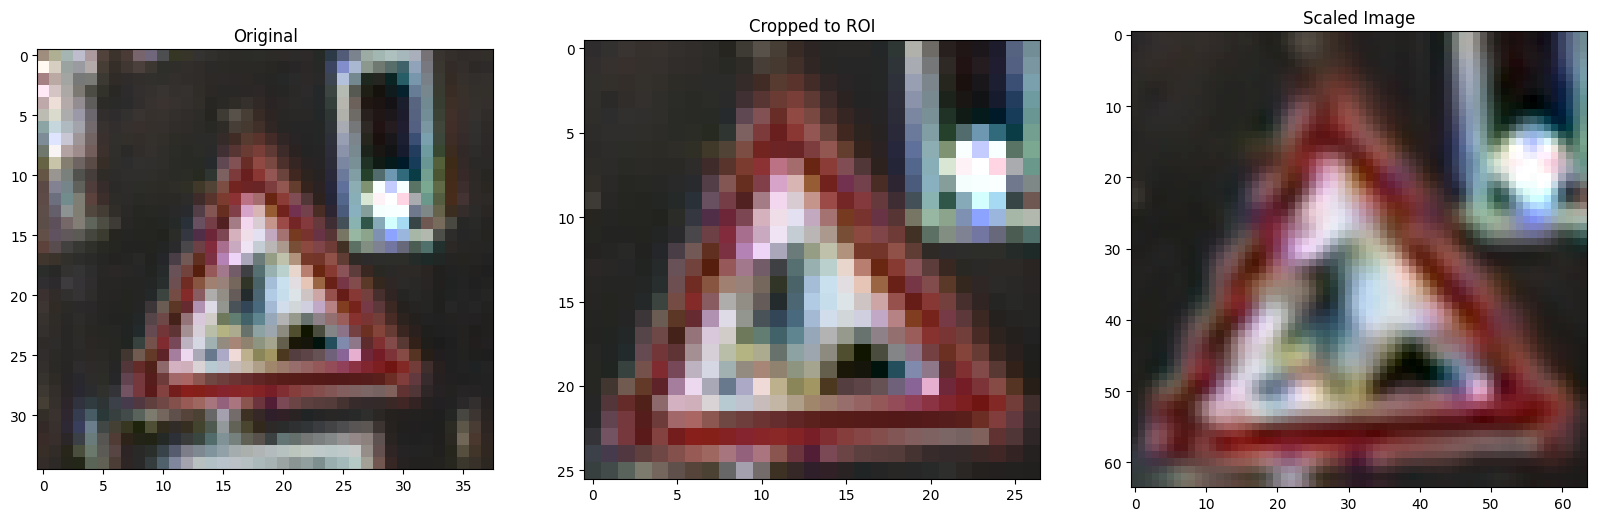

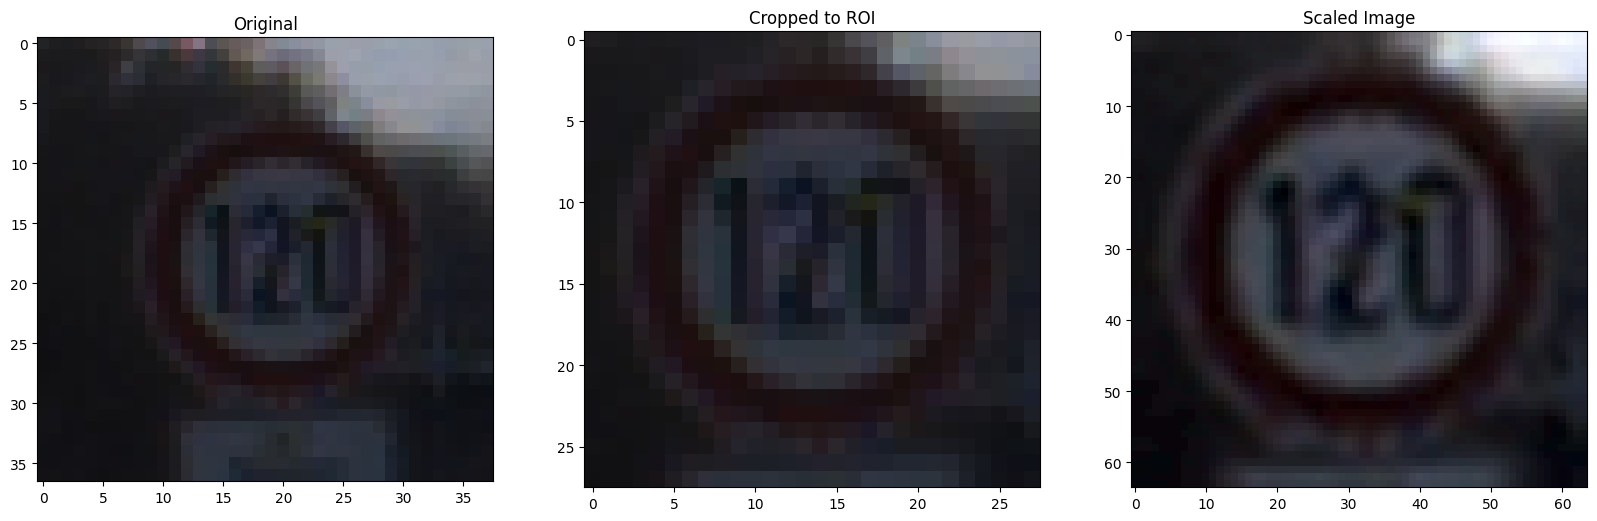

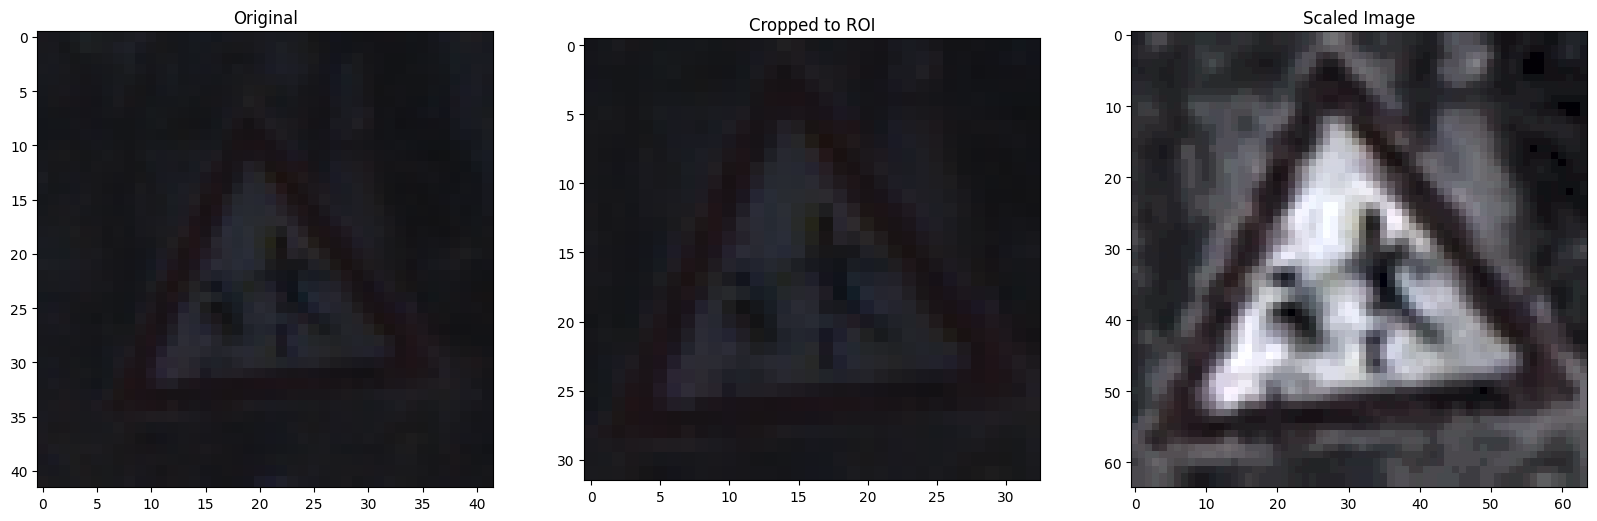

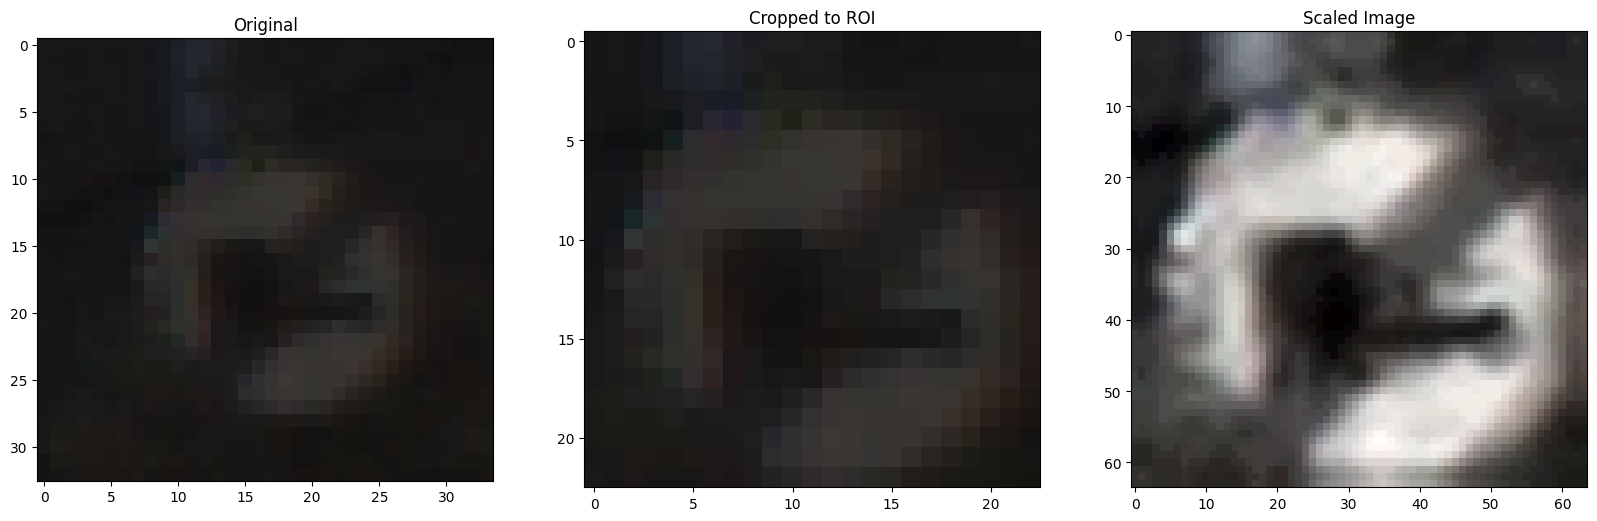

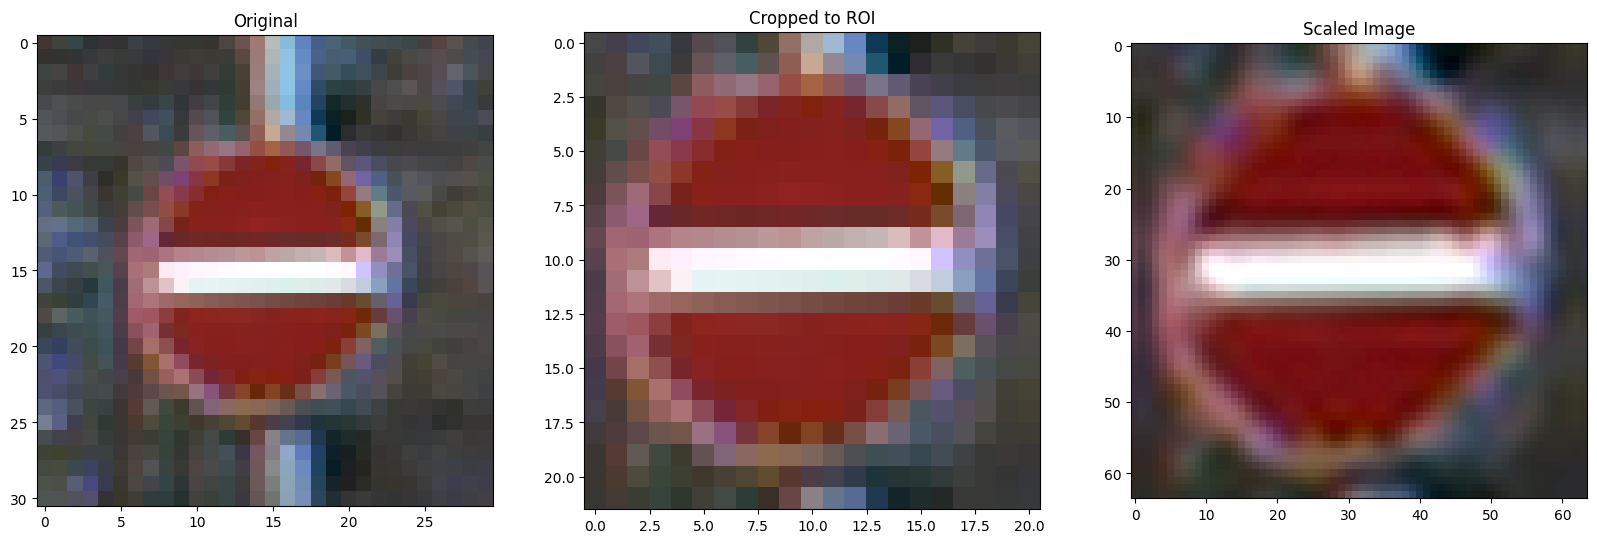

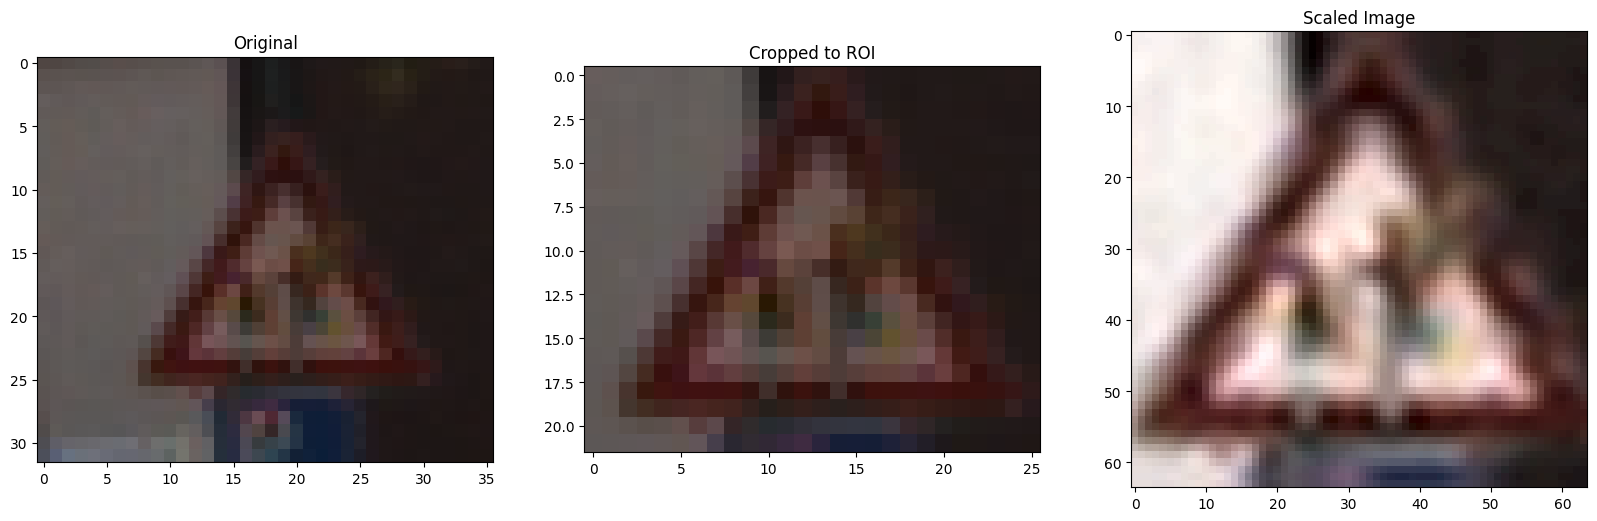

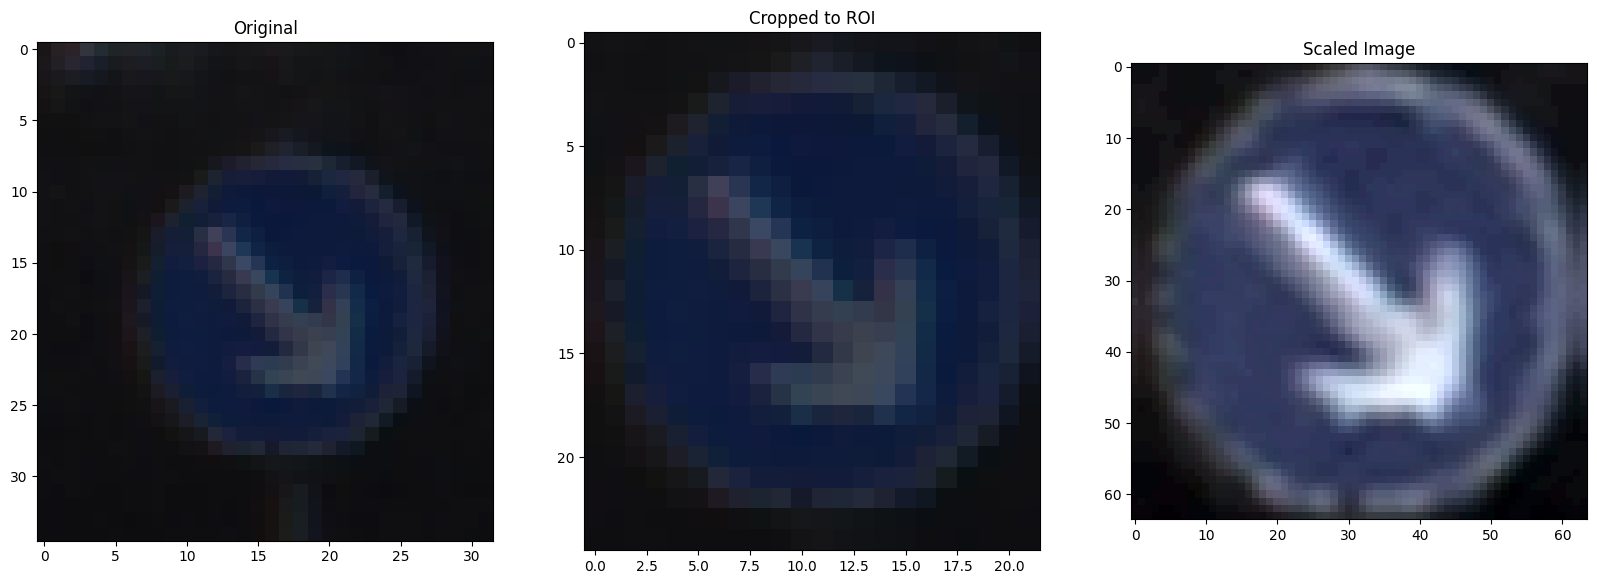

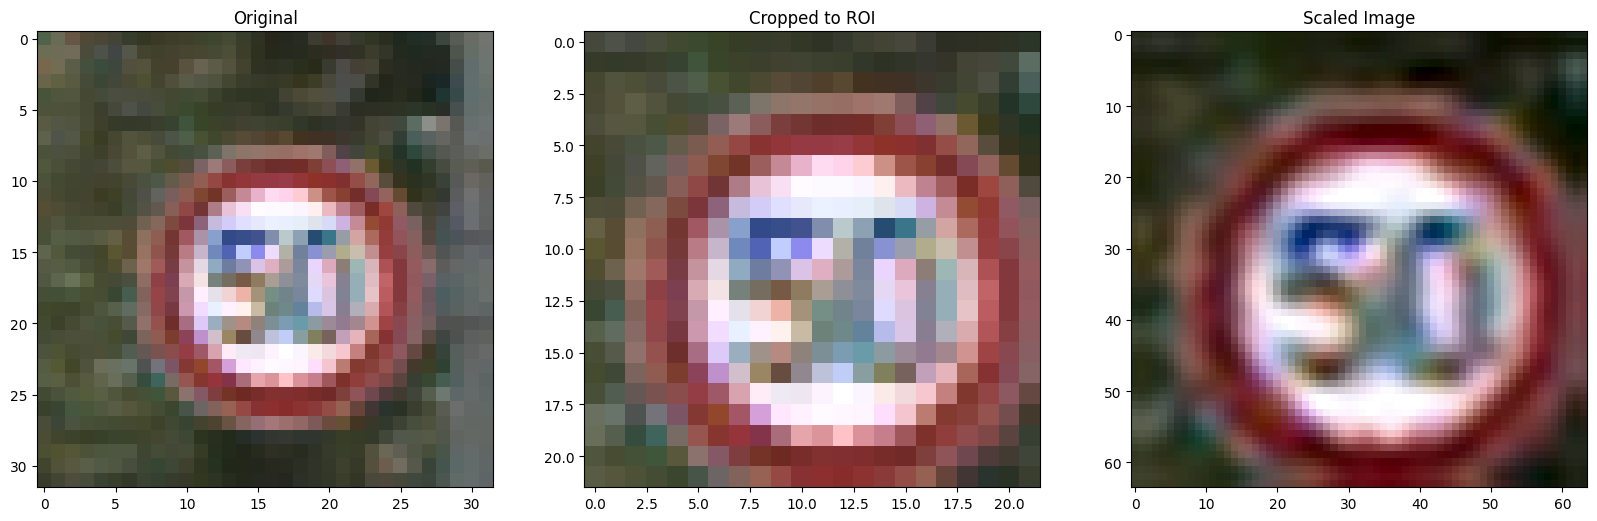

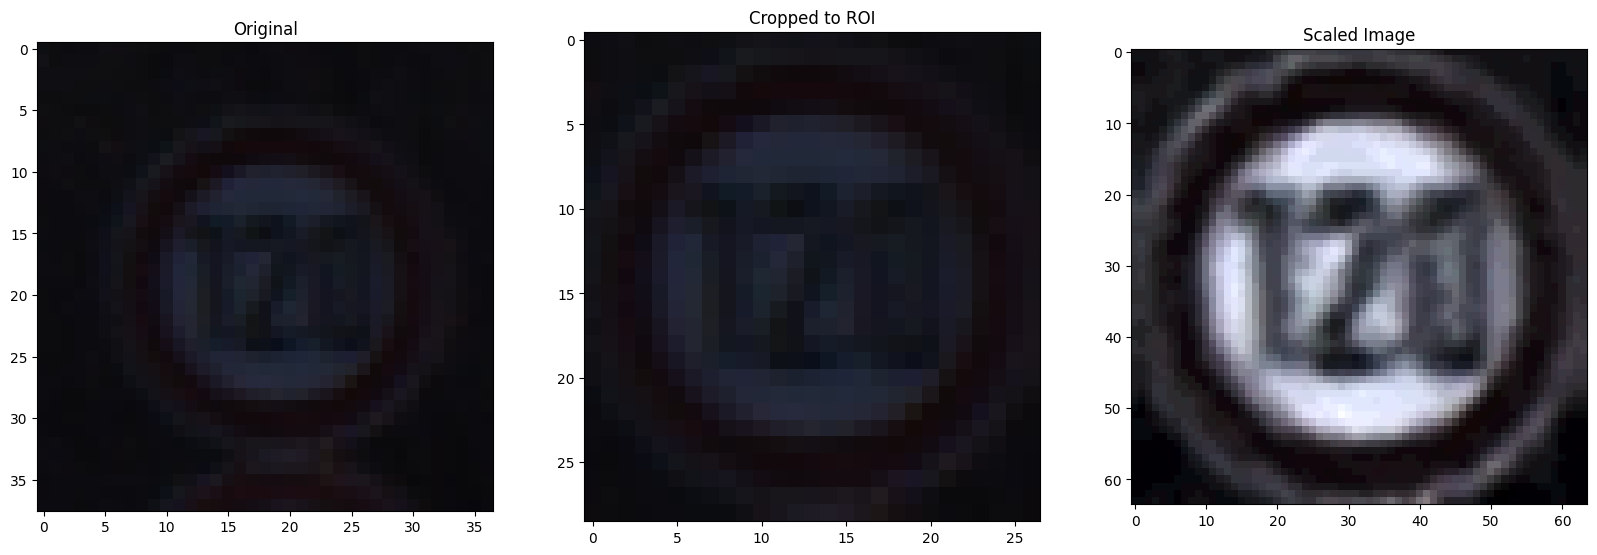

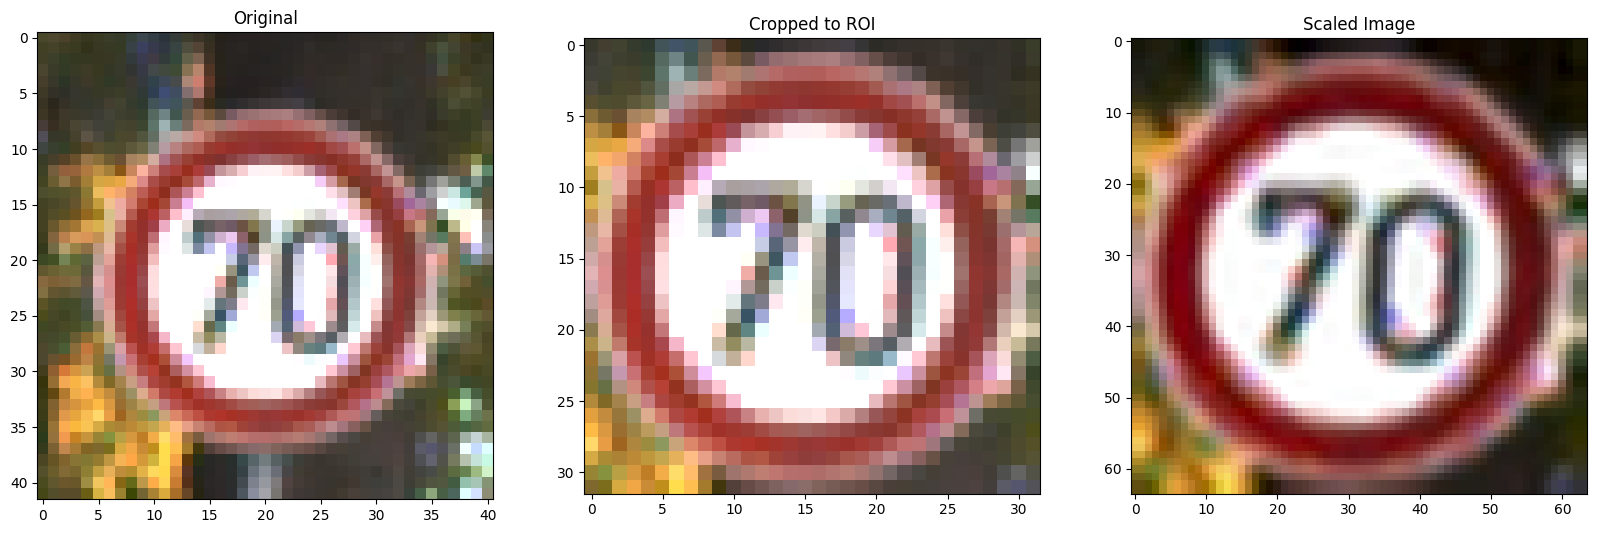

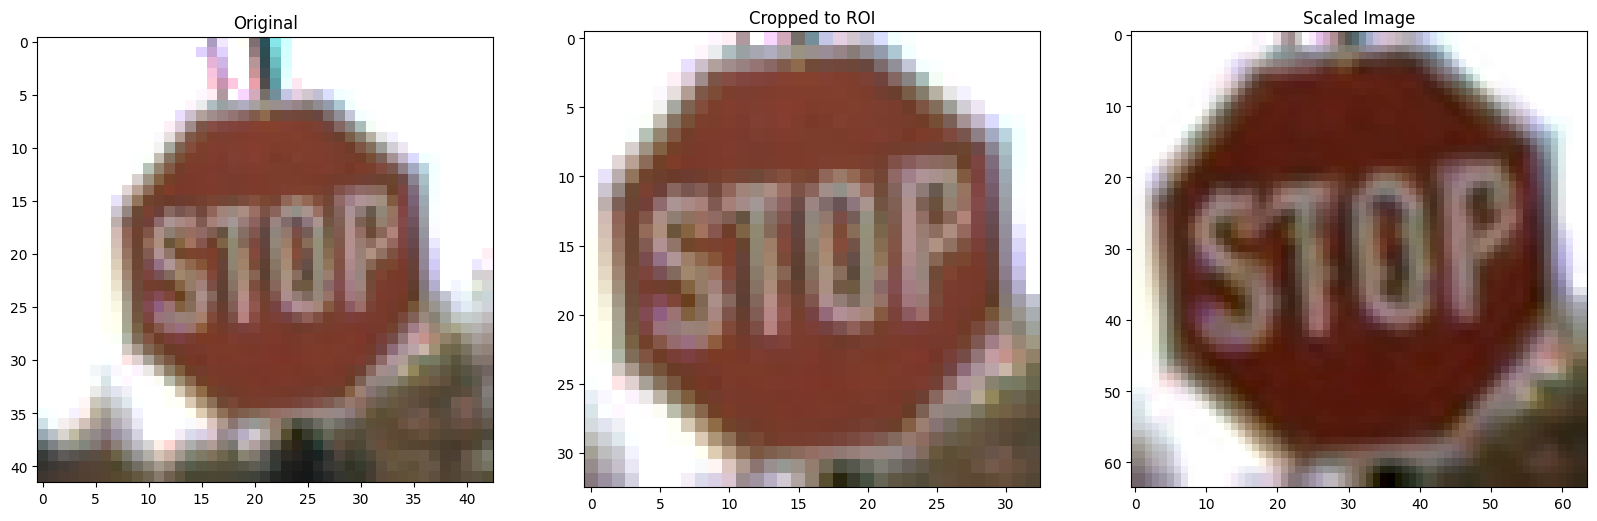

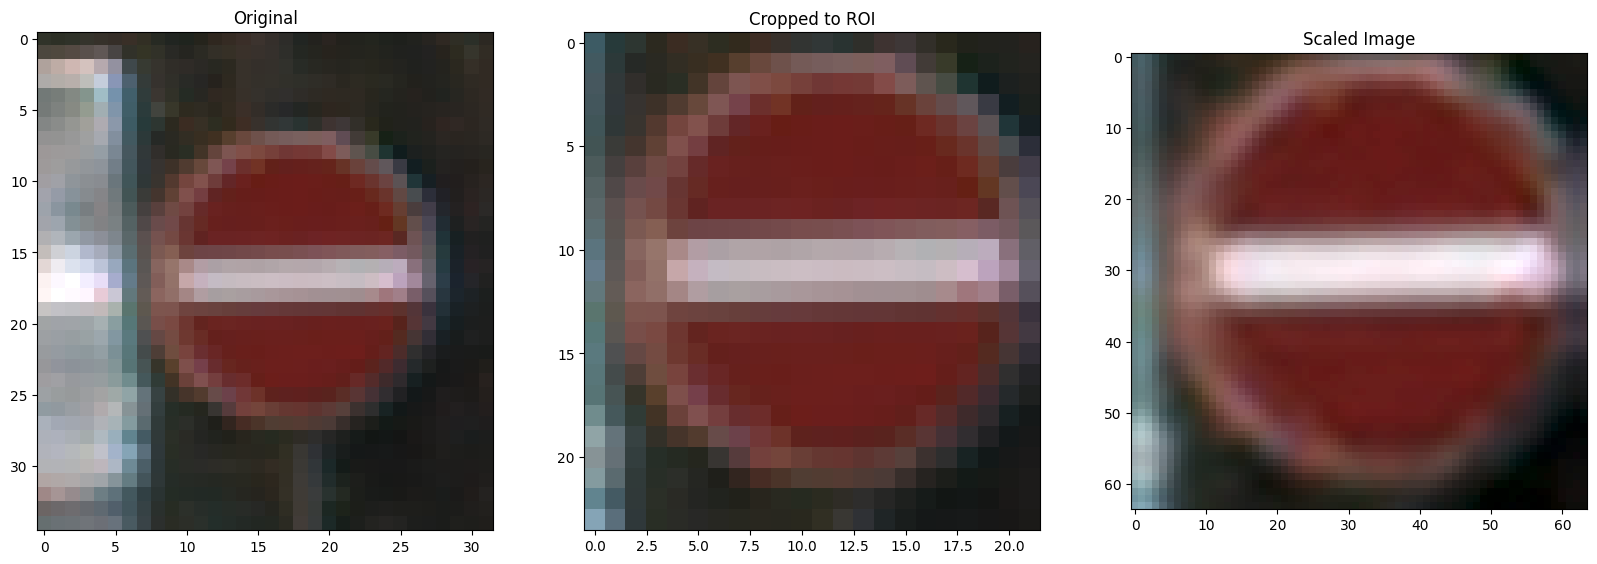

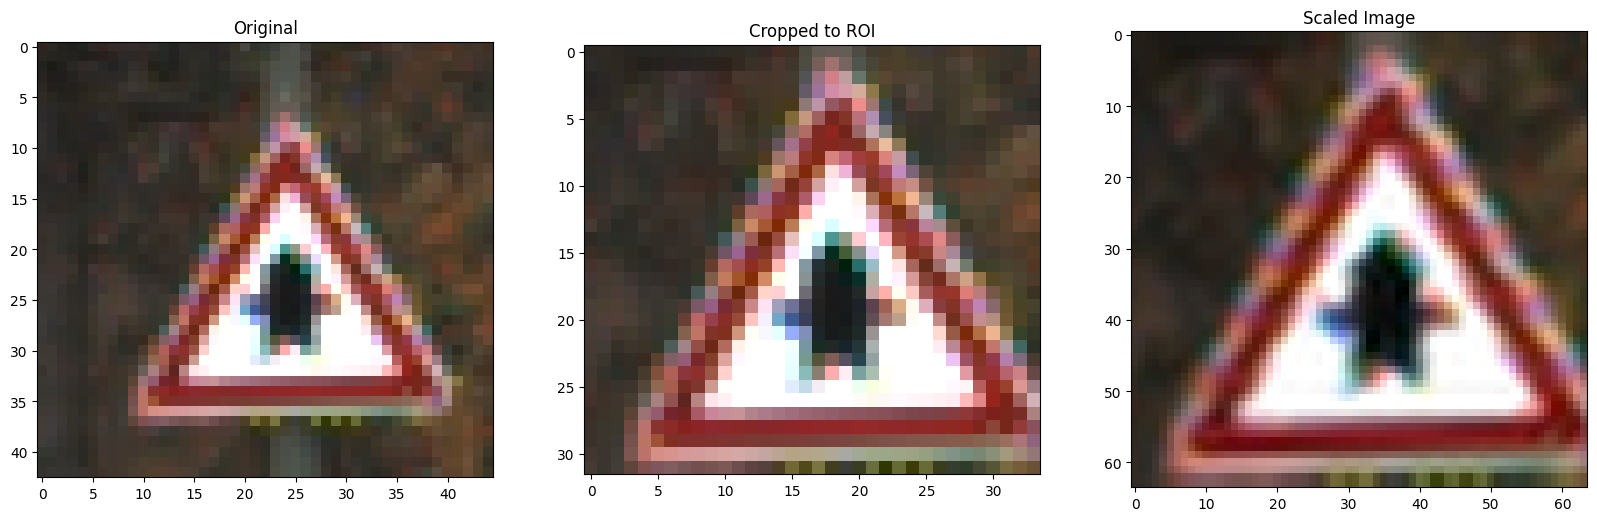

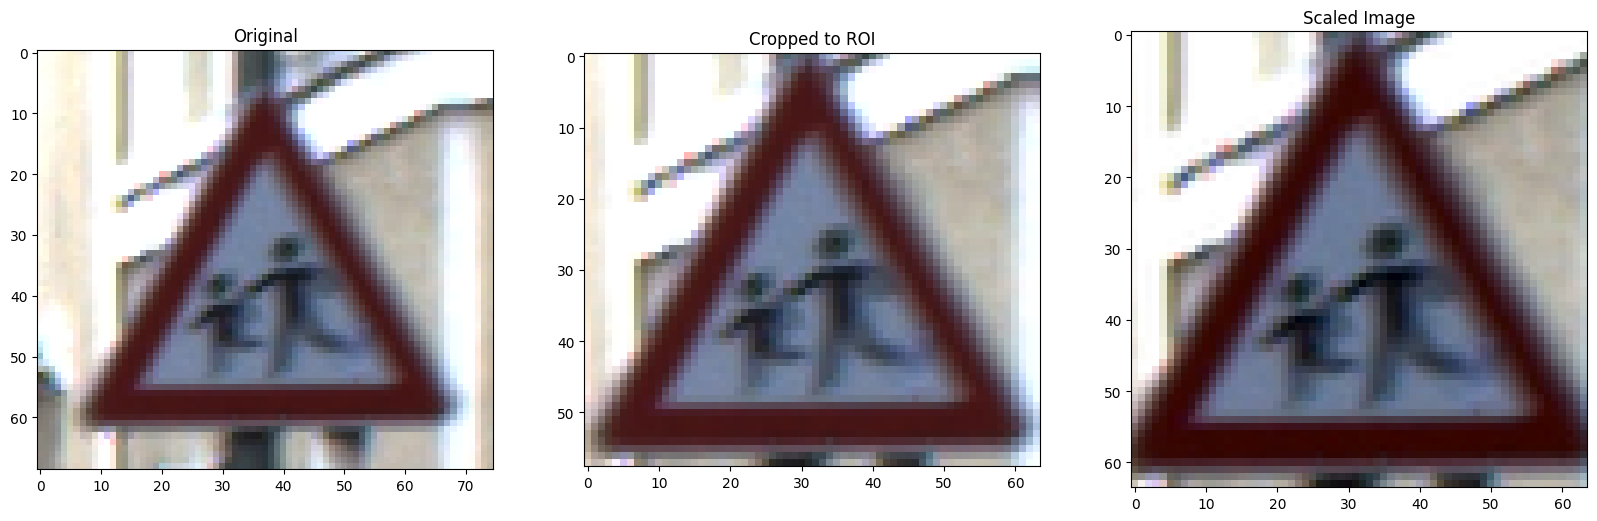

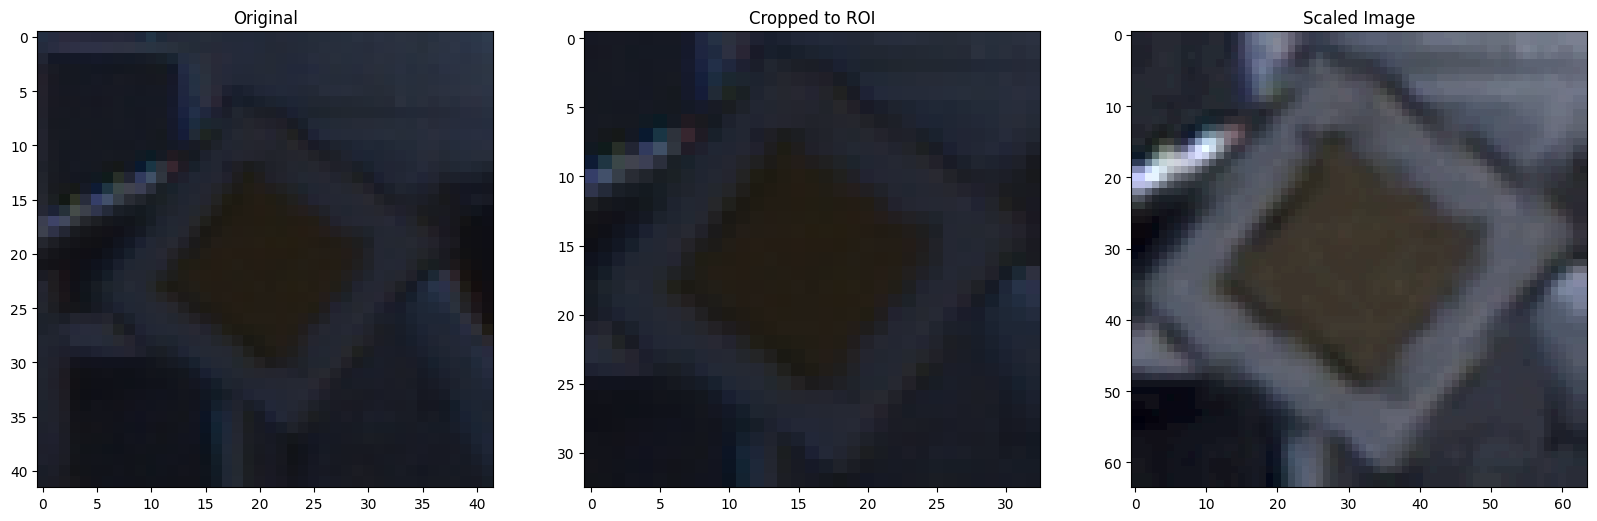

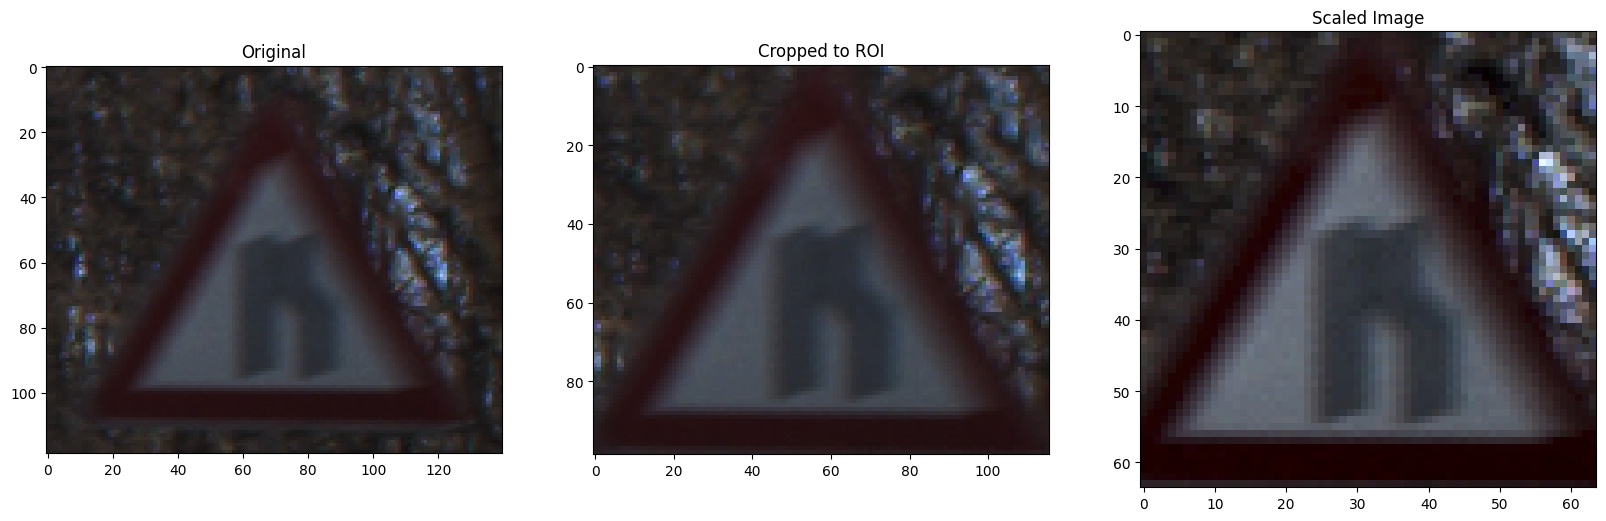

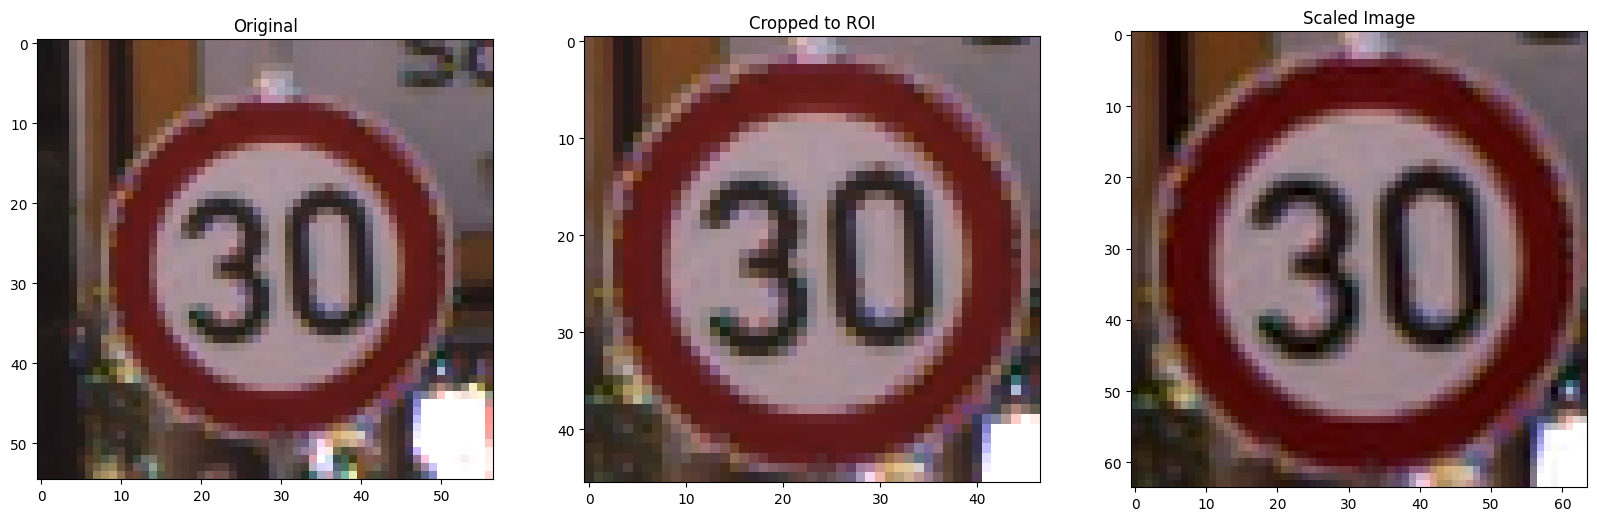

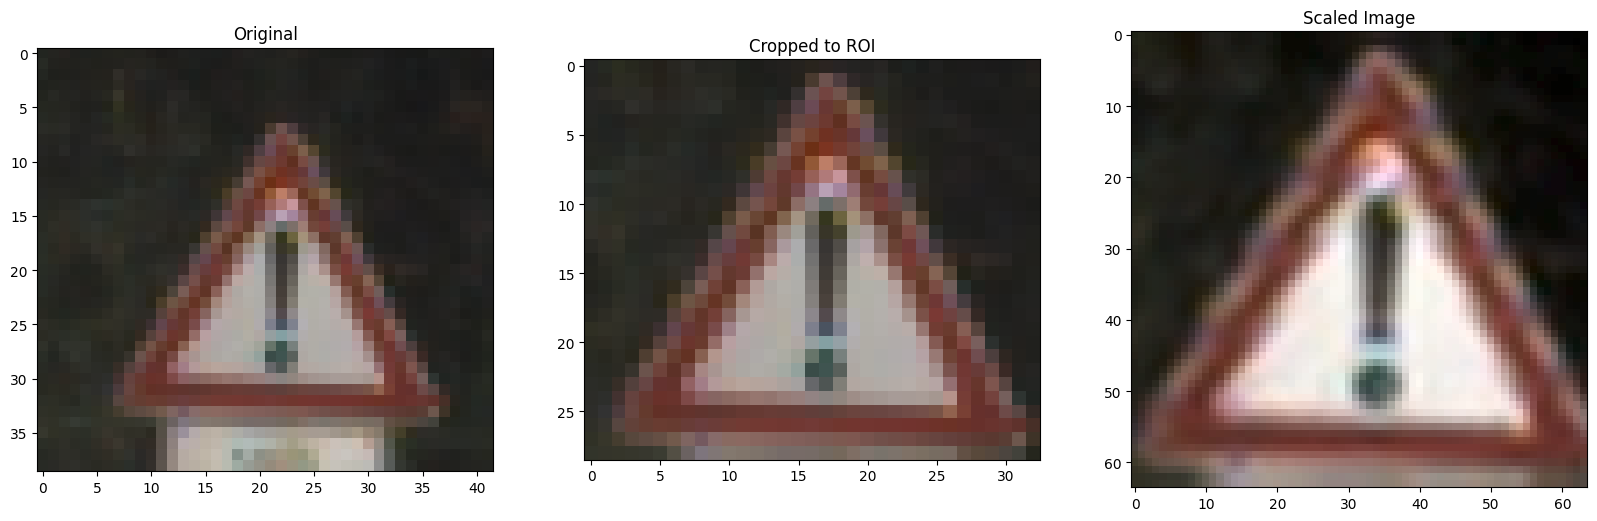

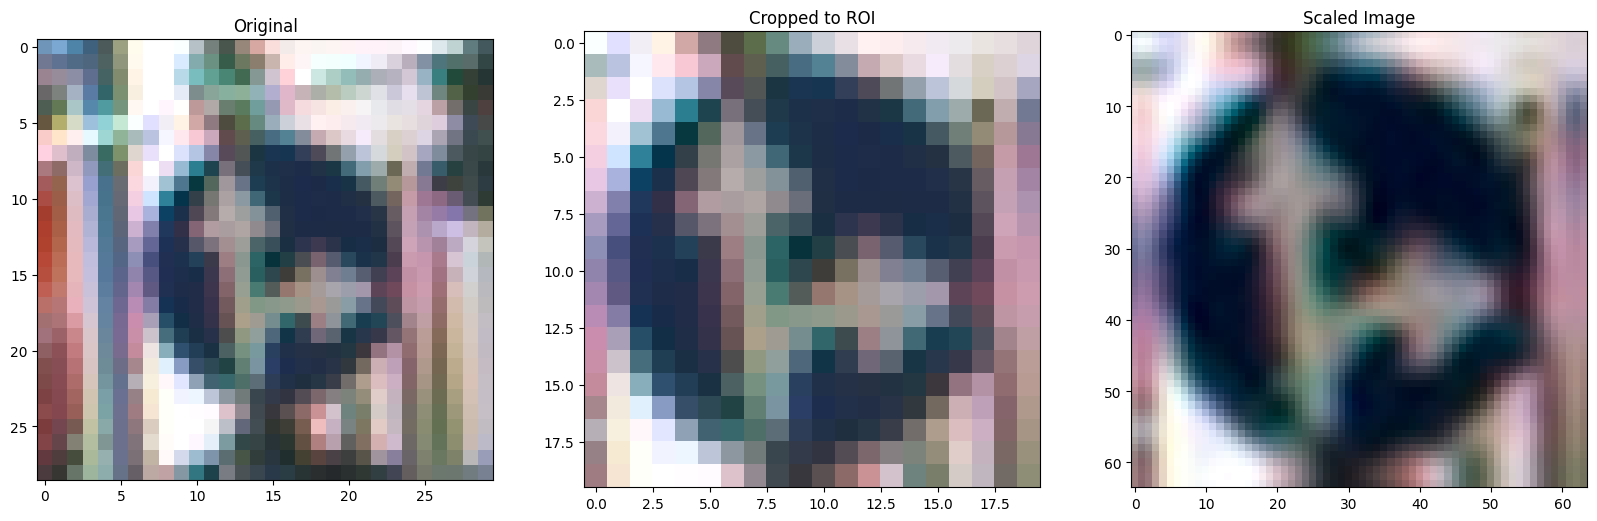

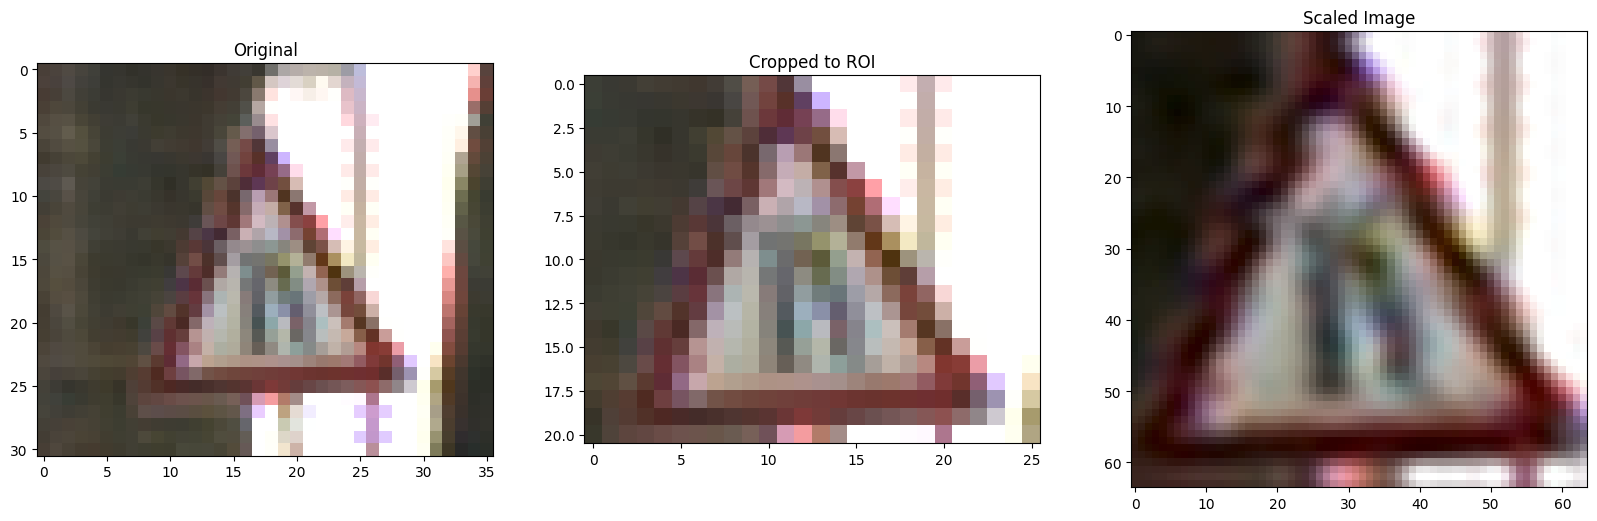

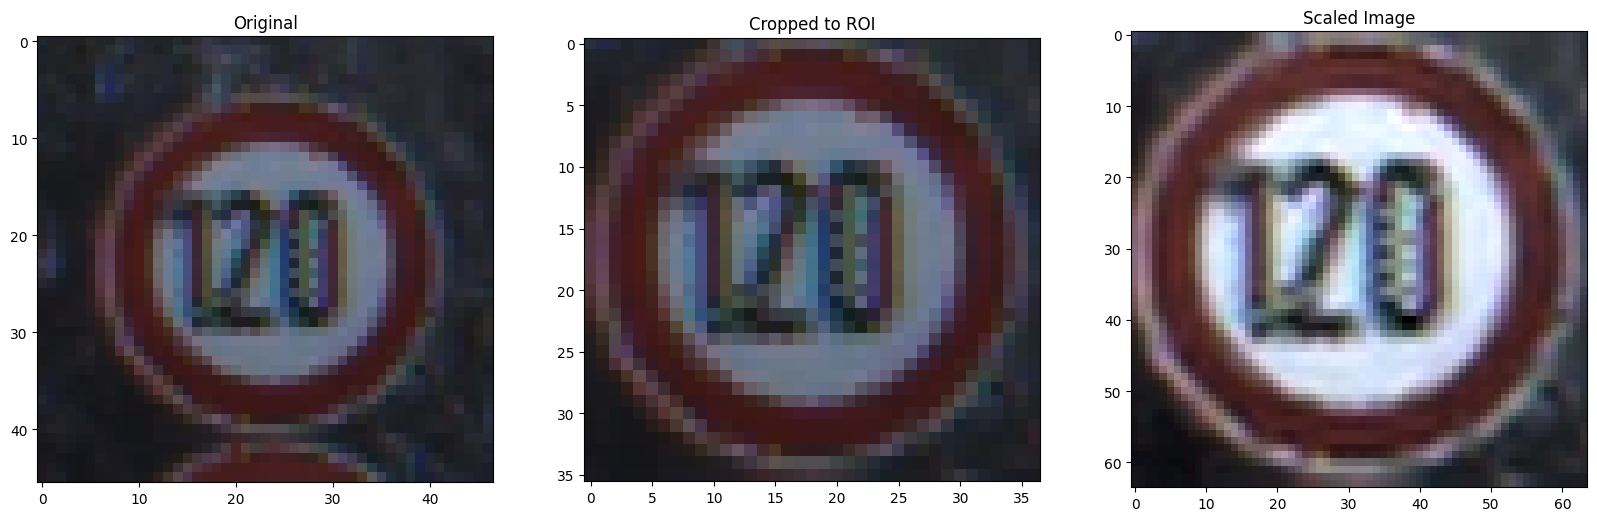

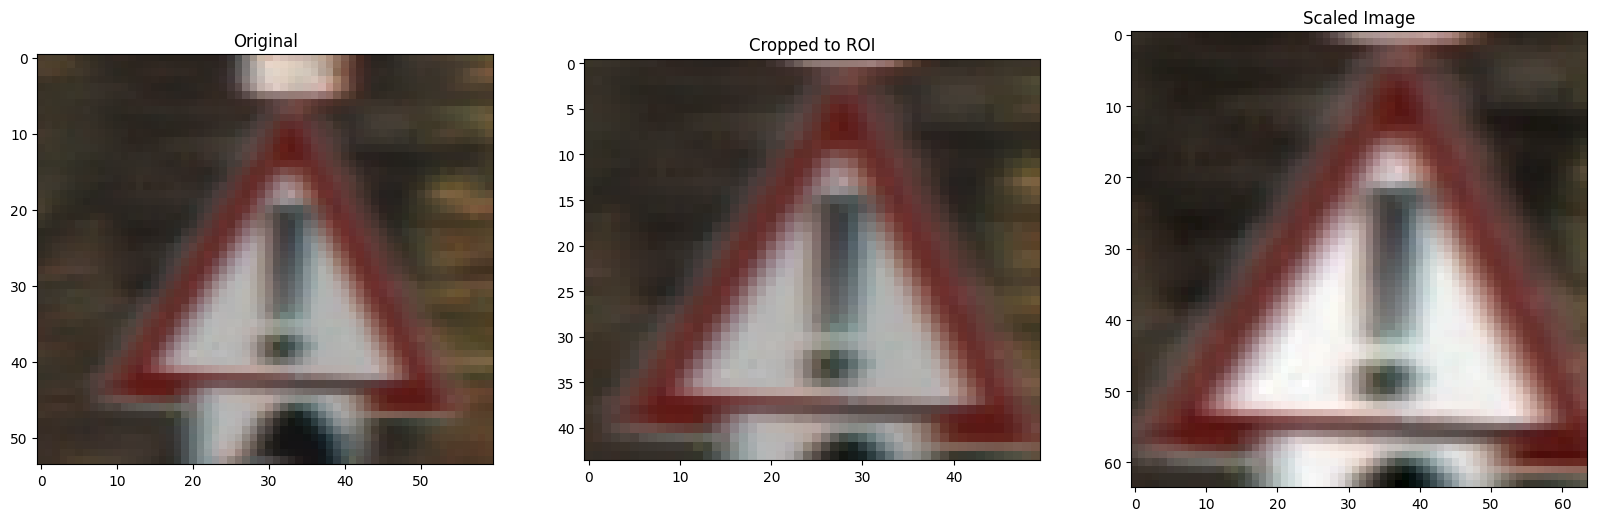

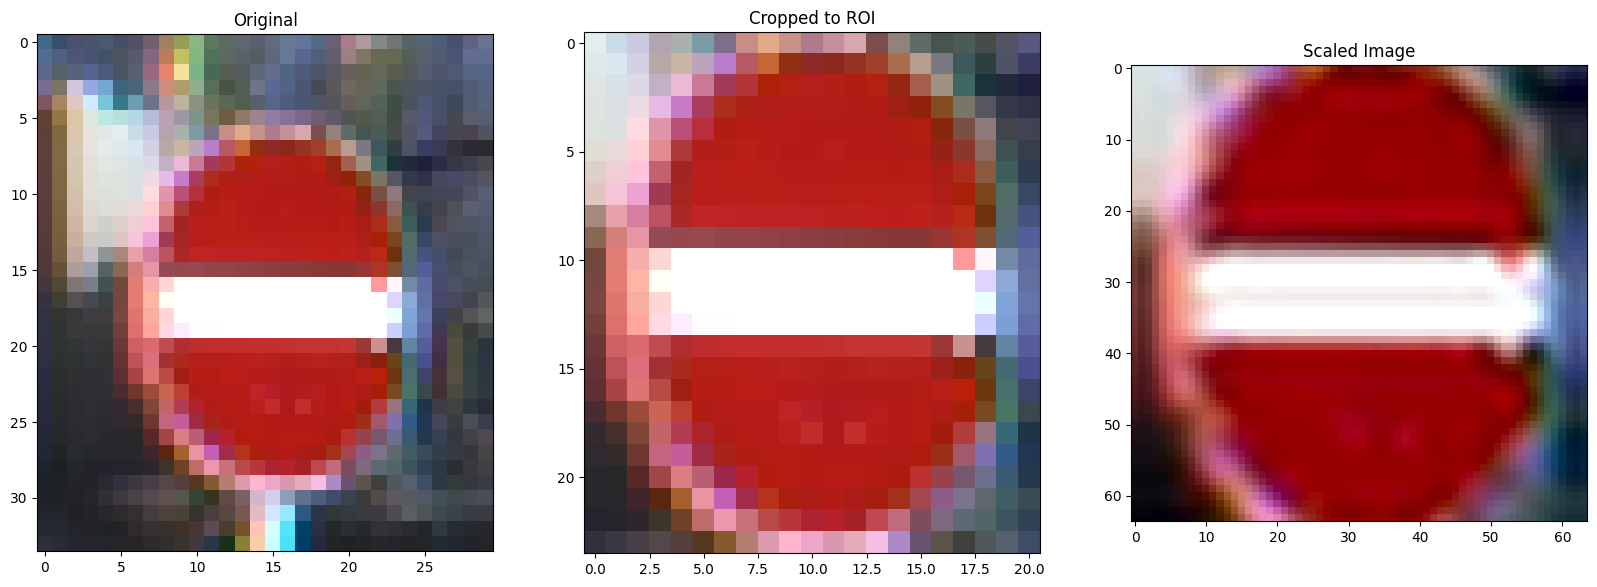

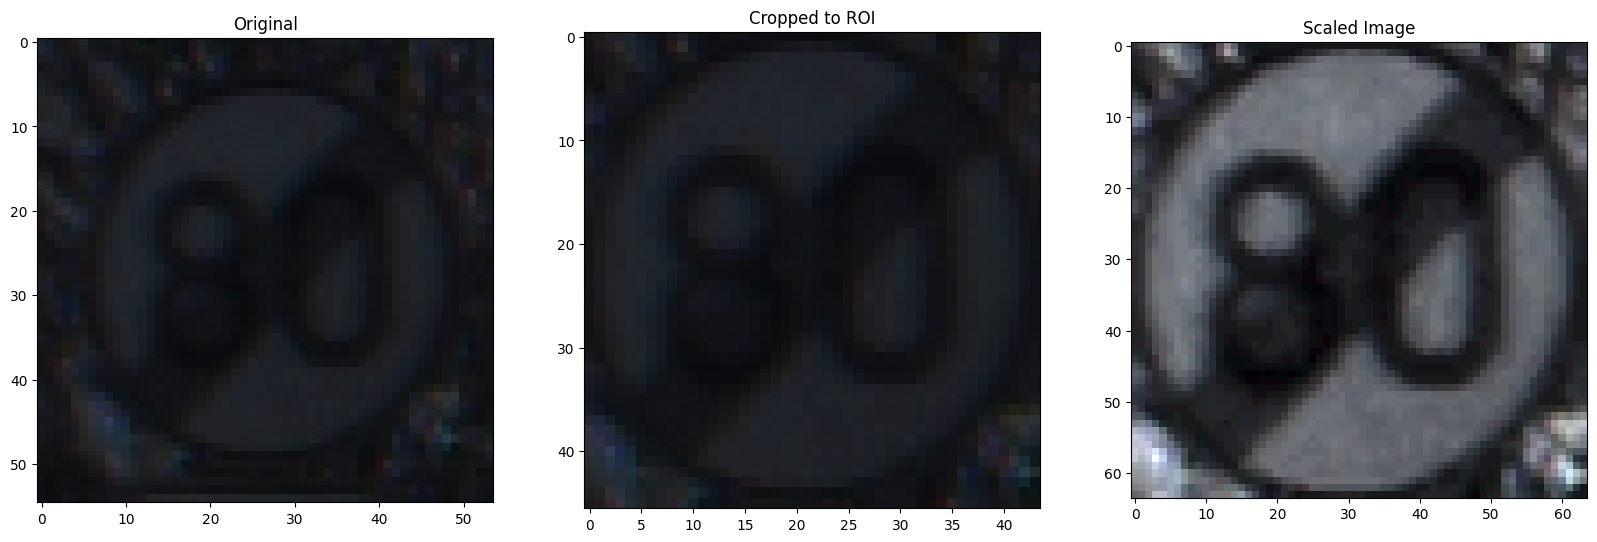

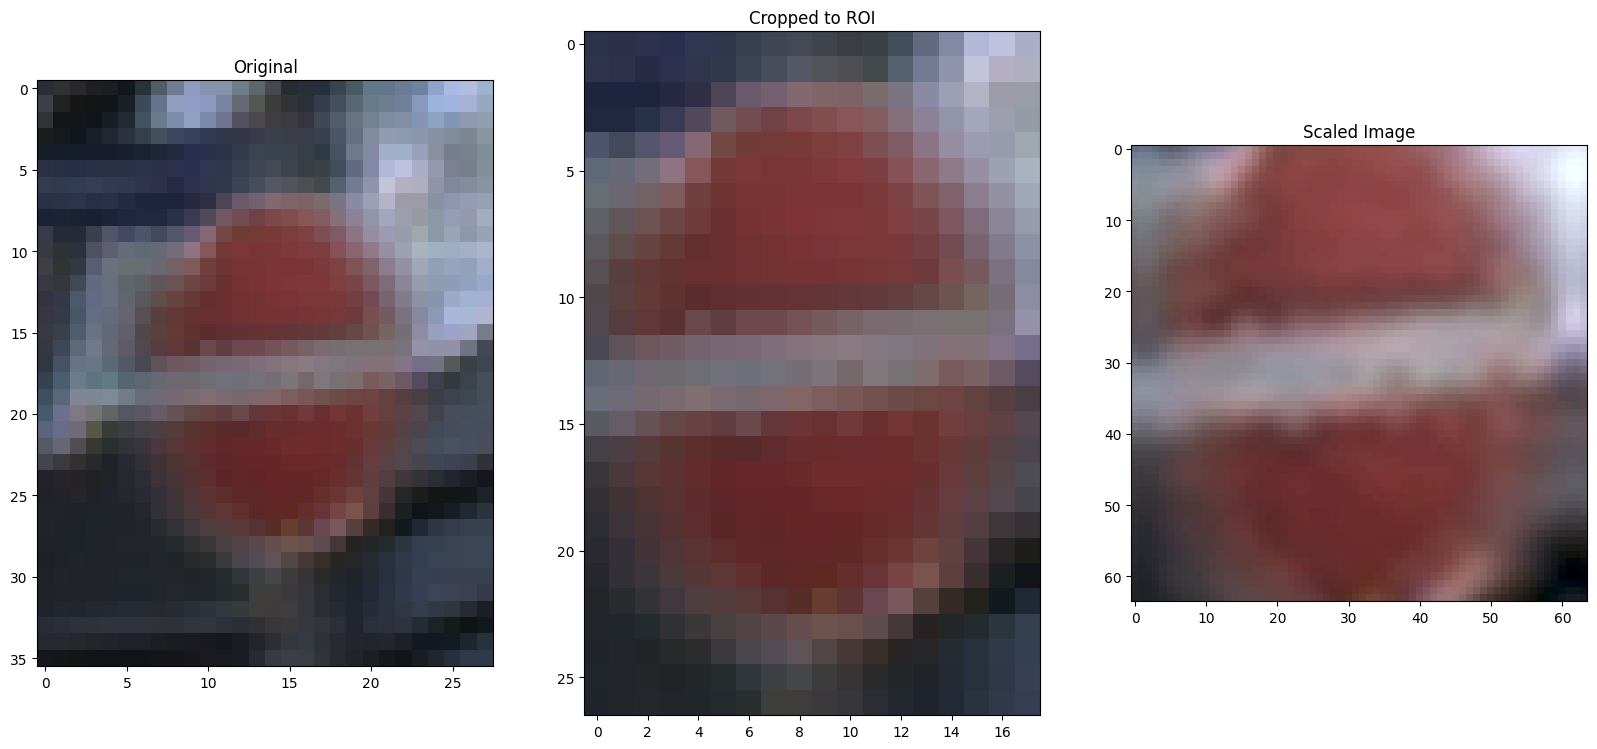

In [14]:
samples = dft.sample(100, with_replacement=False)

# iteration this way is not efficient, but it's a small dataset and we want to display it only
# no harm done
for r in samples.iter_rows(named=True):
    image = restore_image_from_list(r["Width"], r["Height"], r["Image"])
    cropped_image = restore_image_from_list(
        r["Cropped_Width"], r["Cropped_Height"], r["Cropped_Image"]
    )
    scaled_image = restore_image_from_list(
        r["Scaled_Width"], r["Scaled_Height"], r["Scaled_Image"]
    )
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(image_for_display(image))
    ax.set_title("Original", size=12)
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(image_for_display(cropped_image))
    ax.set_title("Cropped to ROI", size=12)
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(stretch_histogram(image_for_display(scaled_image)))
    ax.set_title("Scaled Image", size=12)